### Bug记录
```
1. Datalab平台pdf文件无法保存
2. XGboost模型在五折交叉验证过程中一直无法得到正确的AUC分数
3. lgb.LGBMClassifier和lgb.train的区别
4. 随机森林和lgbm模型的特征重要性都小于0.2
5. 目前只进行了训练，还没进行测试集验证
6. 随机森林的shap分析现在存在bug
```

### 1、数据预处理与数据集划分
```
主要负责数据的加载、清洗、特征转换以及最终的数据集划分。我们引入了自定义的数据处理管道模块，对原始的静态临床数据进行一系列预处理操作，并将其划分为训练集和测试集。

- 导入必要的库和自定义模块,包括用于删除常量列和二元化毒性等级的工具类。
- 读取静态数据 CSV 文件，并使用 ConstantColumnDropper 删除数值完全相同的列（即所有样本在该列上的值都一样，不具备区分度）。
- 使用 ToxicityBinarizer 将多个毒性指标（如 CRS、ICANS、Infection）根据阈值转换为二分类变量（例如：等级 > 2 视为严重，标记为 1；否则为 0）。
- 清洗目标变量列（Infection）中的缺失值，并重置索引以确保数据连续性。
- 使用 PatientLevelStratifiedSplitterWithCV 进行
```

基于患者层面的分层划分，生成训练集、测试集以及交叉验证折，确保同一患者的数据不会同时出现在训练集和测试集中，避免数据泄露。

### 关于字体BUGfindfont: 
```
Generic family 'serif' not found because none of the following families were found: Times New Roman
参考：https://zhuanlan.zhihu.com/p/509574840

把windows下的Times New Roman字体上传到本地虚拟环境中的字体文件夹中
/opt/anaconda3/envs/pl/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/times.ttf
然后删除matplotlib的缓存
rm -rf /home/phl/.cache/matplotlib
最后重启vscode，重新运行代码
```

In [36]:
# 设置工作路径
import os
os.chdir("/home/phl/PHL/Car-T/model_v1")

# 获取并打印当前工作路径
current_path = os.getcwd()
print("当前工作路径：", current_path)

当前工作路径： /home/phl/PHL/Car-T/model_v1


In [37]:
import pandas as pd         # 导入Pandas库，用于数据处理
import numpy as np          # 导入NumPy库，用于数值计算
import os
import matplotlib.pyplot as plt

# 导入模型选择模块中的train_test_split，用于拆分数据集
from sklearn.model_selection import train_test_split

# 导入预处理模块中的StandardScaler 和OneHotEncoder，用于数据标准化和独热编码
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 导入逻辑回归模型
from sklearn.linear_model import LogisticRegression

# 导入随机森林分类器
from sklearn.ensemble import RandomForestClassifier

# 导入多层感知器分类器
from sklearn.neural_network import MLPClassifier

# 导入支持向量机分类器
from sklearn.svm import SVC

# 导入XGBoost库
# !pip install xgboost -i https://mirrors.aliyun.com/pypi/simple/
import xgboost as xgb

#导入LightGBM库
import lightgbm as lgb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble  import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier     # pip install catboost
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm                # pip install statsmodels
from pytorch_tabnet.tab_model import TabNetClassifier

import shap
# plt.rcParams['font.sans-serif'] = ['SimSun'] #宋体
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']

In [38]:
import sys
import importlib

# 清除缓存并重新加载模块
if 'pipeline.perfect_pipeline' in sys.modules:
    importlib.reload(sys.modules['pipeline.perfect_pipeline'])

In [39]:
# 动态基线特征提起取和缺失值过滤相关函数
import pandas as pd
import numpy as np
import os
from tqdm import tqdm  # 用于显示进度条
import matplotlib.pyplot as plt
from collections import defaultdict
import json
from datetime import datetime


# ==============================================================
# 0. 数据监控类（动态基线特征提取函数定义——补充功能）
# ==============================================================
class VariableMonitor:
    """
    监控特定变量在数据提取过程中的空数据情况。
    
    功能：
    1. 追踪指定变量何时为空
    2. 记录在指定时间区间内未找到有效数据的患者ID
    3. 保存患者ID以供后续手动检查
    
    用法示例：
        monitor = VariableMonitor(variables_to_monitor=['CBC004', 'CBC001'])
        # 在数据提取过程中调用 record_patient_data 方法
        # 最后调用 get_empty_patient_ids() 或 save_report() 获取结果
    """
    
    def __init__(self, variables_to_monitor=None, time_window=(-15, 0)):
        """
        初始化监控器
        
        参数:
            variables_to_monitor: 要监控的变量列表，例如 ['CBC004', 'CBC001']
            time_window: 监控的时间窗口，默认 (-15, 0)
        """
        self.variables_to_monitor = variables_to_monitor or []
        self.time_window = time_window
        
        # 记录每个变量的空数据患者ID
        # 结构: {variable_name: set(patient_ids)}
        self.empty_data_patients = {var: set() for var in self.variables_to_monitor}
        
        # 记录详细信息（可选）
        # 结构: {variable_name: {patient_id: {'reason': str, 'time_range': tuple}}}
        self.detailed_info = {var: {} for var in self.variables_to_monitor}
        
        # 统计信息
        self.total_patients_processed = 0
        
    def record_patient_data(self, patient_id, variable_name, has_data, time_range=None, reason=None):
        """
        记录患者的数据状态
        
        参数:
            patient_id: 患者ID
            variable_name: 变量名称
            has_data: 是否有有效数据 (bool)
            time_range: 实际数据的时间范围 (可选)
            reason: 为空的原因 (可选)，例如 'no_file', 'no_data_in_window', 'variable_missing'
        """
        if variable_name not in self.variables_to_monitor:
            return
        
        if not has_data:
            self.empty_data_patients[variable_name].add(patient_id)
            self.detailed_info[variable_name][patient_id] = {
                'reason': reason or 'unknown',
                'time_range': time_range,
                'timestamp': datetime.now().isoformat()
            }
    
    def get_empty_patient_ids(self, variable_name=None):
        """
        获取指定变量（或所有变量）的空数据患者ID集合
        
        参数:
            variable_name: 变量名称，如果为 None，返回所有变量的结果
            
        返回:
            如果指定变量名，返回该变量的患者ID集合
            如果未指定，返回字典 {variable_name: set(patient_ids)}
        """
        if variable_name:
            return self.empty_data_patients.get(variable_name, set())
        return self.empty_data_patients
    
    def get_summary(self):
        """
        获取监控摘要信息
        
        返回:
            dict: 包含各变量的统计信息
        """
        summary = {}
        for var in self.variables_to_monitor:
            empty_count = len(self.empty_data_patients[var])
            summary[var] = {
                'empty_patient_count': empty_count,
                'empty_patient_ids': sorted(list(self.empty_data_patients[var])),
                'time_window': self.time_window
            }
        
        summary['total_patients_processed'] = self.total_patients_processed
        return summary

    def save_report(self, output_path='monitor_report.json', include_details=True):
        """
        保存监控报告到文件
        
        参数:
            output_path: 输出文件路径
            include_details: 是否包含详细信息
        """
        report = {
            'monitoring_config': {
                'variables': self.variables_to_monitor,
                'time_window': self.time_window,
                'total_patients': int(self.total_patients_processed),  # 转换为 int
                'generated_at': datetime.now().isoformat()
            },
            'summary': self._convert_to_json_serializable(self.get_summary())  # 递归转换
        }
        
        if include_details:
            report['detailed_info'] = self._convert_to_json_serializable({
                var: {pid: info for pid, info in patient_info.items()}
                for var, patient_info in self.detailed_info.items()
            })
        
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        
        print(f"\n监控报告已保存至: {output_path}")
        return output_path

    def _convert_to_json_serializable(self, obj):
            """
            递归转换 NumPy/Pandas 类型为 JSON 可序列化的 Python 原生类型
            递归处理字典的 Keys 和 Values
            """
            import numpy as np
            
            if isinstance(obj, dict):
                # 遍历字典时，同时通过 int() 转换 Key，防止 Keys 是 int64 类型
                new_dict = {}
                for key, value in obj.items():
                    # 如果 Key 是 numpy 整数类型，强转为 Python int
                    if isinstance(key, (np.integer, np.int64, np.int32)):
                        new_key = int(key)
                    else:
                        new_key = key
                    new_dict[new_key] = self._convert_to_json_serializable(value)
                return new_dict
                
            elif isinstance(obj, list):
                return [self._convert_to_json_serializable(item) for item in obj]
            elif isinstance(obj, set):
                return sorted([self._convert_to_json_serializable(item) for item in obj])
            elif isinstance(obj, (np.integer, np.int64, np.int32)):
                return int(obj)
            elif isinstance(obj, (np.floating, np.float64, np.float32)):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            else:
                return obj
        
    def print_summary(self):
        """打印监控摘要到控制台"""
        print("\n" + "="*60)
        print("变量监控摘要报告")
        print("="*60)
        print(f"监控时间窗口: {self.time_window}")
        print(f"处理患者总数: {self.total_patients_processed}")
        print("-"*60)
        
        for var in self.variables_to_monitor:
            empty_count = len(self.empty_data_patients[var])
            print(f"\n变量: {var}")
            print(f"  空数据患者数: {empty_count}")
            if empty_count > 0:
                print(f"  患者ID列表: {sorted(list(self.empty_data_patients[var]))[:10]}" + 
                      (f" ... (共{empty_count}个)" if empty_count > 10 else ""))
        
        print("="*60 + "\n")

# ==============================================================
# 1.动态基线特征提取函数定义
# ==============================================================
def extract_baseline_features(patient_ids, dynamic_dir, time_col='day', window_start=-15, cutoff_day=0, monitor=None):
    """
    从动态文件中提取 [window_start, cutoff_day] 区间内的最后一次有效观测值作为基线特征。
    
    执行顺序（已优化）：
    1. 提取基线特征（不调用monitor）
    2. 补充额外数据（Biochemistry 和 CBC）
    3. 在数据补充完成后运行monitor统计
    
    参数:
        patient_ids: 患者 ID 列表
        dynamic_dir: 动态数据文件夹路径
        time_col: 时间列名，支持大小写模糊匹配，默认为 'day'
        window_start: 时间窗口起始天数 (默认 -15)
        cutoff_day: 时间窗口结束天数 (默认 0)
        monitor: 监控器对象 (可选)，将在数据补充后运行
        逻辑说明：Sort -> Ffill -> Take Last -> Data Augmentation -> Monitor
    返回:
        df_features: 提取后的特征 DataFrame
        missing_pids: 在指定窗口内完全无数据的患者ID列表
    """
    extracted_features = []
    missing_pids = [] # 用于存储缺失数据的患者ID
    
    print(f"正在从 {len(patient_ids)} 个动态文件中提取基线特征 (Day [{window_start}, {cutoff_day}])...")
    
    # ========================================================================
    # 阶段 1: 提取基线特征（不调用 monitor）
    # ========================================================================
    for pid in tqdm(patient_ids):
        file_path = os.path.join(dynamic_dir, f"{pid}.csv")
        
        # 初始化字典，包含 ID
        patient_data = {'ID': pid}
        
        if os.path.exists(file_path):
            try:
                # 读取动态数据
                df_dyn = pd.read_csv(file_path)
                
                # 1. 健壮性修复：处理时间列名大小写不一致问题
                actual_time_col = None
                if time_col in df_dyn.columns:
                    actual_time_col = time_col
                else:
                    # 尝试查找忽略大小写的匹配
                    col_map = {c.lower(): c for c in df_dyn.columns}
                    if time_col.lower() in col_map:
                        actual_time_col = col_map[time_col.lower()]
                
                if actual_time_col:
                    # 2. 健壮性修复：强制转换时间列为数值型，处理脏数据
                    df_dyn[actual_time_col] = pd.to_numeric(df_dyn[actual_time_col], errors='coerce')
                    df_dyn = df_dyn.dropna(subset=[actual_time_col]) # 删除时间解析失败的行

                    # 3. 筛选：严格保留 [window_start, cutoff_day] 区间的数据
                    mask = (df_dyn[actual_time_col] >= window_start) & (df_dyn[actual_time_col] <= cutoff_day)
                    df_baseline_window = df_dyn[mask].copy()
                    
                    if not df_baseline_window.empty:
                        # 4. 排序：按时间升序排列 (Day -15 -> Day 0)
                        df_sorted = df_baseline_window.sort_values(by=actual_time_col, ascending=True)
                        
                        # ==========================================================
                        # 核心修复逻辑
                        # ==========================================================
                        # 解决"存在数据但提取为空"的问题,原代码仅取最后一行(iloc[-1])，会导致之前行存在的有效数据（稀疏数据）被遗漏.
                        # 问题：如果 Day -5 有值，Day -1 无值(NaN)，只取最后一行(Day -1)会导致 NaN。
                        # 修复：ffill() 会将 Day -5 的有效值"携带"到 Day -1。
                        # 这样最后一行就包含了截至该时刻所有变量的最新已知值。
                        df_filled = df_sorted.ffill() 
                        last_observation = df_filled.iloc[-1]
                        
                        # 5. 转换：提取特征
                        for col in last_observation.index:
                            # 排除 ID, 时间列 和 可能的索引列
                            if col != actual_time_col and col != 'ID' and not col.startswith('Unnamed'): 
                                patient_data[f"baseline_{col}"] = last_observation[col]
                        
                        # 记录Gap Days (评估数据新鲜度)
                        patient_data['baseline_gap_days'] = cutoff_day - last_observation[actual_time_col]

                    else:
                        # 窗口内没有数据
                        print(f"⚠️ 警告: 患者 {pid} 在窗口 [{window_start}, {cutoff_day}] 内无有效数据")
                        missing_pids.append(pid)
                else:
                    print(f"❌ 错误: 文件 {pid}.csv 中未找到时间列 '{time_col}'")
                    missing_pids.append(pid)

            except Exception as e:
                print(f"❌ 处理 ID {pid} 时发生异常: {e}")
                missing_pids.append(pid)
        else:
            # 文件不存在（静默处理，避免大量输出）
            pass
        
        extracted_features.append(patient_data)
    
    # 转换为 DataFrame
    df_features = pd.DataFrame(extracted_features)
    print(f"\n✅ 初始提取完成。共 {len(missing_pids)} 位患者基线数据完全缺失。")
    # if len(missing_pids) > 0:     # 可选：减少刷屏
    #     print(f"缺失数据患者ID示例: {missing_pids[:10]}")
    
    # ========================================================================
    # 阶段 2: 数据补充（在 monitor 之前执行）
    # ========================================================================
    print("\n" + "="*60)
    print("开始补充额外数据...")
    print("="*60)
    
    # ----------------------------------------------------------------
    # 第一部分：替换所有患者的 Biochemistry001 和 Biochemistry002
    # ----------------------------------------------------------------
    biochem_path = '/home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/Increase/Biochemistry_increase.csv'
    if os.path.exists(biochem_path):
        try:
            df_biochem = pd.read_csv(biochem_path)
            print(f"\n📄 读取 Biochemistry 补充数据: {biochem_path}")
            print(f"   - 数据维度: {df_biochem.shape}")
            print(f"   - 列名: {list(df_biochem.columns)}")
            
            # 确保列名匹配（添加 baseline_ 前缀）
            biochem_cols_to_replace = ['Biochemistry001', 'Biochemistry002']
            baseline_biochem_cols = [f'baseline_{col}' for col in biochem_cols_to_replace]
            
            # 检查目标列是否存在于提取的数据中
            existing_cols = [col for col in baseline_biochem_cols if col in df_features.columns]
            if not existing_cols:
                print(f"⚠️ 警告: 提取的数据中未找到 Biochemistry 列，跳过替换")
            else:
                # 合并前记录原始缺失情况
                original_missing = {}
                for col in existing_cols:
                    original_missing[col] = df_features[col].isna().sum()
                
                # 使用 merge 进行匹配并替换
                # 1. 准备补充数据（重命名列添加 baseline_ 前缀）
                df_biochem_renamed = df_biochem.rename(columns={
                    'Biochemistry001': 'baseline_Biochemistry001',
                    'Biochemistry002': 'baseline_Biochemistry002'
                })
                
                # 2. 执行左连接（保留所有原始患者）
                df_features = df_features.merge(
                    df_biochem_renamed[['ID', 'baseline_Biochemistry001', 'baseline_Biochemistry002']],
                    on='ID',
                    how='left',
                    suffixes=('_old', '_new')
                )
                
                # 3. 替换逻辑：用新值覆盖旧值（如果新值有效）
                for col in existing_cols:
                    old_col = f'{col}_old'
                    new_col = f'{col}_new'
                    
                    if new_col in df_features.columns:
                        # 保留原值，用新值填充
                        df_features[col] = df_features[new_col].combine_first(df_features[old_col])
                        # 删除临时列
                        df_features.drop(columns=[old_col, new_col], inplace=True)
                
                # 报告替换效果
                print(f"\n✅ Biochemistry 数据替换完成:")
                for col in existing_cols:
                    new_missing = df_features[col].isna().sum()
                    replaced_count = original_missing[col] - new_missing
                    print(f"   - {col}: 替换了 {replaced_count} 个缺失值 "
                          f"(原缺失: {original_missing[col]} → 新缺失: {new_missing})")
                
        except Exception as e:
            print(f"❌ 处理 Biochemistry 补充数据时出错: {e}")
    else:
        print(f"⚠️ 警告: Biochemistry 补充数据文件不存在: {biochem_path}")
    
    # ----------------------------------------------------------------
    # 第二部分：替换特定24位患者的 CBC001-CBC024
    # ----------------------------------------------------------------
    cbc_path = '/home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/Increase/CBC_increase.csv'
    if os.path.exists(cbc_path):
        try:
            df_cbc = pd.read_csv(cbc_path)
            print(f"\n📄 读取 CBC 补充数据: {cbc_path}")
            print(f"   - 数据维度: {df_cbc.shape}")
            print(f"   - 患者ID列表: {sorted(df_cbc['ID'].tolist())}")
            
            # 获取 CBC 列名（CBC001-CBC024）
            cbc_cols = [col for col in df_cbc.columns if col.startswith('CBC') and col != 'ID']
            baseline_cbc_cols = [f'baseline_{col}' for col in cbc_cols]
            
            # 检查目标列是否存在
            existing_cbc_cols = [col for col in baseline_cbc_cols if col in df_features.columns]
            if not existing_cbc_cols:
                print(f"⚠️ 警告: 提取的数据中未找到 CBC 列，跳过替换")
            else:
                # 记录原始缺失情况（仅针对这24位患者）
                target_patient_ids = df_cbc['ID'].tolist()
                original_cbc_missing = {}
                for col in existing_cbc_cols:
                    mask = df_features['ID'].isin(target_patient_ids)
                    original_cbc_missing[col] = df_features.loc[mask, col].isna().sum()
                
                # 准备补充数据（重命名列）
                rename_dict = {col: f'baseline_{col}' for col in cbc_cols}
                df_cbc_renamed = df_cbc.rename(columns=rename_dict)
                
                # 执行左连接
                merge_cols = ['ID'] + [f'baseline_{col}' for col in cbc_cols]
                df_features = df_features.merge(
                    df_cbc_renamed[merge_cols],
                    on='ID',
                    how='left',
                    suffixes=('_old', '_new')
                )
                
                # 替换逻辑：仅替换这24位患者的数据
                for col in existing_cbc_cols:
                    old_col = f'{col}_old'
                    new_col = f'{col}_new'
                    
                    if new_col in df_features.columns:
                        # 创建掩码：仅针对补充数据中存在的患者
                        mask = df_features['ID'].isin(target_patient_ids) & df_features[new_col].notna()
                        
                        # 有选择地替换（仅这24位患者）
                        df_features.loc[mask, col] = df_features.loc[mask, new_col]
                        
                        # 对于不在补充名单中的患者，保留原值
                        df_features[col] = df_features[col].fillna(df_features[old_col])
                        
                        # 删除临时列
                        df_features.drop(columns=[old_col, new_col], inplace=True)
                
                # 报告替换效果
                print(f"\n✅ CBC 数据替换完成（针对 {len(target_patient_ids)} 位患者）:")
                for col in existing_cbc_cols[:3]:  # 仅显示前3个作为示例
                    mask = df_features['ID'].isin(target_patient_ids)
                    new_missing = df_features.loc[mask, col].isna().sum()
                    replaced_count = original_cbc_missing[col] - new_missing
                    print(f"   - {col}: 替换了 {replaced_count} 个缺失值 "
                          f"(原缺失: {original_cbc_missing[col]} → 新缺失: {new_missing})")
                print(f"   - ... 以及其他 {len(existing_cbc_cols)-3} 个 CBC 变量")
                
        except Exception as e:
            print(f"❌ 处理 CBC 补充数据时出错: {e}")
    else:
        print(f"⚠️ 警告: CBC 补充数据文件不存在: {cbc_path}")
    
    print("\n" + "="*60)
    print("✅ 数据补充流程完成！")
    print("="*60)
    
    # ========================================================================
    # 阶段 3: 运行 Monitor（在数据补充后执行）
    # ========================================================================
    if monitor:
        print("\n" + "="*60)
        print("开始监控变量统计（基于补充后的数据）...")
        print("="*60)
        
        # 更新监控器的患者总数
        monitor.total_patients_processed = len(patient_ids)
        
        # 遍历所有患者，检查监控的变量
        for pid in patient_ids:
            # 获取该患者的数据行
            patient_row = df_features[df_features['ID'] == pid]
            
            if patient_row.empty:
                # 患者数据不存在
                for var in monitor.variables_to_monitor:
                    monitor.record_patient_data(
                        patient_id=pid,
                        variable_name=var,
                        has_data=False,
                        time_range=None,
                        reason='patient_data_not_found'
                    )
            else:
                # 检查每个监控变量
                for var in monitor.variables_to_monitor:
                    baseline_var_name = f"baseline_{var}"
                    
                    if baseline_var_name not in df_features.columns:
                        # 变量列不存在
                        monitor.record_patient_data(
                            patient_id=pid,
                            variable_name=var,
                            has_data=False,
                            time_range=None,
                            reason='variable_column_not_exist'
                        )
                    else:
                        # 检查是否有有效数据
                        value = patient_row[baseline_var_name].iloc[0]
                        has_data = pd.notna(value)
                        
                        monitor.record_patient_data(
                            patient_id=pid,
                            variable_name=var,
                            has_data=has_data,
                            time_range=monitor.time_window,
                            reason='value_is_nan_after_augmentation' if not has_data else None
                        )
        
        print(f"✅ 监控完成！已统计 {len(monitor.variables_to_monitor)} 个变量的数据情况。")
    
    # 返回最终结果
    # return df_features, missing_pids
    return df_features

In [40]:
# # 动态基线特征提起取和缺失值过滤相关函数————原版
# import pandas as pd
# import numpy as np
# import os
# from tqdm import tqdm  # 用于显示进度条
# import matplotlib.pyplot as plt
# from collections import defaultdict
# import json
# from datetime import datetime


# # ==============================================================
# # 0. 数据监控类（动态基线特征提取函数定义——补充功能）
# # ==============================================================
# class VariableMonitor:
#     """
#     监控特定变量在数据提取过程中的空数据情况。
    
#     功能：
#     1. 追踪指定变量何时为空
#     2. 记录在指定时间区间内未找到有效数据的患者ID
#     3. 保存患者ID以供后续手动检查
    
#     用法示例：
#         monitor = VariableMonitor(variables_to_monitor=['CBC004', 'CBC001'])
#         # 在数据提取过程中调用 record_patient_data 方法
#         # 最后调用 get_empty_patient_ids() 或 save_report() 获取结果
#     """
    
#     def __init__(self, variables_to_monitor=None, time_window=(-15, 0)):
#         """
#         初始化监控器
        
#         参数:
#             variables_to_monitor: 要监控的变量列表，例如 ['CBC004', 'CBC001']
#             time_window: 监控的时间窗口，默认 (-15, 0)
#         """
#         self.variables_to_monitor = variables_to_monitor or []
#         self.time_window = time_window
        
#         # 记录每个变量的空数据患者ID
#         # 结构: {variable_name: set(patient_ids)}
#         self.empty_data_patients = {var: set() for var in self.variables_to_monitor}
        
#         # 记录详细信息（可选）
#         # 结构: {variable_name: {patient_id: {'reason': str, 'time_range': tuple}}}
#         self.detailed_info = {var: {} for var in self.variables_to_monitor}
        
#         # 统计信息
#         self.total_patients_processed = 0
        
#     def record_patient_data(self, patient_id, variable_name, has_data, time_range=None, reason=None):
#         """
#         记录患者的数据状态
        
#         参数:
#             patient_id: 患者ID
#             variable_name: 变量名称
#             has_data: 是否有有效数据 (bool)
#             time_range: 实际数据的时间范围 (可选)
#             reason: 为空的原因 (可选)，例如 'no_file', 'no_data_in_window', 'variable_missing'
#         """
#         if variable_name not in self.variables_to_monitor:
#             return
        
#         if not has_data:
#             self.empty_data_patients[variable_name].add(patient_id)
#             self.detailed_info[variable_name][patient_id] = {
#                 'reason': reason or 'unknown',
#                 'time_range': time_range,
#                 'timestamp': datetime.now().isoformat()
#             }
    
#     def get_empty_patient_ids(self, variable_name=None):
#         """
#         获取指定变量（或所有变量）的空数据患者ID集合
        
#         参数:
#             variable_name: 变量名称，如果为 None，返回所有变量的结果
            
#         返回:
#             如果指定变量名，返回该变量的患者ID集合
#             如果未指定，返回字典 {variable_name: set(patient_ids)}
#         """
#         if variable_name:
#             return self.empty_data_patients.get(variable_name, set())
#         return self.empty_data_patients
    
#     def get_summary(self):
#         """
#         获取监控摘要信息
        
#         返回:
#             dict: 包含各变量的统计信息
#         """
#         summary = {}
#         for var in self.variables_to_monitor:
#             empty_count = len(self.empty_data_patients[var])
#             summary[var] = {
#                 'empty_patient_count': empty_count,
#                 'empty_patient_ids': sorted(list(self.empty_data_patients[var])),
#                 'time_window': self.time_window
#             }
        
#         summary['total_patients_processed'] = self.total_patients_processed
#         return summary

#     def save_report(self, output_path='monitor_report.json', include_details=True):
#         """
#         保存监控报告到文件
        
#         参数:
#             output_path: 输出文件路径
#             include_details: 是否包含详细信息
#         """
#         report = {
#             'monitoring_config': {
#                 'variables': self.variables_to_monitor,
#                 'time_window': self.time_window,
#                 'total_patients': int(self.total_patients_processed),  # 转换为 int
#                 'generated_at': datetime.now().isoformat()
#             },
#             'summary': self._convert_to_json_serializable(self.get_summary())  # 递归转换
#         }
        
#         if include_details:
#             report['detailed_info'] = self._convert_to_json_serializable({
#                 var: {pid: info for pid, info in patient_info.items()}
#                 for var, patient_info in self.detailed_info.items()
#             })
        
#         with open(output_path, 'w', encoding='utf-8') as f:
#             json.dump(report, f, indent=2, ensure_ascii=False)
        
#         print(f"\n监控报告已保存至: {output_path}")
#         return output_path

#     def _convert_to_json_serializable(self, obj):
#             """
#             递归转换 NumPy/Pandas 类型为 JSON 可序列化的 Python 原生类型
#             递归处理字典的 Keys 和 Values
#             """
#             import numpy as np
            
#             if isinstance(obj, dict):
#                 # 遍历字典时，同时通过 int() 转换 Key，防止 Keys 是 int64 类型
#                 new_dict = {}
#                 for key, value in obj.items():
#                     # 如果 Key 是 numpy 整数类型，强转为 Python int
#                     if isinstance(key, (np.integer, np.int64, np.int32)):
#                         new_key = int(key)
#                     else:
#                         new_key = key
#                     new_dict[new_key] = self._convert_to_json_serializable(value)
#                 return new_dict
                
#             elif isinstance(obj, list):
#                 return [self._convert_to_json_serializable(item) for item in obj]
#             elif isinstance(obj, set):
#                 return sorted([self._convert_to_json_serializable(item) for item in obj])
#             elif isinstance(obj, (np.integer, np.int64, np.int32)):
#                 return int(obj)
#             elif isinstance(obj, (np.floating, np.float64, np.float32)):
#                 return float(obj)
#             elif isinstance(obj, np.ndarray):
#                 return obj.tolist()
#             else:
#                 return obj
        
#     def print_summary(self):
#         """打印监控摘要到控制台"""
#         print("\n" + "="*60)
#         print("变量监控摘要报告")
#         print("="*60)
#         print(f"监控时间窗口: {self.time_window}")
#         print(f"处理患者总数: {self.total_patients_processed}")
#         print("-"*60)
        
#         for var in self.variables_to_monitor:
#             empty_count = len(self.empty_data_patients[var])
#             print(f"\n变量: {var}")
#             print(f"  空数据患者数: {empty_count}")
#             if empty_count > 0:
#                 print(f"  患者ID列表: {sorted(list(self.empty_data_patients[var]))[:10]}" + 
#                       (f" ... (共{empty_count}个)" if empty_count > 10 else ""))
        
#         print("="*60 + "\n")

# # ==============================================================
# # 1.动态基线特征提取函数定义
# # ==============================================================
# def extract_baseline_features(patient_ids, dynamic_dir, time_col='day', window_start=-15, cutoff_day=0, monitor=None):
#     """
#     从动态文件中提取 [window_start, cutoff_day] 区间内的最后一次有效观测值作为基线特征。
    
#     参数:
#         patient_ids: 患者 ID 列表
#         dynamic_dir: 动态数据文件夹路径
#         time_col: 时间列名，支持大小写模糊匹配，默认为 'day'
#         window_start: 时间窗口起始天数 (默认 -15)
#         cutoff_day: 时间窗口结束天数 (默认 0)
#         monitor: 监控器对象 (可选)
#         逻辑说明：Sort -> Ffill -> Take Last
#     返回:
#         df_features: 提取后的特征 DataFrame
#         missing_pids: 在指定窗口内完全无数据的患者ID列表
#     """
#     extracted_features = []
#     missing_pids = [] # 用于存储缺失数据的患者ID
    
#     print(f"正在从 {len(patient_ids)} 个动态文件中提取基线特征 (Day [{window_start}, {cutoff_day}])...")
    
#     # 更新监控器的患者总数
#     if monitor:
#         monitor.total_patients_processed = len(patient_ids)
    
#     for pid in tqdm(patient_ids):
#         file_path = os.path.join(dynamic_dir, f"{pid}.csv")
        
#         # 初始化字典，包含 ID
#         patient_data = {'ID': pid}
        
#         if os.path.exists(file_path):
#             try:
#                 # 读取动态数据
#                 df_dyn = pd.read_csv(file_path)
                
#                 # 1. 健壮性修复：处理时间列名大小写不一致问题
#                 actual_time_col = None
#                 if time_col in df_dyn.columns:
#                     actual_time_col = time_col
#                 else:
#                     # 尝试查找忽略大小写的匹配
#                     col_map = {c.lower(): c for c in df_dyn.columns}
#                     if time_col.lower() in col_map:
#                         actual_time_col = col_map[time_col.lower()]
                
#                 if actual_time_col:
#                     # 2. 健壮性修复：强制转换时间列为数值型，处理脏数据
#                     df_dyn[actual_time_col] = pd.to_numeric(df_dyn[actual_time_col], errors='coerce')
#                     df_dyn = df_dyn.dropna(subset=[actual_time_col]) # 删除时间解析失败的行

#                     # 3. 筛选：严格保留 [window_start, cutoff_day] 区间的数据
#                     mask = (df_dyn[actual_time_col] >= window_start) & (df_dyn[actual_time_col] <= cutoff_day)
#                     df_baseline_window = df_dyn[mask].copy()
                    
#                     if not df_baseline_window.empty:
#                         # 4. 排序：按时间升序排列 (Day -15 -> Day 0)
#                         df_sorted = df_baseline_window.sort_values(by=actual_time_col, ascending=True)
                        
#                         # ==========================================================
#                         # 核心修复逻辑
#                         # ==========================================================
#                         # 解决"存在数据但提取为空"的问题,原代码仅取最后一行(iloc[-1])，会导致之前行存在的有效数据（稀疏数据）被遗漏.
#                         # 问题：如果 Day -5 有值，Day -1 无值(NaN)，只取最后一行(Day -1)会导致 NaN。
#                         # 修复：ffill() 会将 Day -5 的有效值"携带"到 Day -1。
#                         # 这样最后一行就包含了截至该时刻所有变量的最新已知值。
#                         df_filled = df_sorted.ffill() 
#                         last_observation = df_filled.iloc[-1]
                        
#                         # 5. 转换：提取特征
#                         for col in last_observation.index:
#                             # 排除 ID, 时间列 和 可能的索引列
#                             if col != actual_time_col and col != 'ID' and not col.startswith('Unnamed'): 
#                                 patient_data[f"baseline_{col}"] = last_observation[col]
                        
#                         # 记录Gap Days (评估数据新鲜度)
#                         patient_data['baseline_gap_days'] = cutoff_day - last_observation[actual_time_col]
                        
#                         # 【监控功能】检查监控的变量是否提取到了数据
#                         if monitor:
#                             time_range = (df_baseline_window[actual_time_col].min(), 
#                                         df_baseline_window[actual_time_col].max())
#                             for var in monitor.variables_to_monitor:
#                                 # 检查该变量是否存在且有有效值
#                                 baseline_var_name = f"baseline_{var}"
#                                 has_data = False
#                                 if baseline_var_name in patient_data:
#                                     has_data = pd.notna(patient_data[baseline_var_name])
                          
#                                 monitor.record_patient_data(
#                                     patient_id=pid,
#                                     variable_name=var,
#                                     has_data=has_data,
#                                     time_range=time_range,
#                                     reason='value_is_nan' if not has_data else None
#                                 )

#                     else:
#                         # 修复要求 1: 数据为空时的异常处理
#                         # 窗口内没有数据
#                         print(f"⚠️ 警告: 患者 {pid} 在窗口 [{window_start}, {cutoff_day}] 内无有效数据")
#                         missing_pids.append(pid)
                        
#                         # 【监控功能】时间窗口内没有数据
#                         if monitor:
#                             for var in monitor.variables_to_monitor:
#                                 monitor.record_patient_data(
#                                     patient_id=pid,
#                                     variable_name=var,
#                                     has_data=False,
#                                     time_range=None,
#                                     reason='no_data_in_time_window'
#                                 )
#                 else:
#                     print(f"❌ 错误: 文件 {pid}.csv 中未找到时间列 '{time_col}'")
#                     missing_pids.append(pid)

#             except Exception as e:
#                 print(f"❌ 处理 ID {pid} 时发生异常: {e}")
#                 missing_pids.append(pid)
#         else:
#             # 文件不存在
#             # print(f"文件不存在: {file_path}") # 可选：减少刷屏
#             if monitor:
#                 for var in monitor.variables_to_monitor:
#                     monitor.record_patient_data(
#                         patient_id=pid,
#                         variable_name=var,
#                         has_data=False,
#                         time_range=None,
#                         reason='patient_file_not_found'
#                     )
        
#         extracted_features.append(patient_data)
    
#     # 转换为 DataFrame
#     df_features = pd.DataFrame(extracted_features)
#     print(f"\n✅ 初始提取完成。共 {len(missing_pids)} 位患者基线数据完全缺失。")
#     # if len(missing_pids) > 0:     # 可选：减少刷屏
#     #     print(f"缺失数据患者ID示例: {missing_pids[:10]}")
    
#     # ==============================================================
#     # 📌 数据补充逻辑：替换特定变量的值
#     # ==============================================================
#     print("\n" + "="*60)
#     print("开始补充额外数据...")
#     print("="*60)
    
#     # ----------------------------------------------------------------
#     # 第一部分：替换所有患者的 Biochemistry001 和 Biochemistry002
#     # ----------------------------------------------------------------
#     biochem_path = '/home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/Increase/Biochemistry_increase.csv'
#     if os.path.exists(biochem_path):
#         try:
#             df_biochem = pd.read_csv(biochem_path)
#             print(f"\n📄 读取 Biochemistry 补充数据: {biochem_path}")
#             print(f"   - 数据维度: {df_biochem.shape}")
#             print(f"   - 列名: {list(df_biochem.columns)}")
            
#             # 确保列名匹配（添加 baseline_ 前缀）
#             biochem_cols_to_replace = ['Biochemistry001', 'Biochemistry002']
#             baseline_biochem_cols = [f'baseline_{col}' for col in biochem_cols_to_replace]
            
#             # 检查目标列是否存在于提取的数据中
#             existing_cols = [col for col in baseline_biochem_cols if col in df_features.columns]
#             if not existing_cols:
#                 print(f"⚠️ 警告: 提取的数据中未找到 Biochemistry 列，跳过替换")
#             else:
#                 # 合并前记录原始缺失情况
#                 original_missing = {}
#                 for col in existing_cols:
#                     original_missing[col] = df_features[col].isna().sum()
                
#                 # 使用 merge 进行匹配并替换
#                 # 1. 准备补充数据（重命名列添加 baseline_ 前缀）
#                 df_biochem_renamed = df_biochem.rename(columns={
#                     'Biochemistry001': 'baseline_Biochemistry001',
#                     'Biochemistry002': 'baseline_Biochemistry002'
#                 })
                
#                 # 2. 执行左连接（保留所有原始患者）
#                 df_features = df_features.merge(
#                     df_biochem_renamed[['ID', 'baseline_Biochemistry001', 'baseline_Biochemistry002']],
#                     on='ID',
#                     how='left',
#                     suffixes=('_old', '_new')
#                 )
                
#                 # 3. 替换逻辑：用新值覆盖旧值（如果新值有效）
#                 for col in existing_cols:
#                     old_col = f'{col}_old'
#                     new_col = f'{col}_new'
                    
#                     if new_col in df_features.columns:
#                         # 保留原值，用新值填充
#                         df_features[col] = df_features[new_col].combine_first(df_features[old_col])
#                         # 删除临时列
#                         df_features.drop(columns=[old_col, new_col], inplace=True)
                
#                 # 报告替换效果
#                 print(f"\n✅ Biochemistry 数据替换完成:")
#                 for col in existing_cols:
#                     new_missing = df_features[col].isna().sum()
#                     replaced_count = original_missing[col] - new_missing
#                     print(f"   - {col}: 替换了 {replaced_count} 个缺失值 "
#                           f"(原缺失: {original_missing[col]} → 新缺失: {new_missing})")
                
#         except Exception as e:
#             print(f"❌ 处理 Biochemistry 补充数据时出错: {e}")
#     else:
#         print(f"⚠️ 警告: Biochemistry 补充数据文件不存在: {biochem_path}")
    
#     # ----------------------------------------------------------------
#     # 第二部分：替换特定24位患者的 CBC001-CBC024
#     # ----------------------------------------------------------------
#     cbc_path = '/home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/Increase/CBC_increase.csv'
#     if os.path.exists(cbc_path):
#         try:
#             df_cbc = pd.read_csv(cbc_path)
#             print(f"\n📄 读取 CBC 补充数据: {cbc_path}")
#             print(f"   - 数据维度: {df_cbc.shape}")
#             print(f"   - 患者ID列表: {sorted(df_cbc['ID'].tolist())}")
            
#             # 获取 CBC 列名（CBC001-CBC024）
#             cbc_cols = [col for col in df_cbc.columns if col.startswith('CBC') and col != 'ID']
#             baseline_cbc_cols = [f'baseline_{col}' for col in cbc_cols]
            
#             # 检查目标列是否存在
#             existing_cbc_cols = [col for col in baseline_cbc_cols if col in df_features.columns]
#             if not existing_cbc_cols:
#                 print(f"⚠️ 警告: 提取的数据中未找到 CBC 列，跳过替换")
#             else:
#                 # 记录原始缺失情况（仅针对这24位患者）
#                 target_patient_ids = df_cbc['ID'].tolist()
#                 original_cbc_missing = {}
#                 for col in existing_cbc_cols:
#                     mask = df_features['ID'].isin(target_patient_ids)
#                     original_cbc_missing[col] = df_features.loc[mask, col].isna().sum()
                
#                 # 准备补充数据（重命名列）
#                 rename_dict = {col: f'baseline_{col}' for col in cbc_cols}
#                 df_cbc_renamed = df_cbc.rename(columns=rename_dict)
                
#                 # 执行左连接
#                 merge_cols = ['ID'] + [f'baseline_{col}' for col in cbc_cols]
#                 df_features = df_features.merge(
#                     df_cbc_renamed[merge_cols],
#                     on='ID',
#                     how='left',
#                     suffixes=('_old', '_new')
#                 )
                
#                 # 替换逻辑：仅替换这24位患者的数据
#                 for col in existing_cbc_cols:
#                     old_col = f'{col}_old'
#                     new_col = f'{col}_new'
                    
#                     if new_col in df_features.columns:
#                         # 创建掩码：仅针对补充数据中存在的患者
#                         mask = df_features['ID'].isin(target_patient_ids) & df_features[new_col].notna()
                        
#                         # 有选择地替换（仅这24位患者）
#                         df_features.loc[mask, col] = df_features.loc[mask, new_col]
                        
#                         # 对于不在补充名单中的患者，保留原值
#                         df_features[col] = df_features[col].fillna(df_features[old_col])
                        
#                         # 删除临时列
#                         df_features.drop(columns=[old_col, new_col], inplace=True)
                
#                 # 报告替换效果
#                 print(f"\n✅ CBC 数据替换完成（针对 {len(target_patient_ids)} 位患者）:")
#                 for col in existing_cbc_cols[:3]:  # 仅显示前3个作为示例
#                     mask = df_features['ID'].isin(target_patient_ids)
#                     new_missing = df_features.loc[mask, col].isna().sum()
#                     replaced_count = original_cbc_missing[col] - new_missing
#                     print(f"   - {col}: 替换了 {replaced_count} 个缺失值 "
#                           f"(原缺失: {original_cbc_missing[col]} → 新缺失: {new_missing})")
#                 print(f"   - ... 以及其他 {len(existing_cbc_cols)-3} 个 CBC 变量")
                
#         except Exception as e:
#             print(f"❌ 处理 CBC 补充数据时出错: {e}")
#     else:
#         print(f"⚠️ 警告: CBC 补充数据文件不存在: {cbc_path}")
    
#     print("\n" + "="*60)
#     print("✅ 数据补充流程完成！")
#     print("="*60)
    
#     # 返回最终结果
#     # return df_features, missing_pids
#     return df_features

In [41]:
# ==============================================================
# 2. 动态特征缺失值过滤函数定义
# ==============================================================
# 识别动态特征：自动识别以 baseline_ 开头的所有列
# 缺失值统计：计算每个动态特征的缺失数量和百分比
# 阈值过滤：删除缺失值 > 20% 的列
# 1.生成报告：
# - 缺失值统计 CSV 文件
# - 可视化缺失值分布图
# 2.新增 drop_high_missing 参数：
# - True（默认）：删除超过阈值的列（原有行为）
# - False：仅分析并报告，不删除任何列
# 3.增强的统计信息：
# - cols_above_threshold：记录超过阈值的列数
# - suggested_drop_cols：建议删除的列（无论是否实际删除）
# - drop_mode_enabled：记录当前模式
def filter_baseline_features_by_missing(df, missing_threshold=20.0, 
                                        output_dir='/home/phl/PHL/Car-T/model_v1/output/dynamic_feature_missing',
                                        verbose=True,
                                        drop_high_missing=True
                                        ):
    """
    过滤动态特征中缺失值超过阈值的列
    
    参数:
        df: DataFrame, 包含动态特征的数据框
        missing_threshold: float, 缺失值百分比阈值（默认20%）
        output_dir: str, 输出目录路径
        verbose: bool, 是否打印详细信息
        drop_high_missing: bool, 是否删除高缺失率列（True=删除，False=仅分析）
    
    返回:
        DataFrame: 过滤后的数据框（如果drop_high_missing=False，则返回原始数据框）
        dict: 包含统计信息的字典
    """
    if verbose:
        print("=" * 70)
        print(f"动态特征缺失值{'过滤' if drop_high_missing else '分析'}（阈值: {missing_threshold}%）")
        print("=" * 70)
    
    # 1. 自动识别以 baseline_ 开头的所有动态特征列
    baseline_cols = [col for col in df.columns if col.startswith('baseline_')]
    
    if verbose:
        print(f"\n提取到的动态特征列数量: {len(baseline_cols)}")
    
    if len(baseline_cols) == 0:
        print("⚠️ 警告：未找到任何动态特征列（baseline_*）")
        return df, {'baseline_cols': 0, 'cols_dropped': 0, 'cols_kept': 0}
    
    # 2. 计算每个动态特征的缺失数量和百分比
    missing_stats = {}
    for col in baseline_cols:
        missing_count = df[col].isna().sum()
        missing_pct = (missing_count / len(df)) * 100
        missing_stats[col] = {
            'missing_count': missing_count,
            'missing_pct': missing_pct
        }
    
    # 转换为 DataFrame
    df_missing_stats = pd.DataFrame(missing_stats).T
    df_missing_stats = df_missing_stats.sort_values('missing_pct', ascending=False)
    
    if verbose:
        print(f"\n动态特征缺失值统计（前10个）:")
        print(df_missing_stats.head(10).to_string())
    
    # 3. 应用阈值过滤，删除缺失值 > 20% 的列
    cols_to_drop = [col for col, stats in missing_stats.items() 
                    if stats['missing_pct'] > missing_threshold]
    cols_to_keep = [col for col, stats in missing_stats.items() 
                    if stats['missing_pct'] <= missing_threshold]
    
    if verbose:
        print(f"\n缺失值{'过滤' if drop_high_missing else '分析'}结果:")
        print(f"  超过阈值的列数: {len(cols_to_drop)}")
        print(f"  低于阈值的列数: {len(cols_to_keep)}")
    
    # 4. 根据参数决定是否删除列
    df_filtered = df.copy()
    if drop_high_missing and cols_to_drop:
        if verbose:
            print(f"\n正在删除 {len(cols_to_drop)} 个高缺失率动态特征...")
            print(f"删除的列示例（前5个）: {cols_to_drop[:5]}")
        df_filtered = df_filtered.drop(columns=cols_to_drop)
    elif not drop_high_missing:
        if verbose:
            print(f"\n⚠️ 仅分析模式：未删除任何列")
            if cols_to_drop:
                print(f"建议删除的列（超过{missing_threshold}%缺失率）:")
                for col in cols_to_drop[:10]:  # 显示前10个
                    pct = missing_stats[col]['missing_pct']
                    print(f"  - {col}: {pct:.2f}%")
    else:
        if verbose:
            print("\n✅ 所有动态特征的缺失值比例均低于阈值，无需删除")
    
    # 5. 生成报告：缺失值统计 CSV 文件
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    report_path = os.path.join(output_dir, 'baseline_features_missing_report.csv')
    df_missing_stats.to_csv(report_path)
    if verbose:
        print(f"\n缺失值统计报告已保存至: {report_path}")
    
    # 6. 可视化：缺失值分布图（水平条形图）
    if len(df_missing_stats) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        plot_data = df_missing_stats.head(30).sort_values('missing_pct', ascending=True)
        colors = ['#E74C3C' if pct > missing_threshold else '#2ECC71' 
                  for pct in plot_data['missing_pct']]
        
        ax.barh(range(len(plot_data)), plot_data['missing_pct'], color=colors, alpha=0.7)
        ax.set_yticks(range(len(plot_data)))
        ax.set_yticklabels(plot_data.index, fontsize=8)
        ax.axvline(x=missing_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'阈值 ({missing_threshold}%)')
        ax.set_xlabel('缺失值百分比 (%)', fontsize=12, fontweight='bold')
        
        # 根据模式调整标题
        title = f'动态特征缺失值分布 (Top 30) - {"删除模式" if drop_high_missing else "仅分析"}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plot_path = os.path.join(output_dir, 'baseline_features_missing_plot.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        if verbose:
            print(f"缺失值分布图已保存至: {plot_path}")
        plt.close()
    
    # 7. 准备返回的统计信息
    stats_summary = {
        'baseline_cols': len(baseline_cols),
        'cols_dropped': len(cols_to_drop) if drop_high_missing else 0,
        'cols_kept': len(cols_to_keep),
        'cols_above_threshold': len(cols_to_drop),  # 记录超过阈值的列数
        'original_shape': df.shape,
        'filtered_shape': df_filtered.shape,
        'missing_stats_df': df_missing_stats,
        'dropped_cols': cols_to_drop if drop_high_missing else [],
        'suggested_drop_cols': cols_to_drop,  # 建议删除的列（无论是否真正删除）
        'drop_mode_enabled': drop_high_missing  # 记录是否启用删除模式
    }
    
    if verbose:
        print(f"\n处理后数据形状: {df_filtered.shape}")
        remaining_baseline = sum(1 for col in df_filtered.columns if col.startswith('baseline_'))
        print(f"剩余动态特征列数: {remaining_baseline}")
        
        if not drop_high_missing and cols_to_drop:
            print(f"\n💡 提示: 当前为仅分析模式，未删除任何列")
            print(f"   如需删除高缺失率列，请设置 drop_high_missing=True")
    
    return df_filtered, stats_summary


# ==============================================================
# 3.静态特征缺失值过滤函数定义
# ==============================================================
# 专门针对静态特征：自动排除 baseline_ 开头的动态特征和指定的排除列
# 灵活的排除列表：通过 exclude_cols 参数自定义需要排除的列
# 与动态特征一致的逻辑：相同的参数、返回值和可视化风格
def filter_static_features_by_missing(df, missing_threshold=20.0, 
                                      output_dir='/home/phl/PHL/Car-T/model_v1/output/static_feature_missing',
                                      verbose=True,
                                      drop_high_missing=True,
                                      exclude_cols=None):
    """
    过滤静态特征中缺失值超过阈值的列
    
    参数:
        df: DataFrame, 包含静态特征的数据框
        missing_threshold: float, 缺失值百分比阈值（默认20%）
        output_dir: str, 输出目录路径
        verbose: bool, 是否打印详细信息
        drop_high_missing: bool, 是否删除高缺失率列（True=删除，False=仅分析）
        exclude_cols: list, 需要排除分析的列（如ID、标签列等）
    
    返回:
        DataFrame: 过滤后的数据框（如果drop_high_missing=False，则返回原始数据框）
        dict: 包含统计信息的字典
    """
    if verbose:
        print("=" * 70)
        print(f"静态特征缺失值{'过滤' if drop_high_missing else '分析'}（阈值: {missing_threshold}%）")
        print("=" * 70)
    
    # 1. 确定要分析的列
    # 默认排除的列：ID、目标变量
    default_exclude = ['ID', 'Infection', 'CRS', 'ICANS', 'E_ICAHT', 'L_ICAHT']
    if exclude_cols is None:
        exclude_cols = default_exclude
    else:
        exclude_cols = list(set(default_exclude + exclude_cols))
    
    # 提取静态特征列（排除baseline_开头的动态特征和需要排除的列）
    static_cols = [col for col in df.columns 
                   if not col.startswith('baseline_') and col not in exclude_cols]
    
    if verbose:
        print(f"\n提取到的静态特征列数量: {len(static_cols)}")
        print(f"排除的列: {exclude_cols}")
    
    if len(static_cols) == 0:
        print("⚠️ 警告：未找到任何静态特征列")
        return df, {'static_cols': 0, 'cols_dropped': 0, 'cols_kept': 0}
    
    # 2. 计算缺失值统计
    missing_stats = {}
    for col in static_cols:
        missing_count = df[col].isna().sum()
        missing_pct = (missing_count / len(df)) * 100
        missing_stats[col] = {
            'missing_count': missing_count,
            'missing_pct': missing_pct
        }
    
    # 转换为 DataFrame
    df_missing_stats = pd.DataFrame(missing_stats).T
    df_missing_stats = df_missing_stats.sort_values('missing_pct', ascending=False)
    
    if verbose:
        print(f"\n静态特征缺失值统计（前10个）:")
        print(df_missing_stats.head(10).to_string())
    
    # 3. 应用阈值过滤
    cols_to_drop = [col for col, stats in missing_stats.items() 
                    if stats['missing_pct'] > missing_threshold]
    cols_to_keep = [col for col, stats in missing_stats.items() 
                    if stats['missing_pct'] <= missing_threshold]
    
    if verbose:
        print(f"\n缺失值{'过滤' if drop_high_missing else '分析'}结果:")
        print(f"  超过阈值的列数: {len(cols_to_drop)}")
        print(f"  低于阈值的列数: {len(cols_to_keep)}")
    
    # 4. 根据参数决定是否删除列
    df_filtered = df.copy()
    if drop_high_missing and cols_to_drop:
        if verbose:
            print(f"\n正在删除 {len(cols_to_drop)} 个高缺失率静态特征...")
            print(f"删除的列示例（前5个）: {cols_to_drop[:5]}")
        df_filtered = df_filtered.drop(columns=cols_to_drop)
    elif not drop_high_missing:
        if verbose:
            print(f"\n⚠️ 仅分析模式：未删除任何列")
            if cols_to_drop:
                print(f"建议删除的列（超过{missing_threshold}%缺失率）:")
                for col in cols_to_drop[:10]:
                    pct = missing_stats[col]['missing_pct']
                    print(f"  - {col}: {pct:.2f}%")
    else:
        if verbose:
            print("\n✅ 所有静态特征的缺失值比例均低于阈值，无需删除")
    
    # 5. 保存统计报告
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    report_path = os.path.join(output_dir, 'static_features_missing_report.csv')
    df_missing_stats.to_csv(report_path)
    if verbose:
        print(f"\n缺失值统计报告已保存至: {report_path}")
    
    # 6. 可视化
    if len(df_missing_stats) > 0:
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # 取前30个特征进行展示（如果静态特征少于30个则全部展示）
        n_features_to_plot = min(30, len(df_missing_stats))
        plot_data = df_missing_stats.head(n_features_to_plot).sort_values('missing_pct', ascending=True)
        
        colors = ['#E74C3C' if pct > missing_threshold else '#2ECC71' 
                  for pct in plot_data['missing_pct']]
        
        ax.barh(range(len(plot_data)), plot_data['missing_pct'], color=colors, alpha=0.7)
        ax.set_yticks(range(len(plot_data)))
        ax.set_yticklabels(plot_data.index, fontsize=8)
        ax.axvline(x=missing_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'阈值 ({missing_threshold}%)')
        ax.set_xlabel('缺失值百分比 (%)', fontsize=12, fontweight='bold')
        
        # 根据模式调整标题
        title = f'静态特征缺失值分布 (Top {n_features_to_plot}) - {"删除模式" if drop_high_missing else "仅分析"}'
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plot_path = os.path.join(output_dir, 'static_features_missing_plot.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        if verbose:
            print(f"缺失值分布图已保存至: {plot_path}")
        plt.close()
    
    # 7. 准备返回的统计信息
    stats_summary = {
        'static_cols': len(static_cols),
        'cols_dropped': len(cols_to_drop) if drop_high_missing else 0,
        'cols_kept': len(cols_to_keep),
        'cols_above_threshold': len(cols_to_drop),
        'original_shape': df.shape,
        'filtered_shape': df_filtered.shape,
        'missing_stats_df': df_missing_stats,
        'dropped_cols': cols_to_drop if drop_high_missing else [],
        'suggested_drop_cols': cols_to_drop,
        'drop_mode_enabled': drop_high_missing
    }
    
    if verbose:
        print(f"\n处理后数据形状: {df_filtered.shape}")
        remaining_static = sum(1 for col in df_filtered.columns 
                              if not col.startswith('baseline_') and col not in exclude_cols)
        print(f"剩余静态特征列数: {remaining_static}")
        
        if not drop_high_missing and cols_to_drop:
            print(f"\n💡 提示: 当前为仅分析模式，未删除任何列")
            print(f"   如需删除高缺失率列，请设置 drop_high_missing=True")
    
    return df_filtered, stats_summary

In [42]:
# =============================================================================
# 通用特征删除函数
# =============================================================================
def drop_features_from_datasets(X_train_df, X_test_df, columns_to_drop=None, 
                                 feature_names=None, verbose=True, features_to_keep=None):
    """
    从训练集和测试集中同步删除指定的特征列
    
    参数:
        X_train_df: pd.DataFrame
            训练集DataFrame
        X_test_df: pd.DataFrame
            测试集DataFrame
        columns_to_drop: list, optional
            需要删除的特征列名列表
        feature_names: list, optional
            当前的特征名列表,如果提供则会同步更新
        verbose: bool, default=True
            是否打印详细日志
        features_to_keep: list, optional
            需要保留的特征列名列表(hold列表)。如果提供，将保留这些列并删除其他所有列。
    
    返回:
        tuple: (X_train_filtered, X_test_filtered, feature_names_updated, stats_dict)
            - X_train_filtered: 删除特征后的训练集
            - X_test_filtered: 删除特征后的测试集
            - feature_names_updated: 更新后的特征名列表
            - stats_dict: 删除操作的统计信息字典
    
    异常:
        ValueError: 当输入数据不合法时抛出
    """
    import pandas as pd
    import numpy as np
    
    # ===================== 步骤1: 输入验证 =====================
    if not isinstance(X_train_df, pd.DataFrame):
        raise ValueError("X_train_df 必须是 pandas DataFrame")
    if not isinstance(X_test_df, pd.DataFrame):
        raise ValueError("X_test_df 必须是 pandas DataFrame")
        
    if columns_to_drop is None and features_to_keep is None:
        raise ValueError("必须提供 columns_to_drop 或 features_to_keep 其中之一")

    if columns_to_drop is not None and not isinstance(columns_to_drop, (list, tuple, np.ndarray)):
        raise ValueError("columns_to_drop 必须是列表或数组")
    
    if features_to_keep is not None and not isinstance(features_to_keep, (list, tuple, np.ndarray)):
        raise ValueError("features_to_keep 必须是列表或数组")
    
    # ===================== 特殊逻辑: 处理 features_to_keep =====================
    if features_to_keep is not None:
        features_to_keep = list(features_to_keep)
        if verbose:
            print("=" * 80)
            print("特征保留操作 (Hold Mode)")
            print("=" * 80)
            print(f"\n请求保留的特征数 (Hold List): {len(features_to_keep)}")
            
        # 1. 检查保留列表中的列是否存在
        missing_in_train = [col for col in features_to_keep if col not in X_train_df.columns]
        missing_in_test = [col for col in features_to_keep if col not in X_test_df.columns]
        
        if verbose and (missing_in_train or missing_in_test):
            print(f"\n保留列验证详情:")
            if missing_in_train:
                print(f"  ⚠️ {len(missing_in_train)} 个保留列在训练集中缺失")
                for col in missing_in_train[:5]: print(f"    - {col}")
            if missing_in_test:
                print(f"  ⚠️ {len(missing_in_test)} 个保留列在测试集中缺失")
        
        # 2. 转换逻辑：除了保留列之外的所有列都需要被删除
        # 以训练集为基准计算要删除的列
        all_train_cols = X_train_df.columns.tolist()
        columns_to_drop = [col for col in all_train_cols if col not in features_to_keep]
        
        if verbose:
            print(f"\n计算结果:")
            print(f"  原特征总数: {len(all_train_cols)}")
            print(f"  将要保留的有效特征数: {len([c for c in all_train_cols if c in features_to_keep])}")
            print(f"  将要删除的特征数: {len(columns_to_drop)}")
            
    else:
        # ===================== 常规逻辑: 使用 columns_to_drop =====================
        # 转换为列表
        columns_to_drop = list(columns_to_drop)
        
        if verbose:
            print("=" * 80)
            print("特征删除操作")
            print("=" * 80)
            print(f"\n请求删除的特征数: {len(columns_to_drop)}")
    
    # ===================== 步骤2: 验证列是否存在 =====================
    # 检查哪些列存在于训练集中
    cols_in_train = [col for col in columns_to_drop if col in X_train_df.columns]
    cols_not_in_train = [col for col in columns_to_drop if col not in X_train_df.columns]
    
    # 检查哪些列存在于测试集中
    cols_in_test = [col for col in columns_to_drop if col in X_test_df.columns]
    cols_not_in_test = [col for col in columns_to_drop if col not in X_test_df.columns]
    
    # 找出在两个数据集中都存在的列
    cols_to_drop_valid = list(set(cols_in_train) & set(cols_in_test))
    
    # 找出仅在一个数据集中存在的列(可能的数据不一致)
    cols_only_in_train = list(set(cols_in_train) - set(cols_in_test))
    cols_only_in_test = list(set(cols_in_test) - set(cols_in_train))
    
    if verbose:
        print(f"\n列验证结果:")
        print(f"  ✓ 在两个数据集中都存在: {len(cols_to_drop_valid)} 列")
        if cols_not_in_train or cols_not_in_test:
            print(f"  ⚠ 在训练集中不存在: {len(cols_not_in_train)} 列")
            print(f"  ⚠ 在测试集中不存在: {len(cols_not_in_test)} 列")
        if cols_only_in_train:
            print(f"  ⚠ 仅在训练集中存在: {len(cols_only_in_train)} 列")
        if cols_only_in_test:
            print(f"  ⚠ 仅在测试集中存在: {len(cols_only_in_test)} 列")
        
        # 显示未找到的列示例
        if cols_not_in_train:
            print(f"\n  未在训练集中找到的列示例(前5个):")
            for col in cols_not_in_train[:5]:
                print(f"    - {col}")
        
        # 显示数据不一致的警告
        if cols_only_in_train or cols_only_in_test:
            print(f"\n  ⚠️ 警告: 训练集和测试集的列结构不一致!")
            if cols_only_in_train:
                print(f"    仅在训练集中存在的列(前3个): {cols_only_in_train[:3]}")
            if cols_only_in_test:
                print(f"    仅在测试集中存在的列(前3个): {cols_only_in_test[:3]}")
    
    # ===================== 步骤3: 记录删除前的状态 =====================
    original_train_shape = X_train_df.shape
    original_test_shape = X_test_df.shape
    original_n_features = X_train_df.shape[1]
    
    if verbose:
        print(f"\n删除前:")
        print(f"  训练集形状: {original_train_shape}")
        print(f"  测试集形状: {original_test_shape}")
        print(f"  特征数量: {original_n_features}")
    
    # ===================== 步骤4: 执行删除操作 =====================
    if len(cols_to_drop_valid) == 0:
        if verbose:
            print("\n⚠️ 没有有效的列可以删除!")
        X_train_filtered = X_train_df.copy()
        X_test_filtered = X_test_df.copy()
    else:
        if verbose:
            print(f"\n正在删除 {len(cols_to_drop_valid)} 个特征...")
            print(f"  删除的列示例(前10个):")
            for col in cols_to_drop_valid[:10]:
                print(f"    - {col}")
            if len(cols_to_drop_valid) > 10:
                print(f"    ... 还有 {len(cols_to_drop_valid) - 10} 列未显示")
        
        # 从训练集中删除
        X_train_filtered = X_train_df.drop(columns=cols_to_drop_valid, errors='ignore')
        
        # 从测试集中删除
        X_test_filtered = X_test_df.drop(columns=cols_to_drop_valid, errors='ignore')
    
    # ===================== 步骤5: 更新特征名列表 =====================
    if feature_names is not None:
        # 从特征名列表中删除已删除的列
        feature_names_updated = [fn for fn in feature_names if fn not in cols_to_drop_valid]
    else:
        # 如果未提供feature_names,使用训练集的列名
        feature_names_updated = X_train_filtered.columns.tolist()
    
    # ===================== 步骤6: 记录删除后的状态 =====================
    filtered_train_shape = X_train_filtered.shape
    filtered_test_shape = X_test_filtered.shape
    filtered_n_features = X_train_filtered.shape[1]
    
    n_features_dropped = original_n_features - filtered_n_features
    drop_rate = (n_features_dropped / original_n_features * 100) if original_n_features > 0 else 0
    
    if verbose:
        print(f"\n删除后:")
        print(f"  训练集形状: {filtered_train_shape}")
        print(f"  测试集形状: {filtered_test_shape}")
        print(f"  特征数量: {filtered_n_features}")
        print(f"\n删除统计:")
        print(f"  实际删除的特征数: {n_features_dropped}")
        print(f"  删除率: {drop_rate:.1f}%")
        print(f"  剩余特征数: {filtered_n_features}")
    
    # ===================== 步骤7: 数据完整性检查 =====================
    # 检查训练集和测试集的列是否一致
    train_cols = set(X_train_filtered.columns)
    test_cols = set(X_test_filtered.columns)
    
    if train_cols != test_cols:
        cols_only_train = train_cols - test_cols
        cols_only_test = test_cols - train_cols
        warning_msg = (
            f"\n⚠️ 警告: 删除后训练集和测试集的列不一致!\n"
            f"  仅在训练集: {len(cols_only_train)} 列\n"
            f"  仅在测试集: {len(cols_only_test)} 列"
        )
        if verbose:
            print(warning_msg)
    elif verbose:
        print(f"\n✓ 数据完整性检查通过: 训练集和测试集列完全一致")
    
    # ===================== 步骤8: 构建统计信息字典 =====================
    stats_dict = {
        'original_n_features': original_n_features,
        'filtered_n_features': filtered_n_features,
        'n_features_dropped': n_features_dropped,
        'drop_rate_percent': drop_rate,
        # 'cols_requested': len(columns_to_drop), # This might be misleading in keep mode if we consider requested to drop
        'cols_dropped_valid': len(cols_to_drop_valid),
        'cols_not_found': len(cols_not_in_train) + len(cols_not_in_test),
        'original_train_shape': original_train_shape,
        'filtered_train_shape': filtered_train_shape,
        'original_test_shape': original_test_shape,
        'filtered_test_shape': filtered_test_shape,
        'columns_dropped': cols_to_drop_valid,
        'data_consistent': train_cols == test_cols
    }
    
    if verbose:
        print(f"\n✅ 特征删除操作完成!")
        print("=" * 80)
    
    return X_train_filtered, X_test_filtered, feature_names_updated, stats_dict

In [43]:
# 数据清洗脚本
from pipeline.perfect_pipeline import ConstantColumnDropper, ToxicityBinarizer
from pipeline.data_splitters import (
    PatientLevelStratifiedSplitter,
    PatientLevelStratifiedSplitterWithCV,
    patient_level_train_test_split
)

# 读入静态数据和动态数据
df = pd.read_csv("/home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/csv/B-NHL_static_data.csv")
dynamic_data_dir = "/home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/processed"
print(f"原始分布: {df.shape}")
# print (df)

# =============================================================================
#  1. 行处理: 剔除 Ann Arbor分期（Ann Arbor stage即AAS） 为空的患者（即白血病或者原发中枢的患者） 
# 原理：后续读取动态数据时（如 build_features_from_df 函数），是基于 df['ID'] 列表进行遍历的。因此只需要在内存中的静态数据DataFrame即 df 里剔除这些患者对应的行。
# 这样，后续的程序逻辑自然就会跳过这些 ID，从而达到“逻辑删除数据”的效果，而不会在物理上删除磁盘上的原始动态数据文件。
# =============================================================================
print("=" * 70)
# 找出 AAS为 NaN 的行
if 'AAS' in df.columns:
    missing_AAS_mask = df['AAS'].isna()
    missing_ids = df.loc[missing_AAS_mask, 'ID'].values
    
    if len(missing_ids) > 0:
        print(f"步骤1(行处理): 发现 {len(missing_ids)} 例患者 AAS 信息缺失(即白血病或原发中枢患者), 患者ID: {missing_ids}, 正在执行剔除操作...")
        
        # 仅从静态数据 DataFrame 中剔除这些行, 只要这里剔除了 ID，后续步骤自然会跳过读取对应的动态数据文件。
        df_clean1 = df[~missing_AAS_mask].reset_index(drop=True)
        
        print(f"已剔除变量 AAS 为空的患者")
        print(f"处理后分布: {df_clean1.shape}")
    else:
        print("检查通过：未发现 AAS 为空的患者。")
else:
    print("警告：静态数据中未找到 'AAS' 列，跳过此检查。")
# print (df_clean1)

# =============================================================================
#  2. 行处理: 剔除目标变量为空的患者(仅逻辑剔除静态变量中的数据，不删除物理文件)
# =============================================================================
print("=" * 70)   
# 步骤1: 处理目标变量列中的缺失值
if 'Infection' in df.columns:

    # 找出目标变量为空的患者ID并打印
    missing_label_mask = df_clean1['Infection'].isna()
    if missing_label_mask.sum() > 0:
        missing_ids_infection = df_clean1.loc[missing_label_mask, 'ID'].values
        print(f"步骤2(行处理): 发现 {df_clean1['Infection'].isna().sum()} 例患者目标变量列 'Infection' 缺失, 患者ID: {missing_ids_infection}, 正在执行剔除操作...")

    # 删除目标变量列中包含 NaN 的行，会导致索引ID不连续，但是不影响后续数据划分
    # 分割器返回的是索引位置(iloc），不依赖原始索引值
    df_clean2 = df_clean1[df_clean1['Infection'].notna()].copy()
    print(f"目标变量分布: {df_clean2['Infection'].value_counts().to_dict()}")
    print(f"处理后分布: {df_clean2.shape}")

    # 可选：重置索引使其连续（推荐用于后续处理），虽然索引不连续不影响划分，但如果后续代码依赖连续索引，可能会出问题
    df_clean2 = df_clean2.reset_index(drop=True)
# print(df_clean2)
# print(df_clean2.shape)

# ============================================================================
# 步骤3.1: 静态特征缺失值分析（先分析静态特征）
# ============================================================================
print("=" * 70)
print("步骤3.2(列处理): 静态特征缺失值分析")

df_clean2, static_missing_stats = filter_static_features_by_missing(
    df=df_clean2,
    missing_threshold=20.0,
    output_dir='/home/phl/PHL/Car-T/model_v1/output/static_feature_missing',
    verbose=True,
    drop_high_missing=False,  # 先分析（False），再决定是否删除（True）
    exclude_cols=['ID', 'Infection', 'CRS', 'ICANS', 'E_ICAHT', 'L_ICAHT']
)

print(f"\n步骤3.1完成: 静态特征分析完成")
print(f"\n原始形状: {static_missing_stats['original_shape']}")
print(f"\n静态特征数: {static_missing_stats['static_cols']}")
print(f"建议删除的静态特征列数: {static_missing_stats['cols_above_threshold']}")
print(f"实际删除的静态特征列数: {static_missing_stats['cols_dropped']}")

# ============================================================================
# 步骤3.2: 行处理: 执行动态特征提取并合并
# ============================================================================
print("=" * 70)
print("步骤3(行处理): 动态特征提取与合并")
# 1. 提取特征, df_clean2 是当前清洗好的静态数据框

# 增强版特征提取————创建监控器，指定要监控的变量
monitor = VariableMonitor(
    variables_to_monitor=['CBC001', 'CBC004'],  # 监控多个变量'baseline_CBC004'
    time_window=(-15, 0)                                               # 监控时间窗口
)

print(df_clean2)
baseline_features_df = extract_baseline_features(
    patient_ids=df_clean2['ID'].values,
    dynamic_dir=dynamic_data_dir,   # 使用动态数据定义路径
    time_col='day',                 # 请确认动态CSV中时间列名为 'day' 还是 'time'
    cutoff_day=0,                   # 截止时间点为0天（即治疗前）
    monitor=monitor                 # 传入监控器参数列表
)

# 获取所有变量的监控结果
all_empty_patients = monitor.get_empty_patient_ids()

print("\n所有变量的空数据统计:")
for var_name, patient_set in all_empty_patients.items():
    print(f"  {var_name}: {len(patient_set)} 个患者")
    if patient_set:
        print(f"    患者ID: {sorted(list(patient_set))[:5]}")  # 显示前5个
        
# 保存详细报告到文件
# monitor.print_summary()     # 打印摘要报告
monitor.save_report('/home/phl/PHL/Car-T/model_v1/output/monitor_report.json')

# 2. 合并到主数据框
# 使用左连接 (Left Join) 确保不会丢失 df_clean2 中的患者
# 如果某个患者没有动态数据，新列将自动填充为 NaN
print(f"\n合并前 df_clean2 形状: {df_clean2.shape}")
df_clean3 = pd.merge(df_clean2, baseline_features_df, on='ID', how='left')
print(f"合并后 df_clean3 形状: {df_clean3.shape}")

# 3. 简单的缺失值检查
new_cols = [c for c in df_clean3.columns if c.startswith('baseline_')]
missing_counts = df_clean3[new_cols].isna().sum()
print(f"\n新特征缺失值情况 (Top 5): \n{missing_counts.sort_values(ascending=False).head()}")
print(f"处理后分布: {df_clean3.shape}")
# print (df_clean3)

# ============================================================================
# 步骤3.3: 动态特征缺失值分析
# ============================================================================
df_clean3, dynamic_missing_stats = filter_baseline_features_by_missing(
    df=df_clean3,
    missing_threshold=20.0,
    output_dir='/home/phl/PHL/Car-T/model_v1/output/dynamic_feature_missing',
    verbose=True,
    drop_high_missing=False  # 先分析（False），再决定是否删除（True）
)

print(f"\n步骤3.3完成: 动态特征分析完成")
print(f"\n原始形状: {dynamic_missing_stats['original_shape']}")
print(f"\n动态特征数: {dynamic_missing_stats['baseline_cols']}")
print(f"建议删除的列数: {dynamic_missing_stats['cols_above_threshold']}")
print(f"实际删除的列数: {dynamic_missing_stats['cols_dropped']}")

# =============================================================================
# 4. 值处理: 二元化毒性等级
# =============================================================================
print("=" * 70)
print("步骤4(值处理): 二元化毒性等级")
# 删除常量列 & 缺失值处理
# dropper = ConstantColumnDropper()
# df_clean4 = dropper.fit_transform(df_clean3)
# 检查缺失值并删除包含缺失值的行
#df_cleaned = df_cleaned.dropna()

# binarizer = ToxicityBinarizer(col="CRS", threshold=2)   # 单个指标二元化
binarizer = ToxicityBinarizer(      # 多个毒性指标使用相同阈值
    columns=["CRS", "ICANS", "E_ICAHT", "L_ICAHT", "Infection"],
    threshold=2)
df_clean4 = binarizer.fit_transform(df_clean3)
# df_clean4 = binarizer.fit_transform(df_clean2)

# =============================================================================
#  5. 列处理: 手动删除不需要的冗余列（仅删除静态变量中的部分列）
# =============================================================================
print("=" * 70)
# 根据需要修改冗余列列表
cols_to_drop = ['CCID', 'Disease']

if cols_to_drop:
    print(f"步骤5(列处理): 正在删除冗余列: {cols_to_drop}")
    df_clean5 = df_clean4.drop(columns=cols_to_drop, errors='ignore') # errors='ignore' 防止列不存在时报错
    print(f"处理后分布: {df_clean5.shape}")
# print (df_clean5)
df_final = df_clean5

print(f"\n数据预览:{df_final.shape}")
print(f"行数:{df_final.shape[0]}，列数:{df_final.shape[1]}")
pd.set_option('display.max_columns', None)          # 显示所有列
pd.set_option('display.max_rows', None)             # 显示所有行
pd.set_option('display.expand_frame_repr', False)   #不换行显示
# 显示处理后的数据框，head() 方法本身就只返回前5行数据
# print(df_final.head())
# print(df_final)

原始分布: (13, 23)
步骤1(行处理): 发现 1 例患者 AAS 信息缺失(即白血病或原发中枢患者), 患者ID: [6], 正在执行剔除操作...
已剔除变量 AAS 为空的患者
处理后分布: (12, 23)
步骤2(行处理): 发现 2 例患者目标变量列 'Infection' 缺失, 患者ID: [ 5 13], 正在执行剔除操作...
目标变量分布: {0.0: 2, 3.0: 2, 2.0: 2, 4.0: 2, 5.0: 2}
处理后分布: (10, 23)
步骤3.2(列处理): 静态特征缺失值分析
静态特征缺失值分析（阈值: 20.0%）

提取到的静态特征列数量: 17
排除的列: ['L_ICAHT', 'Infection', 'ID', 'ICANS', 'E_ICAHT', 'CRS']

静态特征缺失值统计（前10个）:
            missing_count  missing_pct
PHSC                  1.0         10.0
Age                   0.0          0.0
Sex                   0.0          0.0
BMDB                  0.0          0.0
Disease               0.0          0.0
EM                    0.0          0.0
EI                    0.0          0.0
B_symptoms            0.0          0.0
BMC                   0.0          0.0
AAS                   0.0          0.0

缺失值分析结果:
  超过阈值的列数: 0
  低于阈值的列数: 17

⚠️ 仅分析模式：未删除任何列

缺失值统计报告已保存至: /home/phl/PHL/Car-T/model_v1/output/static_feature_missing/static_features_missing_report.csv
缺失值分布图已保存至: /home/phl/P

100%|██████████| 10/10 [00:00<00:00, 707.14it/s]


✅ 初始提取完成。共 0 位患者基线数据完全缺失。

开始补充额外数据...

📄 读取 Biochemistry 补充数据: /home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/Increase/Biochemistry_increase.csv
   - 数据维度: (557, 3)
   - 列名: ['ID', 'Biochemistry001', 'Biochemistry002']

✅ Biochemistry 数据替换完成:
   - baseline_Biochemistry001: 替换了 7 个缺失值 (原缺失: 7 → 新缺失: 0)
   - baseline_Biochemistry002: 替换了 7 个缺失值 (原缺失: 7 → 新缺失: 0)

📄 读取 CBC 补充数据: /home/phl/PHL/Car-T/model_v1/B-NHL_reindexed_example/Increase/CBC_increase.csv
   - 数据维度: (24, 25)
   - 患者ID列表: [27, 43, 58, 60, 69, 90, 97, 101, 127, 129, 143, 152, 159, 160, 164, 170, 174, 175, 232, 314, 336, 353, 379, 387]

✅ CBC 数据替换完成（针对 24 位患者）:
   - baseline_CBC001: 替换了 0 个缺失值 (原缺失: 0 → 新缺失: 0)
   - baseline_CBC002: 替换了 0 个缺失值 (原缺失: 0 → 新缺失: 0)
   - baseline_CBC003: 替换了 0 个缺失值 (原缺失: 0 → 新缺失: 0)
   - ... 以及其他 21 个 CBC 变量

✅ 数据补充流程完成！

开始监控变量统计（基于补充后的数据）...
✅ 监控完成！已统计 2 个变量的数据情况。

所有变量的空数据统计:
  CBC001: 9 个患者
    患者ID: [np.int64(2), np.int64(3), np.int64(4), np.int64(7), np.int64(8)]
  CBC004: 7 个患者
  

缺失值分布图已保存至: /home/phl/PHL/Car-T/model_v1/output/dynamic_feature_missing/baseline_features_missing_plot.png

处理后数据形状: (10, 105)
剩余动态特征列数: 82

💡 提示: 当前为仅分析模式，未删除任何列
   如需删除高缺失率列，请设置 drop_high_missing=True

步骤3.3完成: 动态特征分析完成

原始形状: (10, 105)

动态特征数: 82
建议删除的列数: 80
实际删除的列数: 0
步骤4(值处理): 二元化毒性等级
[ToxicityBinarizer] 配置: 处理 5 个毒性指标
  [CRS] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {0: 3, 2: 3, 3: 2, 4: 2}
  [ICANS] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {0: 8, 4: 2}
  [E_ICAHT] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {1: 6, 2: 4}
  [L_ICAHT] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {0.0: 1, 2.0: 6, 3.0: 2}
  [Infection] 阈值=2, 规则: ≤2 → 0 (非严重，包含2), >2 → 1 (严重)
    原始分布: {0.0: 2, 2.0: 2, 3.0: 2, 4.0: 2, 5.0: 2}

[ToxicityBinarizer] 开始转换 5 个列...
  [CRS → CRS] 转换完成:
    0 (≤2级，非严重): 6 样本
    1 (>2级，严重): 4 样本
  [ICANS → ICANS] 转换完成:
    0 (≤2级，非严重): 8 样本
    1 (>2级，严重): 2 样本
  [E_ICAHT → E_ICAHT] 转换完成:
    0 (≤2级，非严重): 10 样本
    1 (>2级，严重): 0 样本
  [L_ICAHT → L_

In [54]:
# 数据集划分
# 参考：https://sklearn.apachecn.org/master/30/————3.1.2.2.2. 分层随机 Split（StratifiedShuffleSplit）
# 方案1:70/30 患者级分层划分；
# 方案2:70/30 患者级分层划分 + 5折交叉验证

# =============================================================================
# 4. 数据集划分，划分为70%训练集和30%测试集，使用基于类的分割器进行患者级分层分割
# =============================================================================
print("=" * 70)
print("步骤6(数据集划分): 基础患者级分层划分")

# a.基础分割器
# splitter = PatientLevelStratifiedSplitter(test_size=0.3, random_state=42)
# train_df, test_df = splitter.split(
#     df_final, 
#     label_col="Infection", 
#     patient_id_col="ID"  # 确保患者级独立性
# )
# print(f"\n训练集大小: {len(train_df)}")
# print(f"测试集大小: {len(test_df)}")

# b.带交叉验证的分割器（5折交叉验证）
# #=====================================OLD版本输出差异（返回患者ID）=========================================
# # cv_folds 结构:
# cv_folds = [
#     (train_patient_ids, val_patient_ids),  # Fold 1
#     (train_patient_ids, val_patient_ids),  # Fold 2
#     ...]
# # 类型: List[Tuple[np.ndarray[str/int], np.ndarray[str/int]]]
# # 内容: 患者的ID值 (如 [101, 205, 308, ...])
# # 使用方式:
# for train_ids, val_ids in cv_folds:
#     # 必须手动转换: ID → DataFrame行
#     fold_train = train_df[train_df["patient_id"].isin(train_ids)]  # 慢!
#     fold_val = train_df[train_df["patient_id"].isin(val_ids)]
    
#     X_train = fold_train.drop(columns=["label"])
#     y_train = fold_train["label"]
# #=====================================NEW版本（返回整数索引）===========================================
# # 修改后: cv_folds_indices 直接是整数索引, 可直接用于 X_train.iloc[],且PatientLevelStratifiedSplitterWithCV 已重置了 train_df 索引，
#    所以X_train, y_train 实际上已经是 0,1,2...
# Sklearn标准用法: 返回整数索引而不是患者ID
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(n_splits=5)
# for train_idx, val_idx in skf.split(X, y):
#     X_train, X_val = X[train_idx], X[val_idx]  # 整数索引!
splitter = PatientLevelStratifiedSplitterWithCV(test_size=0.3, n_folds=3, random_state=42)    
train_df, test_df, cv_folds_indices = splitter.split(
    df_final, 
    label_col="Infection", 
    patient_id_col="ID"  # 确保患者级独立性
)
# 查看训练集和测试集分布
print("=" * 70)
print(f"数据划分完成:")
print(f"\n训练集大小: {len(train_df)} 样本")
# print(f"\n训练集分布:\n{train_df}")
print(f"\n测试集大小: {len(test_df)} 样本")
# print(f"\n测试集分布:\n{test_df}")
print(f"\n交叉验证折数: {len(cv_folds_indices)} 折")
print(f"\n交叉验证折数及索引:{cv_folds_indices}")

# 可选: 验证索引有效性 (首次运行时建议启用)
from pipeline.data_splitters import validate_cv_indices
validate_cv_indices(train_df, cv_folds_indices)

# # # ======================输出差异=====================
for train_idx, val_idx in cv_folds_indices:
    # 直接位置索引, 开箱即用!
    X_train = train_df.iloc[train_idx].drop(columns=["Infection"])
    y_train = train_df.iloc[train_idx]["Infection"]
    
    X_val = train_df.iloc[val_idx].drop(columns=["Infection"])
    y_val = train_df.iloc[val_idx]["Infection"]
    
    print(f"Fold 训练集大小: {len(X_train)}, 验证集大小: {len(X_val)}")
    print(f"训练集标签分布: {y_train.value_counts().to_dict()}")
    print(f"验证集标签分布: {y_val.value_counts().to_dict()}")
    print("-" * 50)
    # print(f"\n特征数据预览:\n{X_train}")
    print(X_train.index.tolist())
    # print(f"\n目标变量数据预览:\n{y_train}")
    print(y_train.index.tolist())

步骤6(数据集划分): 基础患者级分层划分
训练集大小: 7 (包含 7 名患者)
测试集大小: 3 (包含 3 名患者)

正在生成 3 折交叉验证索引...
  Fold 1: 训练 4 样本 (4 患者), 验证 3 样本 (3 患者)
  Fold 2: 训练 5 样本 (5 患者), 验证 2 样本 (2 患者)
  Fold 3: 训练 5 样本 (5 患者), 验证 2 样本 (2 患者)
交叉验证索引生成完成! 共 3 折

数据划分完成:

训练集大小: 7 样本

测试集大小: 3 样本

交叉验证折数: 3 折

交叉验证折数及索引:[(array([1, 3, 4, 5]), array([0, 2, 6])), (array([0, 2, 3, 5, 6]), array([1, 4])), (array([0, 1, 2, 4, 6]), array([3, 5]))]
所有交叉验证索引验证通过!
Fold 训练集大小: 4, 验证集大小: 3
训练集标签分布: {np.int64(0): 2, np.int64(1): 2}
验证集标签分布: {np.int64(1): 2, np.int64(0): 1}
--------------------------------------------------
[1, 3, 4, 5]
[1, 3, 4, 5]
Fold 训练集大小: 5, 验证集大小: 2
训练集标签分布: {np.int64(1): 3, np.int64(0): 2}
验证集标签分布: {np.int64(0): 1, np.int64(1): 1}
--------------------------------------------------
[0, 2, 3, 5, 6]
[0, 2, 3, 5, 6]
Fold 训练集大小: 5, 验证集大小: 2
训练集标签分布: {np.int64(1): 3, np.int64(0): 2}
验证集标签分布: {np.int64(1): 1, np.int64(0): 1}
--------------------------------------------------
[0, 1, 2, 4, 6]
[0, 1, 2, 4, 6]


In [55]:
# 将训练集和测试集保存为Excel文件

import os

# 定义保存路径
output_data_dir = '/home/phl/PHL/Car-T/model_v1/output/split_datasets'
if not os.path.exists(output_data_dir):
    os.makedirs(output_data_dir)
    print(f"创建输出目录: {output_data_dir}")

# # 保存训练集
# train_file_path = os.path.join(output_data_dir, 'train_dataset.xlsx')
# train_df.to_excel(train_file_path, index=False, engine='openpyxl')
# print(f"✅ 训练集已保存至: {train_file_path}")
# print(f"   形状: {train_df.shape}")

# # 保存测试集
# test_file_path = os.path.join(output_data_dir, 'test_dataset.xlsx')
# test_df.to_excel(test_file_path, index=False, engine='openpyxl')
# print(f"✅ 测试集已保存至: {test_file_path}")
# print(f"   形状: {test_df.shape}")

# 若数据集很大,Excel文件可能较大。可以考虑保存为CSV格式(更轻量)
train_df.to_csv(os.path.join(output_data_dir, 'train_dataset.csv'), index=False)
test_df.to_csv(os.path.join(output_data_dir, 'test_dataset.csv'), index=False)

# # 可选: 保存交叉验证折信息
# cv_info = []
# for i, (train_idx, val_idx) in enumerate(cv_folds_indices, 1):
#     cv_info.append({
#         'Fold': i,
#         'Train_Size': len(train_idx),
#         'Val_Size': len(val_idx),
#         'Train_Indices': str(train_idx.tolist()),
#         'Val_Indices': str(val_idx.tolist())
#     })

# cv_info_df = pd.DataFrame(cv_info)
# cv_file_path = os.path.join(output_data_dir, 'cv_folds_info.xlsx')
# cv_info_df.to_excel(cv_file_path, index=False, engine='openpyxl')
# print(f"✅ 交叉验证折信息已保存至: {cv_file_path}")

print(f"\n📁 所有文件已保存至目录: {output_data_dir}")

创建输出目录: /home/phl/PHL/Car-T/model_v1/output/split_datasets

📁 所有文件已保存至目录: /home/phl/PHL/Car-T/model_v1/output/split_datasets


##### 原版本存在的核心冲突：破坏性清洗 vs 脏数据崩溃
```
现状：在单元格 11 中，你使用了 X_train.apply(pd.to_numeric, errors='coerce')。
后果 A (性能差)：这会强制将所有列（包括 'Sex', 'Type' 等分类列）转换为数字。非数字的字符串（如 'Male'）会变成 NaN，然后被填为 0。这意味着所有分类特征的信息都被销毁了，模型学不到任何分类信息，导致 AUC 极低。
后果 B (报错)：如果你为了保留分类特征而删除了这行代码，那么 baseline_ 开头的动态特征列（通常包含 '<0.1', 'Not Done' 等脏数据字符串）会以 Object 类型传入模型。SVM 和 XGBoost 无法处理字符串输入，从而报 ValueError: could not convert string to float 或 DataFrame.dtypes for data must be int... 错误。
```
##### 新版本的优势
```
- nominal_features: 专门存放 'CM', 'TYPE' 等字符串列，进入 OneHotEncoder。
- ordinal_features: 存放 'AAS', 'Sex' 等 0,1,2 数值列。它们被合并到 cols_to_numeric 中，跳过 One-Hot，直接进行标准化。
- 优势：保留了 AAS 的等级信息（分期越高数值越大），同时避免了 One-Hot 产生过多的稀疏列。
```

In [56]:
# 五折交叉划分数据预处理————定义特征类型和清洗
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # 导入缺失值填充器
from sklearn.base import BaseEstimator, TransformerMixin

# 自定义标签编码器，用于处理多列
# 在单元格 13 中替换 MultiColumnLabelEncoder

class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    """
    用于对多个类别列进行标签编码的自定义转换器
    支持 sklearn Pipeline 的 get_feature_names_out 方法
    """
    def __init__(self):
        self.label_encoders = {}
        self.feature_names_in_ = None
        
    def fit(self, X, y=None):
        """拟合每一列的标签编码器"""
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        self.feature_names_in_ = list(X_df.columns) if hasattr(X_df, 'columns') else [f"col_{i}" for i in range(X_df.shape[1])]
        
        for col_idx in range(X_df.shape[1]):
            le = LabelEncoder()
            le.fit(X_df.iloc[:, col_idx].astype(str))
            self.label_encoders[col_idx] = le
        return self
    
    def transform(self, X):
        """转换所有列"""
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        X_transformed = np.zeros((X_df.shape[0], X_df.shape[1]), dtype=np.float64)
        
        for col_idx in range(X_df.shape[1]):
            le = self.label_encoders[col_idx]
            col_data = X_df.iloc[:, col_idx].astype(str)
            # 处理未见过的类别：映射为 -1
            X_transformed[:, col_idx] = col_data.map(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
        
        return X_transformed
    
    def get_feature_names_out(self, input_features=None):
        """返回输出特征名称 - 兼容 sklearn Pipeline"""
        if input_features is not None:
            return np.array([f"cat__{name}" for name in input_features])
        elif self.feature_names_in_ is not None:
            return np.array([f"cat__{name}" for name in self.feature_names_in_])
        else:
            return np.array([f"cat__{i}" for i in range(len(self.label_encoders))])

# 分离特征和目标变量
X_train_raw = train_df.drop(columns=['Infection', 'ID',
                                    'CRS', 'ICANS','E_ICAHT', 'L_ICAHT' 
                                     ])
y_train = train_df['Infection']
y_train = train_df['Infection'].astype(int) # <--- 修改：强制转换为整数类型，XGBoost 因为数据类型（浮点标签）或配置原因没有正确广播自己是 classifier，会默认自己是 regressor，从而导致 AUC 0.5 的问题。

X_test_raw = test_df.drop(columns=['Infection', 'ID',
                                   'CRS', 'ICANS','E_ICAHT', 'L_ICAHT' 
                                    ])
y_test = test_df['Infection']
y_test = test_df['Infection'].astype(int) 

# =============================================================================
# 1. 精细化定义特征组
# =============================================================================

# A. 连续数值特征 -> StandardScaler
numeric_features = ['Age', 'BMDB']

# B. 无序分类特征（少类别）-> One-Hot 编码_OneHotEncoder——————字符串，无大小关系
nominal_features = ['CM', 'TYPE', 'PHSC']  # 类别数 ≤ 5

# # C. 无序分类特征（多类别）-> 标签编码_LabelEncoder（仅用于树模型）
# nominal_features_many = ['PHSC']  # 类别数 > 5

# D. 有序分类特征 -> OrdinalEncoder（保留顺序）
# 已经是 0,1,2 格式 -> 保持数值特性
# 这样 SVM/LR 可以利用其大小关系 (如 AAS 分期 4 > 1)，树模型也能更好切分
# 注意：请检查 PHSC, BMC 等是否真的是数值 0,1,2。如果是字符串，请移到 nominal_features
ordinal_features = ['Sex', 'BMC', 'EI', 'EM', 'B_symptoms', 'AAS', 'NL', 'BT', 'CTFA', 'PCT'
                    # 'CRS', 'ICANS','E_ICAHT', 'L_ICAHT'
                ]  # 有明确顺序的

# E. 二分类特征 -> 保持原值（无需编码）
# binary_features = ['Sex', 'BMC', 'EI', 'EM', 'B_symptoms', 'BT', 'CTFA', 'PCT']

# F. 自动识别动态特征 (baseline_*)，这些通常是数值型但包含脏数据
# 排除掉上面已经定义过的所有列
defined_features = numeric_features + nominal_features + ordinal_features
other_features = [col for col in X_train_raw.columns if col not in defined_features]
print(f"自动识别出的动态/其他特征: {len(other_features)} 个")

# =============================================================================
# 2. 数据清洗(需对连续数值特征、动态特征、类别特征分类型处理)
# =============================================================================
X_train = X_train_raw.copy()
X_test = X_test_raw.copy()

# 组1: 需要保持为数值的列 (连续数值 + 有序 + 动态)
cols_to_numeric = numeric_features + ordinal_features + other_features
print("正在清洗数值型和有序类别特征...")
# 将 DataFrame 中所有数据强制转数值，非数字(脏数据)变 NaN, 后续可以通过 SimpleImputer 统一填充这些缺失值
X_train[cols_to_numeric] = X_train[cols_to_numeric].apply(pd.to_numeric, errors='coerce')
X_test[cols_to_numeric] = X_test[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

# B. 填充数值列的缺失值 (用中位数或0, 保持整数特性的列通常中位数也是整数)
# 计算训练集中位数，如果中位数也是NaN (说明整列都是NaN)，则填 0 (代表无数据)
train_medians = X_train[cols_to_numeric].median()
X_train[cols_to_numeric] = X_train[cols_to_numeric].fillna(train_medians).fillna(0)
X_test[cols_to_numeric] = X_test[cols_to_numeric].fillna(train_medians).fillna(0)

# 组2: 无序类别列 (字符串)(填充缺失值为 'missing'，保留字符串格式)
print("正在清洗无序类别特征...")
X_train[nominal_features] = X_train[nominal_features].fillna('missing').astype(str)
X_test[nominal_features] = X_test[nominal_features].fillna('missing').astype(str)

print(f"数据清洗完成。")
print(f"有序特征 (如 AAS) 示例值: {X_train['AAS'].unique()}")
print(f"无序特征 (如 TYPE) 示例值: {X_train['TYPE'].unique()}")
print(f"数据清洗完成。X_train 形状: {X_train.shape}")
print(f"数值列无缺失值: {not X_train[cols_to_numeric].isna().any().any()}")
print(f"类别列保留原始格式 (示例): {X_train['Sex'].unique()}")
# print(f"预处理后的训练数据：{X_train}")
# print(f"预处理后的测试数据：{X_test}")
print(f"预处理后 X_train 缺失值数量: {X_train.isna().sum().sum()}")
print(f"预处理后 X_test 缺失值数量: {X_test.isna().sum().sum()}")

# =============================================================================
# 3. 定义 Pipeline 预处理器
# https://zhuanlan.zhihu.com/p/42368821
# 构建一个包含预处理和模型的 Pipeline，扔给 GridSearchCV
# 不要在这里做 preprocessor.fit_transform，只做列类型的定义和基础清洗（行独立的操作）
# =============================================================================

# A.数值/有序特征预处理
# 归一化对 SVM/LR 很重要，对有序类别(0,1,2)做标准化也是安全的
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),      # 用中位数填充缺失值      
    ('scaler', StandardScaler())                        # 数值特征标准化
])

# ============================================================================
# B.无序类别特征预处理方案选择
# ============================================================================
# 方案1: 独热编码 (One-Hot Encoding) - 已注释，保留备用
# 优点: 不引入顺序假设，适合线性模型
# 缺点: 可能产生高维稀疏特征，增加特征间冗余和多重共线性
# ----------------------------------------------------------------------------
categorical_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # 用常数'missing'填充缺失值
    # drop='first' 适合线性模型(逻辑回归)，handle_unknown='ignore' 适合树模型
    # 如果主要用 XGBoost/RF，建议去掉 drop='first'，保留 handle_unknown='ignore'
    # sparse_output=False 适用于 sklearn >= 1.2，旧版本请用 sparse=False
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))         # 处理测试集中的新类别
])
# ----------------------------------------------------------------------------

# 方案2: 标签编码 (Label Encoding) - 当前使用
# 优点: 降低特征维度，减少冗余和多重共线性，提高计算效率
# 缺点: 引入了顺序假设（但树模型可以很好处理）
# 注意: 适合树模型（如XGBoost/RandomForest），对于线性模型建议使用独热编码
# ----------------------------------------------------------------------------
# 当前使用: 标签编码 (Label Encoding) 用于无序类别特征
# 适用于: 树模型 (XGBoost, RandomForest等)
# 若需使用独热编码，请取消注释上面的方案1代码并注释方案2
# categorical_transformer = Pipeline(steps=[
#     ('label_encoder', MultiColumnLabelEncoder())  # 标签编码
# ])


# # 少类别无序分类 -> OneHot
# nominal_few_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])

# # 多类别无序分类 -> Label（仅树模型推荐）
# nominal_many_transformer = Pipeline(steps=[
#     ('label_encoder', MultiColumnLabelEncoder())
# ])

# # 有序分类 -> Ordinal
# ordinal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
# ])

# # 二分类 -> 直接标准化（已经是 0/1）
# binary_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('scaler', StandardScaler())  # 可选：对二分类是否标准化取决于模型
# ])


# 组合预处理器 ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, cols_to_numeric),              # 将 连续数值 + 有序类别 + 动态特征 全部作为数值处理
        ('cat', categorical_transformer, nominal_features)      # 对 无序字符串 做 One-Hot 编码或标签编码
        # ('nom_few', nominal_few_transformer, nominal_features_few),
        # ('nom_many', nominal_many_transformer, nominal_features_many),
        # ('ord', ordinal_transformer, ordinal_features),
        # ('bin', binary_transformer, binary_features),
    ],
    # remainder='drop'            # 其他未定义的列丢弃
    remainder='passthrough'     # 重要：保留未在上面列出的其他列，否则会被丢弃；这里的 passthrough 会让清洗好的 baseline 特征直接通过
)

自动识别出的动态/其他特征: 82 个
正在清洗数值型和有序类别特征...
正在清洗无序类别特征...
数据清洗完成。
有序特征 (如 AAS) 示例值: [4. 1. 2. 3.]
无序特征 (如 TYPE) 示例值: ['Tandem' 'Single' 'Cocktail']
数据清洗完成。X_train 形状: (7, 97)
数值列无缺失值: True
类别列保留原始格式 (示例): [0 1]
预处理后 X_train 缺失值数量: 0
预处理后 X_test 缺失值数量: 0


In [57]:
# =============================================================================
# 模块一：基线表生成与统计分析
# 目的：为临床研究生成标准化基线表（Table 1），包括：
#   1. 描述性统计：根据变量类型和分布选择合适的统计量
#   2. 组间比较：使用适当的统计检验方法（t检验、Mann-Whitney U、卡方检验）
#   3. 输出p值：评估训练集和测试集之间的基线特征是否均衡
# =============================================================================

import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, chi2_contingency, fisher_exact
import warnings
warnings.filterwarnings('ignore')

class BaselineTableGenerator:
    """
    基线表生成器
    
    功能：
    1. 自动识别特征类型（连续/分类）
    2. 对连续变量进行正态性检验
    3. 选择合适的统计方法计算描述性统计量
    4. 进行组间比较并计算p值
    5. 生成标准化的基线表格
    """
    
    def __init__(self, train_df, test_df, label_col='Infection', patient_id_col='ID'):
        """
        初始化基线表生成器
        
        参数:
        - train_df: 训练集DataFrame
        - test_df: 测试集DataFrame
        - label_col: 标签列名
        - patient_id_col: 患者ID列名
        """
        self.train_df = train_df.copy()
        self.test_df = test_df.copy()
        self.label_col = label_col
        self.patient_id_col = patient_id_col
        
        # 添加分组标识
        self.train_df['Cohort'] = 'Training'
        self.test_df['Cohort'] = 'Test'
        
        # 合并数据用于分析
        self.combined_df = pd.concat([self.train_df, self.test_df], axis=0, ignore_index=True)
        
        # 排除的列（标签、ID等）
        self.exclude_cols = [label_col, patient_id_col, 'Cohort', 
                            'CRS', 'ICANS', 'E_ICAHT', 'L_ICAHT']
        
        # 获取分析特征
        self.feature_cols = [col for col in self.combined_df.columns 
                            if col not in self.exclude_cols]
        
        print(f"基线表生成器初始化完成")
        print(f"训练集样本数: {len(self.train_df)}")
        print(f"测试集样本数: {len(self.test_df)}")
        print(f"分析特征数: {len(self.feature_cols)}")
    
    def identify_feature_types(self, numeric_features, nominal_features, ordinal_features):
        """
        识别特征类型
        
        参数:
        - numeric_features: 连续数值特征列表
        - nominal_features: 无序分类特征列表
        - ordinal_features: 有序分类特征列表
        
        返回:
        - continuous_vars: 连续变量列表
        - categorical_vars: 分类变量列表
        """
        # 连续变量：数值型特征
        continuous_vars = [col for col in self.feature_cols if col in numeric_features]
        
        # 分类变量：无序分类 + 有序分类
        categorical_vars = [col for col in self.feature_cols 
                           if col in nominal_features or col in ordinal_features]
        
        # 剩余特征（动态特征等）- 根据数据类型自动判断
        remaining_vars = [col for col in self.feature_cols 
                         if col not in continuous_vars and col not in categorical_vars]
        
        # 自动判断剩余特征类型
        for col in remaining_vars:
            unique_count = self.combined_df[col].nunique()
            if unique_count <= 10:  # 唯一值<=10认为是分类变量
                categorical_vars.append(col)
            else:  # 否则认为是连续变量
                continuous_vars.append(col)
        
        print(f"\n特征类型识别:")
        print(f"连续变量: {len(continuous_vars)} 个")
        print(f"分类变量: {len(categorical_vars)} 个")
        
        return continuous_vars, categorical_vars
    
    def test_normality(self, continuous_vars):
        """
        对连续变量进行正态性检验（Shapiro-Wilk检验）
        
        参数:
        - continuous_vars: 连续变量列表
        
        返回:
        - normality_results: 正态性检验结果字典
        """
        normality_results = {}
        
        print("\n" + "=" * 80)
        print("正态性检验 (Shapiro-Wilk Test, α=0.05)")
        print("=" * 80)
        
        for var in continuous_vars:
            data = self.combined_df[var].dropna()
            
            if len(data) < 3:  # 样本量太小，无法进行检验
                normality_results[var] = {
                    'W': np.nan,
                    'p_value': np.nan,
                    'is_normal': False,
                    'note': '样本量不足'
                }
                continue
            
            try:
                stat, p_value = shapiro(data)
                is_normal = p_value > 0.05
                
                normality_results[var] = {
                    'W': round(stat, 4),
                    'p_value': round(p_value, 4),
                    'is_normal': is_normal,
                    'note': '正态分布' if is_normal else '非正态分布'
                }
                
                print(f"{var:30s} W={stat:.4f}, p={p_value:.4f} -> {normality_results[var]['note']}")
            
            except Exception as e:
                normality_results[var] = {
                    'W': np.nan,
                    'p_value': np.nan,
                    'is_normal': False,
                    'note': f'检验失败: {str(e)}'
                }
        
        # 统计结果
        normal_count = sum(1 for v in normality_results.values() if v['is_normal'])
        print(f"\n正态变量: {normal_count}/{len(continuous_vars)}")
        
        return normality_results
    
    def calculate_descriptive_stats(self, var, cohort_data, is_continuous, is_normal):
        """
        计算描述性统计量
        
        参数:
        - var: 变量名
        - cohort_data: 该组的数据
        - is_continuous: 是否为连续变量
        - is_normal: 是否为正态分布（仅连续变量需要）
        
        返回:
        - stat_str: 统计量字符串
        """
        if is_continuous:
            data = cohort_data[var].dropna()
            
            if len(data) == 0:
                return "N/A"
            
            if is_normal:
                # 正态分布：均数 ± 标准差
                mean = data.mean()
                sd = data.std()
                return f"{mean:.1f} ± {sd:.1f}"
            else:
                # 非正态分布：中位数 (Q25-Q75)
                median = data.median()
                q25 = data.quantile(0.25)
                q75 = data.quantile(0.75)
                return f"{median:.1f} ({q25:.1f}-{q75:.1f})"
        
        else:
            # 分类变量：频数 (百分比)
            total = len(cohort_data)
            if total == 0:
                return "N/A"
            
            # 获取该变量的所有类别
            value_counts = cohort_data[var].value_counts()
            
            # 返回所有类别的统计
            result = []
            for category, count in value_counts.items():
                pct = (count / total) * 100
                result.append(f"  {category}: {count} ({pct:.1f}%)")
            
            return "\n".join(result) if result else "N/A"
    
    def perform_statistical_test(self, var, is_continuous, is_normal):
        """
        进行组间统计检验
        
        参数:
        - var: 变量名
        - is_continuous: 是否为连续变量
        - is_normal: 是否为正态分布（仅连续变量需要）
        
        返回:
        - p_value: p值
        - test_name: 检验方法名称
        """
        train_data = self.train_df[var].dropna()
        test_data = self.test_df[var].dropna()
        
        if len(train_data) == 0 or len(test_data) == 0:
            return np.nan, "数据不足"
        
        try:
            if is_continuous:
                if is_normal:
                    # 正态分布：独立样本t检验
                    t_stat, p_value = ttest_ind(train_data, test_data)
                    return p_value, "t检验"
                else:
                    # 非正态分布：Mann-Whitney U检验
                    u_stat, p_value = mannwhitneyu(train_data, test_data, alternative='two-sided')
                    return p_value, "Mann-Whitney U"
            else:
                # 分类变量：卡方检验或Fisher精确检验
                contingency_table = pd.crosstab(
                    self.combined_df[var], 
                    self.combined_df['Cohort']
                )
                
                # 如果样本量较小或期望频数<5，使用Fisher精确检验
                if contingency_table.min().min() < 5 or len(contingency_table) == 2:
                    if len(contingency_table) == 2 and len(contingency_table.columns) == 2:
                        # 2x2表：Fisher精确检验
                        oddsratio, p_value = fisher_exact(contingency_table)
                        return p_value, "Fisher精确检验"
                
                # 否则使用卡方检验
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                return p_value, "卡方检验"
        
        except Exception as e:
            return np.nan, f"检验失败: {str(e)}"
    
    def generate_baseline_table(self, numeric_features, nominal_features, ordinal_features):
        """
        生成完整的基线表
        
        参数:
        - numeric_features: 连续数值特征列表
        - nominal_features: 无序分类特征列表
        - ordinal_features: 有序分类特征列表
        
        返回:
        - baseline_df: 基线表DataFrame
        """
        print("\n" + "=" * 80)
        print("开始生成基线表")
        print("=" * 80)
        
        # 1. 识别特征类型
        continuous_vars, categorical_vars = self.identify_feature_types(
            numeric_features, nominal_features, ordinal_features
        )
        
        # 2. 正态性检验
        normality_results = self.test_normality(continuous_vars)
        
        # 3. 构建基线表
        print("\n" + "=" * 80)
        print("计算描述性统计量和p值")
        print("=" * 80)
        
        baseline_data = []
        
        # 处理连续变量
        for var in continuous_vars:
            is_normal = normality_results.get(var, {}).get('is_normal', False)
            
            # 计算各组统计量
            overall_stat = self.calculate_descriptive_stats(
                var, self.combined_df, is_continuous=True, is_normal=is_normal
            )
            train_stat = self.calculate_descriptive_stats(
                var, self.train_df, is_continuous=True, is_normal=is_normal
            )
            test_stat = self.calculate_descriptive_stats(
                var, self.test_df, is_continuous=True, is_normal=is_normal
            )
            
            # 统计检验
            p_value, test_name = self.perform_statistical_test(
                var, is_continuous=True, is_normal=is_normal
            )
            
            # 添加变量标签（添加单位）
            var_label = var
            if var == 'Age':
                var_label = 'Age, years'
            elif var == 'BMDB':
                var_label = 'BMI, kg/m²'
            
            baseline_data.append({
                'Variable': var_label,
                'Type': '连续变量',
                'Overall (n={})'.format(len(self.combined_df)): overall_stat,
                'Training (n={})'.format(len(self.train_df)): train_stat,
                'Test (n={})'.format(len(self.test_df)): test_stat,
                'p-value': f"{p_value:.3f}" if not np.isnan(p_value) else "N/A",
                'Test': test_name
            })
            
            print(f"{var:30s} p={p_value:.3f} ({test_name})")
        
        # 处理分类变量
        for var in categorical_vars:
            # 获取所有类别
            categories = self.combined_df[var].dropna().unique()
            
            # 计算各组统计量
            overall_stat = self.calculate_descriptive_stats(
                var, self.combined_df, is_continuous=False, is_normal=False
            )
            train_stat = self.calculate_descriptive_stats(
                var, self.train_df, is_continuous=False, is_normal=False
            )
            test_stat = self.calculate_descriptive_stats(
                var, self.test_df, is_continuous=False, is_normal=False
            )
            
            # 统计检验
            p_value, test_name = self.perform_statistical_test(
                var, is_continuous=False, is_normal=False
            )
            
            baseline_data.append({
                'Variable': var,
                'Type': '分类变量',
                'Overall (n={})'.format(len(self.combined_df)): overall_stat,
                'Training (n={})'.format(len(self.train_df)): train_stat,
                'Test (n={})'.format(len(self.test_df)): test_stat,
                'p-value': f"{p_value:.3f}" if not np.isnan(p_value) else "N/A",
                'Test': test_name
            })
            
            print(f"{var:30s} p={p_value:.3f} ({test_name})")
        
        # 4. 创建DataFrame
        baseline_df = pd.DataFrame(baseline_data)
        
        print("\n" + "=" * 80)
        print("基线表生成完成")
        print("=" * 80)
        
        return baseline_df
    
    def print_summary(self, baseline_df):
        """
        打印基线表摘要
        
        参数:
        - baseline_df: 基线表DataFrame
        """
        print("\n" + "=" * 80)
        print("基线表摘要")
        print("=" * 80)
        
        # 显示基线表
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', None)
        
        print(baseline_df.to_string(index=False))
        
        # 统计显著性差异
        significant_vars = baseline_df[
            baseline_df['p-value'].apply(lambda x: float(x) < 0.05 if x != "N/A" else False)
        ]
        
        print("\n" + "=" * 80)
        print(f"显著性差异分析 (α=0.05)")
        print("=" * 80)
        print(f"总特征数: {len(baseline_df)}")
        print(f"存在显著差异的特征数: {len(significant_vars)}")
        
        if len(significant_vars) > 0:
            print("\n⚠️  以下特征在训练集和测试集之间存在显著差异:")
            for idx, row in significant_vars.iterrows():
                print(f"  - {row['Variable']}: p={row['p-value']} ({row['Test']})")
            print("\n建议: 这些特征可能影响模型的泛化能力，建议检查数据划分策略")
        else:
            print("\n✅ 所有特征在训练集和测试集之间均无显著差异")
            print("   数据划分良好，基线特征均衡")


# =============================================================================
# 运行基线表生成
# =============================================================================

if __name__ == "__main__":
    print("\n" + "=" * 80)
    print("临床预测任务 - 基线表生成")
    print("=" * 80)
    
    # 创建基线表生成器
    generator = BaselineTableGenerator(
        train_df=train_df,
        test_df=test_df,
        label_col='Infection',
        patient_id_col='ID'
    )
    
    # 生成基线表（使用单元格13中定义的特征类型）
    baseline_table = generator.generate_baseline_table(
        numeric_features=numeric_features,      # 从单元格13导入
        nominal_features=nominal_features,      # 从单元格13导入
        ordinal_features=ordinal_features       # 从单元格13导入
    )
    
    # 打印摘要
    generator.print_summary(baseline_table)
    
    # 保存基线表
    output_path = "/home/phl/PHL/Car-T/model_v1/output/baseline_table.csv"
    baseline_table.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"\n基线表已保存至: {output_path}")
    
    # 保存为Excel格式（更易读）
    output_excel_path = "/home/phl/PHL/Car-T/model_v1/output/baseline_table.xlsx"
    baseline_table.to_excel(output_excel_path, index=False, engine='openpyxl')
    print(f"基线表已保存至: {output_excel_path}")



临床预测任务 - 基线表生成
基线表生成器初始化完成
训练集样本数: 7
测试集样本数: 3
分析特征数: 97

开始生成基线表

特征类型识别:
连续变量: 2 个
分类变量: 95 个

正态性检验 (Shapiro-Wilk Test, α=0.05)
Age                            W=0.9197, p=0.3547 -> 正态分布
BMDB                           W=0.9015, p=0.2276 -> 正态分布

正态变量: 2/2

计算描述性统计量和p值
Age                            p=0.373 (t检验)
BMDB                           p=0.909 (t检验)
Sex                            p=0.033 (Fisher精确检验)
BMC                            p=0.582 (卡方检验)
EM                             p=1.000 (Fisher精确检验)
EI                             p=1.000 (Fisher精确检验)
B_symptoms                     p=0.500 (Fisher精确检验)
AAS                            p=0.302 (卡方检验)
NL                             p=0.607 (卡方检验)
PHSC                           p=0.472 (卡方检验)
PCT                            p=1.000 (Fisher精确检验)
BT                             p=1.000 (Fisher精确检验)
CTFA                           p=1.000 (Fisher精确检验)
CM                             p=0.040 (卡方检验)
TYPE                           p=0.490 (卡方检验

In [58]:
# =============================================================================
# 模块二：按Infection分组的基线表生成（阳性事件 vs 非阳性事件）
# 目的：分析阳性事件组和非阳性事件组之间的基线特征差异
# =============================================================================

class InfectionBaselineTableGenerator:
    """
    按Infection分组的基线表生成器
    
    功能：
    1. 按Infection变量分组（0=非阳性事件，1=阳性事件）
    2. 对两组进行统计分析和组间比较
    3. 生成标准化的基线表格
    """
    
    def __init__(self, combined_df, label_col='Infection', patient_id_col='ID'):
        """
        初始化基线表生成器
        
        参数:
        - combined_df: 合并的DataFrame（包含训练集和测试集）
        - label_col: 标签列名
        - patient_id_col: 患者ID列名
        """
        self.combined_df = combined_df.copy()
        self.label_col = label_col
        self.patient_id_col = patient_id_col
        
        # 按Infection分组
        self.negative_df = self.combined_df[self.combined_df[label_col] == 0].copy()
        self.positive_df = self.combined_df[self.combined_df[label_col] == 1].copy()
        
        # 添加分组标识
        self.negative_df['InfectionGroup'] = 'Non-Infection (0)'
        self.positive_df['InfectionGroup'] = 'Infection (1)'
        
        # 排除的列（标签、ID等）
        self.exclude_cols = [label_col, patient_id_col, 'Cohort', 'InfectionGroup',
                            'CRS', 'ICANS', 'E_ICAHT', 'L_ICAHT']
        
        # 获取分析特征
        self.feature_cols = [col for col in self.combined_df.columns 
                            if col not in self.exclude_cols]
        
        print(f"\n" + "=" * 80)
        print("按Infection分组的基线表生成器初始化完成")
        print("=" * 80)
        print(f"非阳性事件组（Infection=0）样本数: {len(self.negative_df)}")
        print(f"阳性事件组（Infection=1）样本数: {len(self.positive_df)}")
        print(f"分析特征数: {len(self.feature_cols)}")
    
    def identify_feature_types(self, numeric_features, nominal_features, ordinal_features):
        """
        识别特征类型
        """
        # 连续变量：数值型特征
        continuous_vars = [col for col in self.feature_cols if col in numeric_features]
        
        # 分类变量：无序分类 + 有序分类
        categorical_vars = [col for col in self.feature_cols 
                           if col in nominal_features or col in ordinal_features]
        
        # 剩余特征（动态特征等）- 根据数据类型自动判断
        remaining_vars = [col for col in self.feature_cols 
                         if col not in continuous_vars and col not in categorical_vars]
        
        # 自动判断剩余特征类型
        for col in remaining_vars:
            unique_count = self.combined_df[col].nunique()
            if unique_count <= 10:  # 唯一值<=10认为是分类变量
                categorical_vars.append(col)
            else:  # 否则认为是连续变量
                continuous_vars.append(col)
        
        print(f"\n特征类型识别:")
        print(f"连续变量: {len(continuous_vars)} 个")
        print(f"分类变量: {len(categorical_vars)} 个")
        
        return continuous_vars, categorical_vars
    
    def test_normality(self, continuous_vars):
        """
        对连续变量进行正态性检验（Shapiro-Wilk检验）
        """
        normality_results = {}
        
        print("\n" + "=" * 80)
        print("正态性检验 (Shapiro-Wilk Test, α=0.05)")
        print("=" * 80)
        
        for var in continuous_vars:
            data = self.combined_df[var].dropna()
            
            if len(data) < 3:  # 样本量太小，无法进行检验
                normality_results[var] = {
                    'W': np.nan,
                    'p_value': np.nan,
                    'is_normal': False,
                    'note': '样本量不足'
                }
                continue
            
            try:
                stat, p_value = shapiro(data)
                is_normal = p_value > 0.05
                
                normality_results[var] = {
                    'W': round(stat, 4),
                    'p_value': round(p_value, 4),
                    'is_normal': is_normal,
                    'note': '正态分布' if is_normal else '非正态分布'
                }
                
                print(f"{var:30s} W={stat:.4f}, p={p_value:.4f} -> {normality_results[var]['note']}")
            
            except Exception as e:
                normality_results[var] = {
                    'W': np.nan,
                    'p_value': np.nan,
                    'is_normal': False,
                    'note': f'检验失败: {str(e)}'
                }
        
        # 统计结果
        normal_count = sum(1 for v in normality_results.values() if v['is_normal'])
        print(f"\n正态变量: {normal_count}/{len(continuous_vars)}")
        
        return normality_results
    
    def calculate_descriptive_stats(self, var, group_data, is_continuous, is_normal):
        """
        计算描述性统计量
        """
        if is_continuous:
            data = group_data[var].dropna()
            
            if len(data) == 0:
                return "N/A"
            
            if is_normal:
                # 正态分布：均数 ± 标准差
                mean = data.mean()
                sd = data.std()
                return f"{mean:.1f} ± {sd:.1f}"
            else:
                # 非正态分布：中位数 (Q25-Q75)
                median = data.median()
                q25 = data.quantile(0.25)
                q75 = data.quantile(0.75)
                return f"{median:.1f} ({q25:.1f}-{q75:.1f})"
        
        else:
            # 分类变量：频数 (百分比)
            total = len(group_data)
            if total == 0:
                return "N/A"
            
            # 获取该变量的所有类别
            value_counts = group_data[var].value_counts()
            
            # 返回所有类别的统计
            result = []
            for category, count in value_counts.items():
                pct = (count / total) * 100
                result.append(f"  {category}: {count} ({pct:.1f}%)")
            
            return "\n".join(result) if result else "N/A"
    
    def perform_statistical_test(self, var, is_continuous, is_normal):
        """
        进行组间统计检验
        """
        negative_data = self.negative_df[var].dropna()
        positive_data = self.positive_df[var].dropna()
        
        if len(negative_data) == 0 or len(positive_data) == 0:
            return np.nan, "数据不足"
        
        try:
            if is_continuous:
                if is_normal:
                    # 正态分布：独立样本t检验
                    t_stat, p_value = ttest_ind(negative_data, positive_data)
                    return p_value, "t检验"
                else:
                    # 非正态分布：Mann-Whitney U检验
                    u_stat, p_value = mannwhitneyu(negative_data, positive_data, alternative='two-sided')
                    return p_value, "Mann-Whitney U"
            else:
                # 分类变量：卡方检验或Fisher精确检验
                contingency_table = pd.crosstab(
                    self.combined_df[var], 
                    self.combined_df[self.label_col]
                )
                
                # 如果样本量较小或期望频数<5，使用Fisher精确检验
                if contingency_table.min().min() < 5 or len(contingency_table) == 2:
                    if len(contingency_table) == 2 and len(contingency_table.columns) == 2:
                        # 2x2表：Fisher精确检验
                        oddsratio, p_value = fisher_exact(contingency_table)
                        return p_value, "Fisher精确检验"
                
                # 否则使用卡方检验
                chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                return p_value, "卡方检验"
        
        except Exception as e:
            return np.nan, f"检验失败: {str(e)}"
    
    def generate_baseline_table(self, numeric_features, nominal_features, ordinal_features):
        """
        生成完整的基线表
        """
        print("\n" + "=" * 80)
        print("开始生成按Infection分组的基线表")
        print("=" * 80)
        
        # 1. 识别特征类型
        continuous_vars, categorical_vars = self.identify_feature_types(
            numeric_features, nominal_features, ordinal_features
        )
        
        # 2. 正态性检验
        normality_results = self.test_normality(continuous_vars)
        
        # 3. 构建基线表
        print("\n" + "=" * 80)
        print("计算描述性统计量和p值")
        print("=" * 80)
        
        baseline_data = []
        
        # 处理连续变量
        for var in continuous_vars:
            is_normal = normality_results.get(var, {}).get('is_normal', False)
            
            # 计算各组统计量
            overall_stat = self.calculate_descriptive_stats(
                var, self.combined_df, is_continuous=True, is_normal=is_normal
            )
            negative_stat = self.calculate_descriptive_stats(
                var, self.negative_df, is_continuous=True, is_normal=is_normal
            )
            positive_stat = self.calculate_descriptive_stats(
                var, self.positive_df, is_continuous=True, is_normal=is_normal
            )
            
            # 统计检验
            p_value, test_name = self.perform_statistical_test(
                var, is_continuous=True, is_normal=is_normal
            )
            
            # 添加变量标签（添加单位）
            var_label = var
            if var == 'Age':
                var_label = 'Age, years'
            elif var == 'BMDB':
                var_label = 'BMI, kg/m²'
            
            baseline_data.append({
                'Variable': var_label,
                'Type': '连续变量',
                'Overall (n={})'.format(len(self.combined_df)): overall_stat,
                'Non-Infection (n={})'.format(len(self.negative_df)): negative_stat,
                'Infection (n={})'.format(len(self.positive_df)): positive_stat,
                'p-value': f"{p_value:.3f}" if not np.isnan(p_value) else "N/A",
                'Test': test_name
            })
            
            print(f"{var:30s} p={p_value:.3f} ({test_name})")
        
        # 处理分类变量
        for var in categorical_vars:
            # 计算各组统计量
            overall_stat = self.calculate_descriptive_stats(
                var, self.combined_df, is_continuous=False, is_normal=False
            )
            negative_stat = self.calculate_descriptive_stats(
                var, self.negative_df, is_continuous=False, is_normal=False
            )
            positive_stat = self.calculate_descriptive_stats(
                var, self.positive_df, is_continuous=False, is_normal=False
            )
            
            # 统计检验
            p_value, test_name = self.perform_statistical_test(
                var, is_continuous=False, is_normal=False
            )
            
            baseline_data.append({
                'Variable': var,
                'Type': '分类变量',
                'Overall (n={})'.format(len(self.combined_df)): overall_stat,
                'Non-Infection (n={})'.format(len(self.negative_df)): negative_stat,
                'Infection (n={})'.format(len(self.positive_df)): positive_stat,
                'p-value': f"{p_value:.3f}" if not np.isnan(p_value) else "N/A",
                'Test': test_name
            })
            
            print(f"{var:30s} p={p_value:.3f} ({test_name})")
        
        # 4. 创建DataFrame
        baseline_df = pd.DataFrame(baseline_data)
        
        print("\n" + "=" * 80)
        print("基线表生成完成")
        print("=" * 80)
        
        return baseline_df
    
    def print_summary(self, baseline_df):
        """
        打印基线表摘要
        """
        print("\n" + "=" * 80)
        print("按Infection分组的基线表摘要")
        print("=" * 80)
        
        # 显示基线表
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_colwidth', None)
        
        print(baseline_df.to_string(index=False))
        
        # 统计显著性差异
        significant_vars = baseline_df[
            baseline_df['p-value'].apply(lambda x: float(x) < 0.05 if x != "N/A" else False)
        ]
        
        print("\n" + "=" * 80)
        print(f"显著性差异分析 (α=0.05)")
        print("=" * 80)
        print(f"总特征数: {len(baseline_df)}")
        print(f"存在显著差异的特征数: {len(significant_vars)}")
        
        if len(significant_vars) > 0:
            print("\n✅ 以下特征在阳性事件组和非阳性事件组之间存在显著差异:")
            for idx, row in significant_vars.iterrows():
                print(f"  - {row['Variable']}: p={row['p-value']} ({row['Test']})")
            print("\n说明: 这些特征可能与Infection事件的发生相关，是潜在的预测因子")
        else:
            print("\n⚠️  所有特征在阳性事件组和非阳性事件组之间均无显著差异")
            print("   建议检查特征选择或考虑特征工程")


# =============================================================================
# 运行按Infection分组的基线表生成
# =============================================================================

if __name__ == "__main__":
    print("\n\n" + "=" * 80)
    print("临床预测任务 - 按Infection分组的基线表生成")
    print("=" * 80)
    
    # 合并训练集和测试集
    combined_full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    
    # 创建按Infection分组的基线表生成器
    infection_generator = InfectionBaselineTableGenerator(
        combined_df=combined_full_df,
        label_col='Infection',
        patient_id_col='ID'
    )
    
    # 生成基线表
    infection_baseline_table = infection_generator.generate_baseline_table(
        numeric_features=numeric_features,      # 从单元格13导入
        nominal_features=nominal_features,      # 从单元格13导入
        ordinal_features=ordinal_features       # 从单元格13导入
    )
    
    # 打印摘要
    infection_generator.print_summary(infection_baseline_table)
    
    # 保存基线表
    output_path_infection = "/home/phl/PHL/Car-T/model_v1/output/baseline_table_by_infection.csv"
    infection_baseline_table.to_csv(output_path_infection, index=False, encoding='utf-8-sig')
    print(f"\n按Infection分组的基线表已保存至: {output_path_infection}")
    
    # 保存为Excel格式（更易读）
    output_excel_path_infection = "/home/phl/PHL/Car-T/model_v1/output/baseline_table_by_infection.xlsx"
    infection_baseline_table.to_excel(output_excel_path_infection, index=False, engine='openpyxl')
    print(f"按Infection分组的基线表已保存至: {output_excel_path_infection}")




临床预测任务 - 按Infection分组的基线表生成

按Infection分组的基线表生成器初始化完成
非阳性事件组（Infection=0）样本数: 4
阳性事件组（Infection=1）样本数: 6
分析特征数: 97

开始生成按Infection分组的基线表

特征类型识别:
连续变量: 2 个
分类变量: 95 个

正态性检验 (Shapiro-Wilk Test, α=0.05)
Age                            W=0.9197, p=0.3547 -> 正态分布
BMDB                           W=0.9015, p=0.2276 -> 正态分布

正态变量: 2/2

计算描述性统计量和p值
Age                            p=0.988 (t检验)
BMDB                           p=0.420 (t检验)
Sex                            p=1.000 (Fisher精确检验)
BMC                            p=0.309 (卡方检验)
EM                             p=0.005 (Fisher精确检验)
EI                             p=0.400 (Fisher精确检验)
B_symptoms                     p=1.000 (Fisher精确检验)
AAS                            p=0.501 (卡方检验)
NL                             p=0.256 (卡方检验)
PHSC                           p=0.043 (卡方检验)
PCT                            p=0.133 (Fisher精确检验)
BT                             p=1.000 (Fisher精确检验)
CTFA                           p=1.000 (Fisher精确检验)
CM                

In [59]:
# =============================================================================
# 查看按Infection分组的基线表结果
# =============================================================================

print("按Infection分组的基线表生成成功！")
print("\n" + "=" * 80)
print("基线表摘要信息 (阳性事件 vs 非阳性事件)")
print("=" * 80)

# 读取生成的基线表
infection_table_path = "/home/phl/PHL/Car-T/model_v1/output/baseline_table_by_infection.csv"
import os
if os.path.exists(infection_table_path):
    infection_baseline_df = pd.read_csv(infection_table_path)
    
    # 显示表格的前10行
    print(f"\n总特征数: {len(infection_baseline_df)}")
    print(f"\n前10个特征的基线表:")
    print(infection_baseline_df.head(10).to_string(index=False))
    
    # 统计p值分布
    infection_p_values = infection_baseline_df[infection_baseline_df['p-value'] != 'N/A']['p-value'].astype(float)
    infection_significant_count = (infection_p_values < 0.05).sum()
    
    print(f"\n\n统计显著性分析 (α=0.05):")
    print(f"有效p值数量: {len(infection_p_values)}")
    print(f"显著差异特征数: {infection_significant_count}")
    print(f"显著差异比例: {infection_significant_count/len(infection_p_values)*100:.1f}%")
    
    # 显示存在显著差异的特征
    if infection_significant_count > 0:
        print(f"\n✅ 存在显著差异的特征（潜在预测因子）:")
        infection_sig_features = infection_baseline_df[infection_baseline_df['p-value'].apply(
            lambda x: float(x) < 0.05 if x != 'N/A' else False
        )]
        print(infection_sig_features[['Variable', 'p-value', 'Test']].to_string(index=False))
        
        print(f"\n说明: 这些特征在阳性事件组和非阳性事件组之间存在显著差异")
        print(f"     它们可能是Infection事件的重要预测因子")
    else:
        print("\n⚠️  所有特征在阳性事件组和非阳性事件组之间均无显著差异")
        print("   建议检查特征选择或考虑特征工程")
    
    print(f"\n基线表文件已保存至: {infection_table_path}")
else:
    print(f"⚠️ 未找到基线表文件: {infection_table_path}")

# =============================================================================
# 对比两种基线表的结果
# =============================================================================
print("\n\n" + "=" * 80)
print("📊 基线表对比分析")
print("=" * 80)

print("\n1️⃣  训练集 vs 测试集基线表:")
print(f"   目的: 验证数据划分的均衡性")
print(f"   理想情况: p值应>0.05（无显著差异）")
if os.path.exists("/home/phl/PHL/Car-T/model_v1/output/baseline_table.csv"):
    cohort_baseline_df = pd.read_csv("/home/phl/PHL/Car-T/model_v1/output/baseline_table.csv")
    cohort_p_values = cohort_baseline_df[cohort_baseline_df['p-value'] != 'N/A']['p-value'].astype(float)
    cohort_sig_count = (cohort_p_values < 0.05).sum()
    print(f"   显著差异特征数: {cohort_sig_count}/{len(cohort_p_values)} ({cohort_sig_count/len(cohort_p_values)*100:.1f}%)")
    if cohort_sig_count == 0:
        print(f"   结论: ✅ 数据划分良好，基线特征均衡")
    else:
        print(f"   结论: ⚠️  存在{cohort_sig_count}个特征不均衡，可能影响泛化能力")

print("\n2️⃣  阳性事件 vs 非阳性事件基线表:")
print(f"   目的: 识别与Infection相关的潜在预测因子")
print(f"   理想情况: p值应<0.05（存在显著差异）")
if os.path.exists(infection_table_path):
    print(f"   显著差异特征数: {infection_significant_count}/{len(infection_p_values)} ({infection_significant_count/len(infection_p_values)*100:.1f}%)")
    if infection_significant_count > 0:
        print(f"   结论: ✅ 发现{infection_significant_count}个潜在预测因子")
    else:
        print(f"   结论: ⚠️  未发现显著预测因子，建议特征工程")

print("\n" + "=" * 80)


# =============================================================================
# 验证所有基线表文件是否成功生成
# =============================================================================

import os

print("=" * 80)
print("📋 基线表文件验证")
print("=" * 80)

files_to_check = {
    "训练集 vs 测试集 (CSV)": "/home/phl/PHL/Car-T/model_v1/output/baseline_table.csv",
    "训练集 vs 测试集 (Excel)": "/home/phl/PHL/Car-T/model_v1/output/baseline_table.xlsx",
    "阳性 vs 非阳性 (CSV)": "/home/phl/PHL/Car-T/model_v1/output/baseline_table_by_infection.csv",
    "阳性 vs 非阳性 (Excel)": "/home/phl/PHL/Car-T/model_v1/output/baseline_table_by_infection.xlsx"
}

all_exist = True
for name, path in files_to_check.items():
    if os.path.exists(path):
        file_size = os.path.getsize(path) / 1024  # KB
        print(f"✅ {name:30s} | {file_size:.1f} KB")
    else:
        print(f"❌ {name:30s} | 文件不存在")
        all_exist = False

print("=" * 80)
if all_exist:
    print("✅ 所有基线表文件已成功生成！")
else:
    print("⚠️  部分文件未生成，请检查代码")

print("\n💡 提示: 可在VS Code中打开Excel文件查看完整的基线表")


# =============================================================================
# 查看生成的基线表的关键信息
# =============================================================================
print("基线表摘要信息")
print("=" * 80)

# 读取生成的基线表
baseline_table_path = "/home/phl/PHL/Car-T/model_v1/output/baseline_table.csv"
import os
if os.path.exists(baseline_table_path):
    baseline_df = pd.read_csv(baseline_table_path)
    
    # 显示表格的前10行
    print(f"\n总特征数: {len(baseline_df)}")
    print(f"\n前10个特征的基线表:")
    print(baseline_df.head(10).to_string(index=False))
    
    # 统计p值分布
    p_values = baseline_df[baseline_df['p-value'] != 'N/A']['p-value'].astype(float)
    significant_count = (p_values < 0.05).sum()
    
    print(f"\n\n统计显著性分析 (α=0.05):")
    print(f"有效p值数量: {len(p_values)}")
    print(f"显著差异特征数: {significant_count}")
    print(f"显著差异比例: {significant_count/len(p_values)*100:.1f}%")
    
    # 显示存在显著差异的特征
    if significant_count > 0:
        print(f"\n⚠️  存在显著差异的特征:")
        sig_features = baseline_df[baseline_df['p-value'].apply(
            lambda x: float(x) < 0.05 if x != 'N/A' else False
        )]
        print(sig_features[['Variable', 'p-value', 'Test']].to_string(index=False))
    else:
        print("\n✅ 所有特征在训练集和测试集之间均无显著差异")
        print("   数据划分良好，基线特征均衡")
    
    print(f"\n基线表文件已保存至: {baseline_table_path}")
else:
    print(f"⚠️ 未找到基线表文件: {baseline_table_path}")

按Infection分组的基线表生成成功！

基线表摘要信息 (阳性事件 vs 非阳性事件)

总特征数: 97

前10个特征的基线表:
  Variable Type                                                                         Overall (n=10)                                      Non-Infection (n=4)                                                                Infection (n=6)  p-value       Test
Age, years 连续变量                                                                             48.3 ± 7.9                                              48.2 ± 11.0                                                                     48.3 ± 6.4    0.988        t检验
BMI, kg/m² 连续变量                                                                            26.1 ± 24.7                                              17.9 ± 26.3                                                                    31.6 ± 24.3    0.420        t检验
       Sex 分类变量                                                           0: 6 (60.0%)\n  1: 4 (40.0%)                             0: 2 (50.0%)\n  1: 2 (

# 特征选择框架

本部分包含多种特征选择算法的实现，每个单元格都是独立的模块。

**执行顺序**：
1. 数据预处理与特征转换
2. 单变量逻辑回归特征选择
3. LASSO 回归特征选择
4. L1 正则化逻辑回归特征选择
5. Boruta 算法特征选择
6. 综合比较与可视化

**依赖**：确保已运行完第13个单元格（数据预处理和划分），生成了 `X_train`, `y_train`, `preprocessor`

In [60]:
# =============================================================================
# 模块 1: 数据预处理与特征转换
# =============================================================================
# 作用：将训练数据转换为特征选择算法可用的格式
# 输入：X_train, y_train, preprocessor (来自第13个单元格)
# 输出：X_train_transformed (转换后的特征矩阵), feature_names (特征名称列表)
# =============================================================================

import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# 配置输出目录
output_dir = '/home/phl/PHL/Car-T/model_v1/output/feature_selection'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"创建输出目录: {output_dir}")

print("=" * 80)
print("模块 1: 数据预处理与特征转换")
print("=" * 80)

# ===================== 步骤1: 应用预处理器+处理缺失值（一次性完成）=====================
# 使用 preprocessor 进行特征转换
# preprocessor 包含：
#   - num: 数值特征 StandardScaler
#   - cat: 类别特征 OneHotEncoder
#   - remainder: passthrough
print("\n步骤 1.1: 应用预处理器+处理缺失值（一次性完成）...")
transformed_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('final_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

X_train_transformed = transformed_pipeline.fit_transform(X_train)
X_test_transformed = transformed_pipeline.transform(X_test)

# ===================== 步骤3: 提取特征名称 =====================
# def get_transformed_feature_names(preprocessor_fitted):
#     """从已拟合的 ColumnTransformer 中提取特征名称"""
#     feature_names = []
#     for name, transformer, columns in preprocessor_fitted.transformers_:
#         if name == 'remainder':
#             if transformer == 'passthrough':
#                 if hasattr(preprocessor_fitted, '_remainder'):
#                     remainder_cols = preprocessor_fitted._remainder[2]
#                     if isinstance(remainder_cols, slice):
#                         feature_names.extend([f"passthrough_{i}" for i in range(X_train.shape[1])])
#                     else:
#                         feature_names.extend([str(c) for c in remainder_cols])
#             continue
#         if hasattr(transformer, 'get_feature_names_out'):
#             names = transformer.get_feature_names_out(columns)
#             feature_names.extend(names)
#         elif name == 'num':
#             feature_names.extend(columns)
#         else:
#             feature_names.extend([str(c) for c in columns])
#     return feature_names

# print("步骤 1.3: 提取转换后的特征名称...")
# try:
#     feature_names = preprocessor.get_feature_names_out().tolist()
# except AttributeError:
#     feature_names = get_transformed_feature_names(preprocessor)

# # 验证特征名数量
# if len(feature_names) != X_train_transformed.shape[1]:
#     print(f"特征名数量 ({len(feature_names)}) 与转换后特征数 ({X_train_transformed.shape[1]}) 不匹配")
#     feature_names = [f"Feature_{i}" for i in range(X_train_transformed.shape[1])]
# 在单元格 13 中替换 MultiColumnLabelEncoder

# 在单元格 18（模块 1）中替换特征名称提取函数

def get_transformed_feature_names(preprocessor_fitted, X_train):
    """
    从已拟合的 ColumnTransformer 中提取特征名称
    兼容 StandardScaler、OneHotEncoder 和自定义 LabelEncoder
    """
    feature_names = []
    
    for name, transformer, columns in preprocessor_fitted.transformers_:
        if name == 'remainder':
            if transformer == 'passthrough':
                # 获取 passthrough 的列
                if hasattr(preprocessor_fitted, '_remainder'):
                    remainder_cols = preprocessor_fitted._remainder[2]
                    if isinstance(remainder_cols, slice):
                        # 如果是 slice，获取实际列名
                        all_cols = list(X_train.columns)
                        used_cols = []
                        for n, t, c in preprocessor_fitted.transformers_:
                            if n != 'remainder':
                                used_cols.extend(c if isinstance(c, list) else [c])
                        remainder_cols = [c for c in all_cols if c not in used_cols]
                    feature_names.extend([str(c) for c in remainder_cols])
            continue
        
        # 处理 Pipeline 中的最后一个步骤
        if hasattr(transformer, 'named_steps'):
            # 如果是 Pipeline，取最后一个 transformer
            final_transformer = list(transformer.named_steps.values())[-1]
        else:
            final_transformer = transformer
        
        # 根据 transformer 类型提取特征名
        if hasattr(final_transformer, 'get_feature_names_out'):
            try:
                names = final_transformer.get_feature_names_out(columns)
                feature_names.extend(names)
            except Exception:
                # 如果失败，使用列名加前缀
                feature_names.extend([f"{name}__{c}" for c in columns])
        elif name == 'num':
            # 数值特征保持原名（加前缀）
            feature_names.extend([f"num__{c}" for c in columns])
        elif name == 'cat':
            # 类别特征
            feature_names.extend([f"cat__{c}" for c in columns])
        else:
            feature_names.extend([f"{name}__{c}" for c in columns])
    
    return feature_names

# 使用方式：
print("步骤 1.3: 提取转换后的特征名称...")
try:
    feature_names = preprocessor.get_feature_names_out().tolist()
except (AttributeError, TypeError):
    feature_names = get_transformed_feature_names(preprocessor, X_train)


# 验证特征名数量
if len(feature_names) != X_train_transformed.shape[1]:
    print(f"⚠️ 特征名数量 ({len(feature_names)}) 与转换后特征数 ({X_train_transformed.shape[1]}) 不匹配")
    print("使用通用特征名...")
    feature_names = [f"Feature_{i}" for i in range(X_train_transformed.shape[1])]
else:
    print(f"✅ 成功提取 {len(feature_names)} 个特征名称")

# ===================== 步骤4: 转换为DataFrame以便后续分析=====================
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)


# ===================== 输出摘要 =====================
print("\n" + "=" * 80)
print("数据预处理完成")
print("=" * 80)
print(f"原始训练集形状: {X_train.shape}")
print(f"原始特征数: {X_train.shape[1]}")
print(f"转换后特征数: {X_train_df.shape[1]}")
print(f"样本数: {X_train_df.shape[0]}")
print(f"缺失值总数: {X_train_df.isna().sum().sum()}")
print(f"标签分布: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print("\n可用变量:")
print("  - X_train_transformed: 转换后的特征矩阵 (NumPy数组, 已预处理)")
print("  - X_train_df: 转换后的特征矩阵 (Pandas DataFrame, 已预处理)")
print("  - feature_names: 特征名称列表（与X_train_df列名一致）")
print("  - preprocessor: 已拟合的预处理器（用于测试集转换）")
print("  - final_imputer: 已拟合的缺失值填充器")
print("  - output_dir: 结果输出目录")


创建输出目录: /home/phl/PHL/Car-T/model_v1/output/feature_selection
模块 1: 数据预处理与特征转换

步骤 1.1: 应用预处理器+处理缺失值（一次性完成）...
步骤 1.3: 提取转换后的特征名称...
✅ 成功提取 103 个特征名称

数据预处理完成
原始训练集形状: (7, 97)
原始特征数: 97
转换后特征数: 103
样本数: 7
缺失值总数: 0
标签分布: {np.int64(0): np.int64(3), np.int64(1): np.int64(4)}

可用变量:
  - X_train_transformed: 转换后的特征矩阵 (NumPy数组, 已预处理)
  - X_train_df: 转换后的特征矩阵 (Pandas DataFrame, 已预处理)
  - feature_names: 特征名称列表（与X_train_df列名一致）
  - preprocessor: 已拟合的预处理器（用于测试集转换）
  - final_imputer: 已拟合的缺失值填充器
  - output_dir: 结果输出目录


### 多重共线性分析 (基于 Spearman 相关性与层次聚类)

本部分基于参考笔记本的第15个单元格，使用 Spearman 相关性和层次聚类来分析当前项目数据的多重共线性。

In [61]:
# # =============================================================================
# # 模块 1.5:  Spearman 相关性分析
# # =============================================================================
# # 导入必要的统计和聚类库
# # pip install seaborn
# from scipy.stats import spearmanr
# from scipy.cluster import hierarchy
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# print("=" * 80)
# print("多重共线性分析 - Spearman 相关性与层次聚类")
# print("=" * 80)

# output_dir_Spearman = '/home/phl/PHL/Car-T/model_v1/output/Spearman'
# if not os.path.exists(output_dir_Spearman):
#     os.makedirs(output_dir_Spearman)
#     print(f"创建输出目录: {output_dir_Spearman}")

# # ===================== 步骤 1: 计算 Spearman 相关性矩阵 =====================
# print("\n步骤 1: 计算 Spearman 相关性矩阵...")
# print(f"  输入数据形状: {X_train_df.shape}")
# print(f"  特征数量: {X_train_df.shape[1]}")

# # 使用训练集 X_train_df 进行计算
# res = spearmanr(X_train_df)

# # 兼容不同版本的 scipy
# # spearmanr 返回值的属性是 statistic，或者它是一个元组(旧版本)
# if hasattr(res, 'statistic'):
#     corr = res.statistic
# else:
#     corr = res[0]

# print(f"  相关性矩阵形状: {corr.shape}")
# print(f"  NaN 值数量: {np.isnan(corr).sum()}")

# # ===================== 步骤 2: 处理异常值 =====================
# print("\n步骤 2: 处理 NaN 值和确保矩阵对称性...")

# # 处理可能出现的 NaN 值（常量列会导致相关性为 NaN，进而导致 hierarchy.ward 报错）
# # 将 NaN 替换为 0（表示无相关性）
# corr = np.nan_to_num(corr)

# # 确保相关性矩阵是对称的（处理可能的数值误差）
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# print(f"  处理后 NaN 值数量: {np.isnan(corr).sum()}")
# print(f"  对角线值检查: {np.allclose(np.diag(corr), 1)}")

# # ===================== 步骤 3: 层次聚类 =====================
# # 执行层次聚类 (Ward Linkage)
# # 将相关性矩阵转换为距离矩阵进行聚类处理
# # hierarchy.ward 期望输入是压缩的距离矩阵或原始观测值，这里直接对相关性矩阵操作
# print("\n步骤 3: 执行 Ward 层次聚类...")

# try:
#     corr_linkage = hierarchy.ward(corr)
#     print(f"  ✅ 聚类成功，Linkage 矩阵形状: {corr_linkage.shape}")
# except Exception as e:
#     print(f"  ❌ 聚类失败: {e}")
#     raise

# # ===================== 步骤 4: 绘制树状图 =====================
# print("\n步骤 4: 绘制特征聚类树状图...")

# fig_tree, ax1 = plt.subplots(figsize=(20, 12)) # 创建独立的画布用于树状图
# # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))   # 创建一个画布，包含两个子图——树状图和相关性热图

# dendro = hierarchy.dendrogram(
#     corr_linkage, 
#     labels=X_train_df.columns,  # 使用预处理后的特征名
#     ax=ax1,
#     leaf_rotation=90,   # 横坐标90度，可改为45度
#     leaf_font_size=10   # 设置字号
# )

# # 调整树状图标签字体样式
# # 遍历 x 轴标签，设置为加粗和纯黑色
# for label in ax1.get_xticklabels():
#     label.set_fontweight('bold')
#     label.set_color('black')
#     # label.set_rotation(45)       # 确保旋转角度（若改为横坐标45度）
#     # label.set_ha('right')        # 右对齐（若改为横坐标45度）

# ax1.set_title("Feature Clustering Dendrogram (Spearman Correlation)", 
#               fontsize=16, fontweight='bold', pad=20)
# ax1.set_xlabel("Features", fontsize=12, fontweight='bold')
# ax1.set_ylabel("Distance", fontsize=12, fontweight='bold')

# # 调整底部边距，防止标签被裁剪
# plt.tight_layout()
# # plt.subplots_adjust(bottom=0.25)  # 增加底部空间（若改为横坐标45度）

# # 保存树状图
# tree_output_path = output_dir_Spearman + "/feature_clustering_dendrogram.png"
# plt.savefig(tree_output_path, dpi=300, bbox_inches='tight')
# print(f"树状图已保存至: {tree_output_path}")
# plt.show()


# # ===================== 步骤 5: 使用 seaborn 绘制带数值的热力图 =====================
# print("\n步骤 5: 绘制相关性热力图（按聚类结果排序）...")

# fig_heat, ax2 = plt.subplots(figsize=(24, 20))  # 创建独立的画布用于热图
# label_fontsize = 10  # 定义标签字号大小

# # # 使用树状图的叶子顺序 dendro['leaves'] 来重新排序相关性矩阵，使其与树状图对齐
# # # cmap='coolwarm': 蓝红配色 (蓝色负相关, 红色正相关)；camp='viridis': 绿色渐变
# # # vmin=-1, vmax=1: 确保颜色映射范围覆盖 -1 到 1
# # dendro_idx = np.arange(0, len(dendro['ivl']))
# # corr_sorted = corr[dendro['leaves'], :][:, dendro['leaves']]

# # # 绘制热力图
# # im = ax2.imshow(corr_sorted, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# # # 设置坐标轴标签，应用字号设置，并加粗字体、设置为纯黑色以提高清晰度
# # ax2.set_xticklabels(dendro['ivl'], rotation='vertical', fontsize=label_fontsize, 
# #                     color='black', fontweight='bold')  # rotation=90
# # ax2.set_yticklabels(dendro['ivl'], fontsize=label_fontsize, 
# #                     color='black', fontweight='bold')
# # ax2.set_title("Feature Correlation Heatmap (Sorted by Clustering)", 
# #               fontsize=16, fontweight='bold', pad=20)

# # # 添加颜色条
# # cbar = fig_heat.colorbar(im, ax=ax2)
# # cbar.set_label('Spearman Correlation', rotation=270, labelpad=20, fontsize=12)

# # fig_heat.tight_layout()

# # # 保存热力图
# # heatmap_output_path = output_dir_Spearman + "/feature_collinearity_spearman.png"
# # plt.savefig(heatmap_output_path, dpi=300, bbox_inches='tight')
# # print(f"热力图已保存至: {heatmap_output_path}")
# # plt.show()

# # 重排相关性矩阵
# corr_sorted = corr[dendro['leaves'], :][:, dendro['leaves']]
# sorted_labels = [dendro['ivl'][i] for i in range(len(dendro['ivl']))]

# # 创建 DataFrame
# corr_df = pd.DataFrame(corr_sorted, index=sorted_labels, columns=sorted_labels)

# # 使用 seaborn 绘制
# sns.heatmap(corr_df, 
#             annot=True,              # 显示数值
#             fmt='.2f',               # 保留2位小数
#             cmap='coolwarm',         # 颜色方案
#             vmin=-1, vmax=1,         # 值范围
#             center=0,                # 中心值
#             square=True,             # 方形单元格
#             linewidths=0.5,          # 网格线宽度
#             cbar_kws={'label': 'Spearman Correlation'},
#             annot_kws={'size': 5},   # 数值字体大小
#             ax=ax2)

# ax2.set_title("Feature Correlation Heatmap (Sorted by Clustering)", 
#               fontsize=16, fontweight='bold', pad=20)



# plt.xticks(rotation=90, fontsize=10, fontweight='bold')
# plt.yticks(rotation=0, fontsize=10, fontweight='bold')
# # plt.xticks(rotation=45, ha='right', fontsize=label_fontsize, fontweight='bold')   # 设置横坐标倾斜45度
# # plt.yticks(rotation=0, fontsize=label_fontsize, fontweight='bold')                # 设置横坐标倾斜45度
# # 增加底部空间，调整布局，防止标签被裁剪
# # plt.subplots_adjust(bottom=0.15)  # 设置横坐标倾斜45度

# fig_heat.tight_layout()

# heatmap_output_path = output_dir_Spearman + "/feature_collinearity_spearman_seaborn.png"
# plt.savefig(heatmap_output_path, dpi=300, bbox_inches='tight')
# print(f"热力图已保存至: {heatmap_output_path}")
# plt.show()

# # ===================== 步骤 6: 识别高度相关的特征对 =====================
# print("\n步骤 6: 识别高度相关的特征对（|r| > 0.8）...")

# # 提取上三角矩阵（避免重复和自相关）
# high_corr_threshold = 0.6
# mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
# corr_masked = np.where(mask, corr, np.nan)

# # 找出高相关特征对
# high_corr_pairs = []
# for i in range(len(X_train_df.columns)):
#     for j in range(i + 1, len(X_train_df.columns)):
#         if abs(corr_masked[i, j]) > high_corr_threshold:
#             high_corr_pairs.append({
#                 'Feature 1': X_train_df.columns[i],
#                 'Feature 2': X_train_df.columns[j],
#                 'Correlation': corr_masked[i, j]
#             })

# df_high_corr = pd.DataFrame(high_corr_pairs).sort_values(
#     'Correlation', key=abs, ascending=False
# )

# if len(df_high_corr) > 0:
#     print(f"  发现 {len(df_high_corr)} 对高度相关的特征 (|r| > {high_corr_threshold}):")
#     print(df_high_corr.to_string(index=False))
    
#     # 保存到 CSV
#     high_corr_path = output_dir_Spearman + "/high_correlation_pairs.csv"
#     df_high_corr.to_csv(high_corr_path, index=False)
#     print(f"\n高相关特征对已保存至: {high_corr_path}")
# else:
#     print(f"  未发现高度相关的特征对 (|r| > {high_corr_threshold})")

# print("\n" + "=" * 80)
# print("✅ Spearman 相关性分析完成!")
# print("=" * 80)

多重共线性分析 - Spearman 相关性与层次聚类
创建输出目录: /home/phl/PHL/Car-T/model_v1/output/Spearman

步骤 1: 计算 Spearman 相关性矩阵（删除前）...
  输入数据形状: (7, 103)
  特征数量: 103
  相关性矩阵形状: (103, 103)
  NaN 值数量: 4525

步骤 2: 处理 NaN 值和确保矩阵对称性...
  处理后 NaN 值数量: 0
  对角线值检查: True

步骤 2.5: 绘制删除前的相关性热力图...
删除前热力图已保存至: /home/phl/PHL/Car-T/model_v1/output/Spearman/feature_collinearity_spearman_before.png


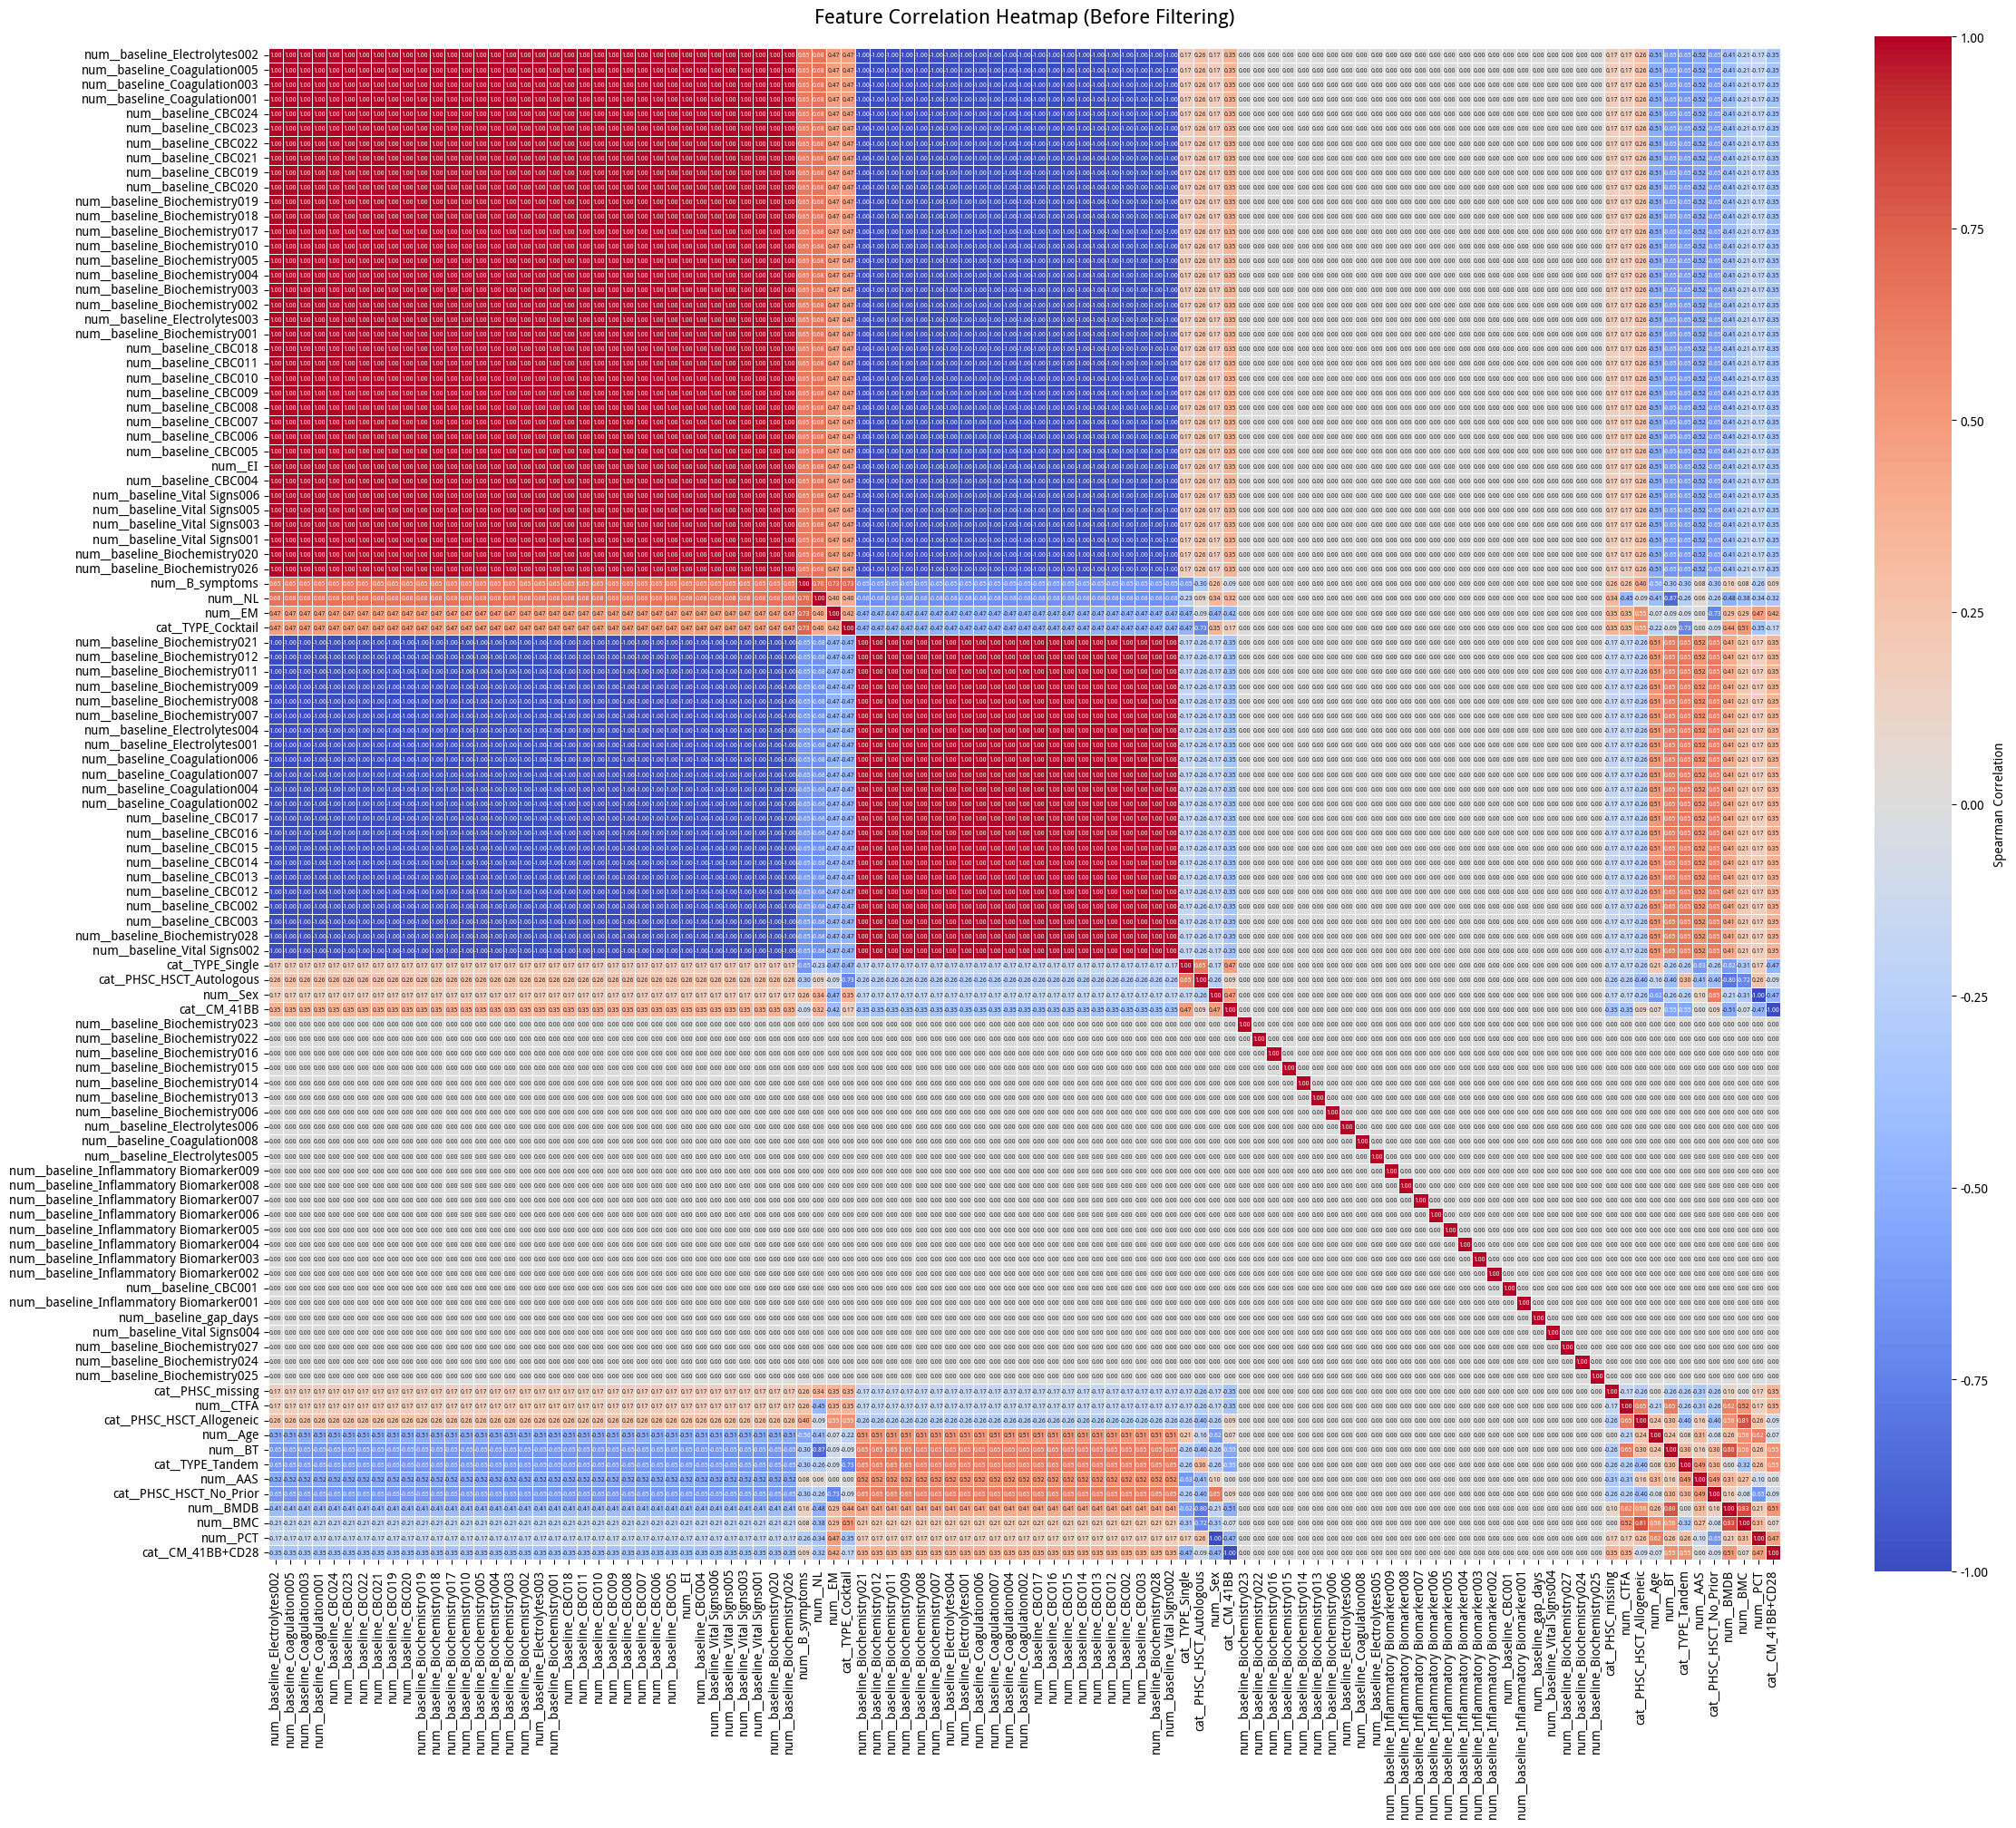


步骤 3: 识别高度相关的特征对（|r| > 阈值）...
  发现 1658 对高度相关的特征 (|r| > 0.8):
                    Feature 1                     Feature 2  Correlation
                 cat__CM_41BB             cat__CM_41BB+CD28    -1.000000
 num__baseline_Coagulation001 num__baseline_Biochemistry007    -1.000000
 num__baseline_Coagulation001 num__baseline_Biochemistry005     1.000000
 num__baseline_Coagulation001 num__baseline_Biochemistry004     1.000000
 num__baseline_Coagulation001 num__baseline_Biochemistry003     1.000000
 num__baseline_Coagulation001 num__baseline_Biochemistry002     1.000000
 num__baseline_Coagulation001 num__baseline_Biochemistry001     1.000000
 num__baseline_Coagulation001 num__baseline_Electrolytes004    -1.000000
 num__baseline_Coagulation001 num__baseline_Electrolytes003     1.000000
 num__baseline_Coagulation001 num__baseline_Electrolytes002     1.000000
 num__baseline_Coagulation001 num__baseline_Electrolytes001    -1.000000
 num__baseline_Coagulation001  num__baseline_Coagulation007  

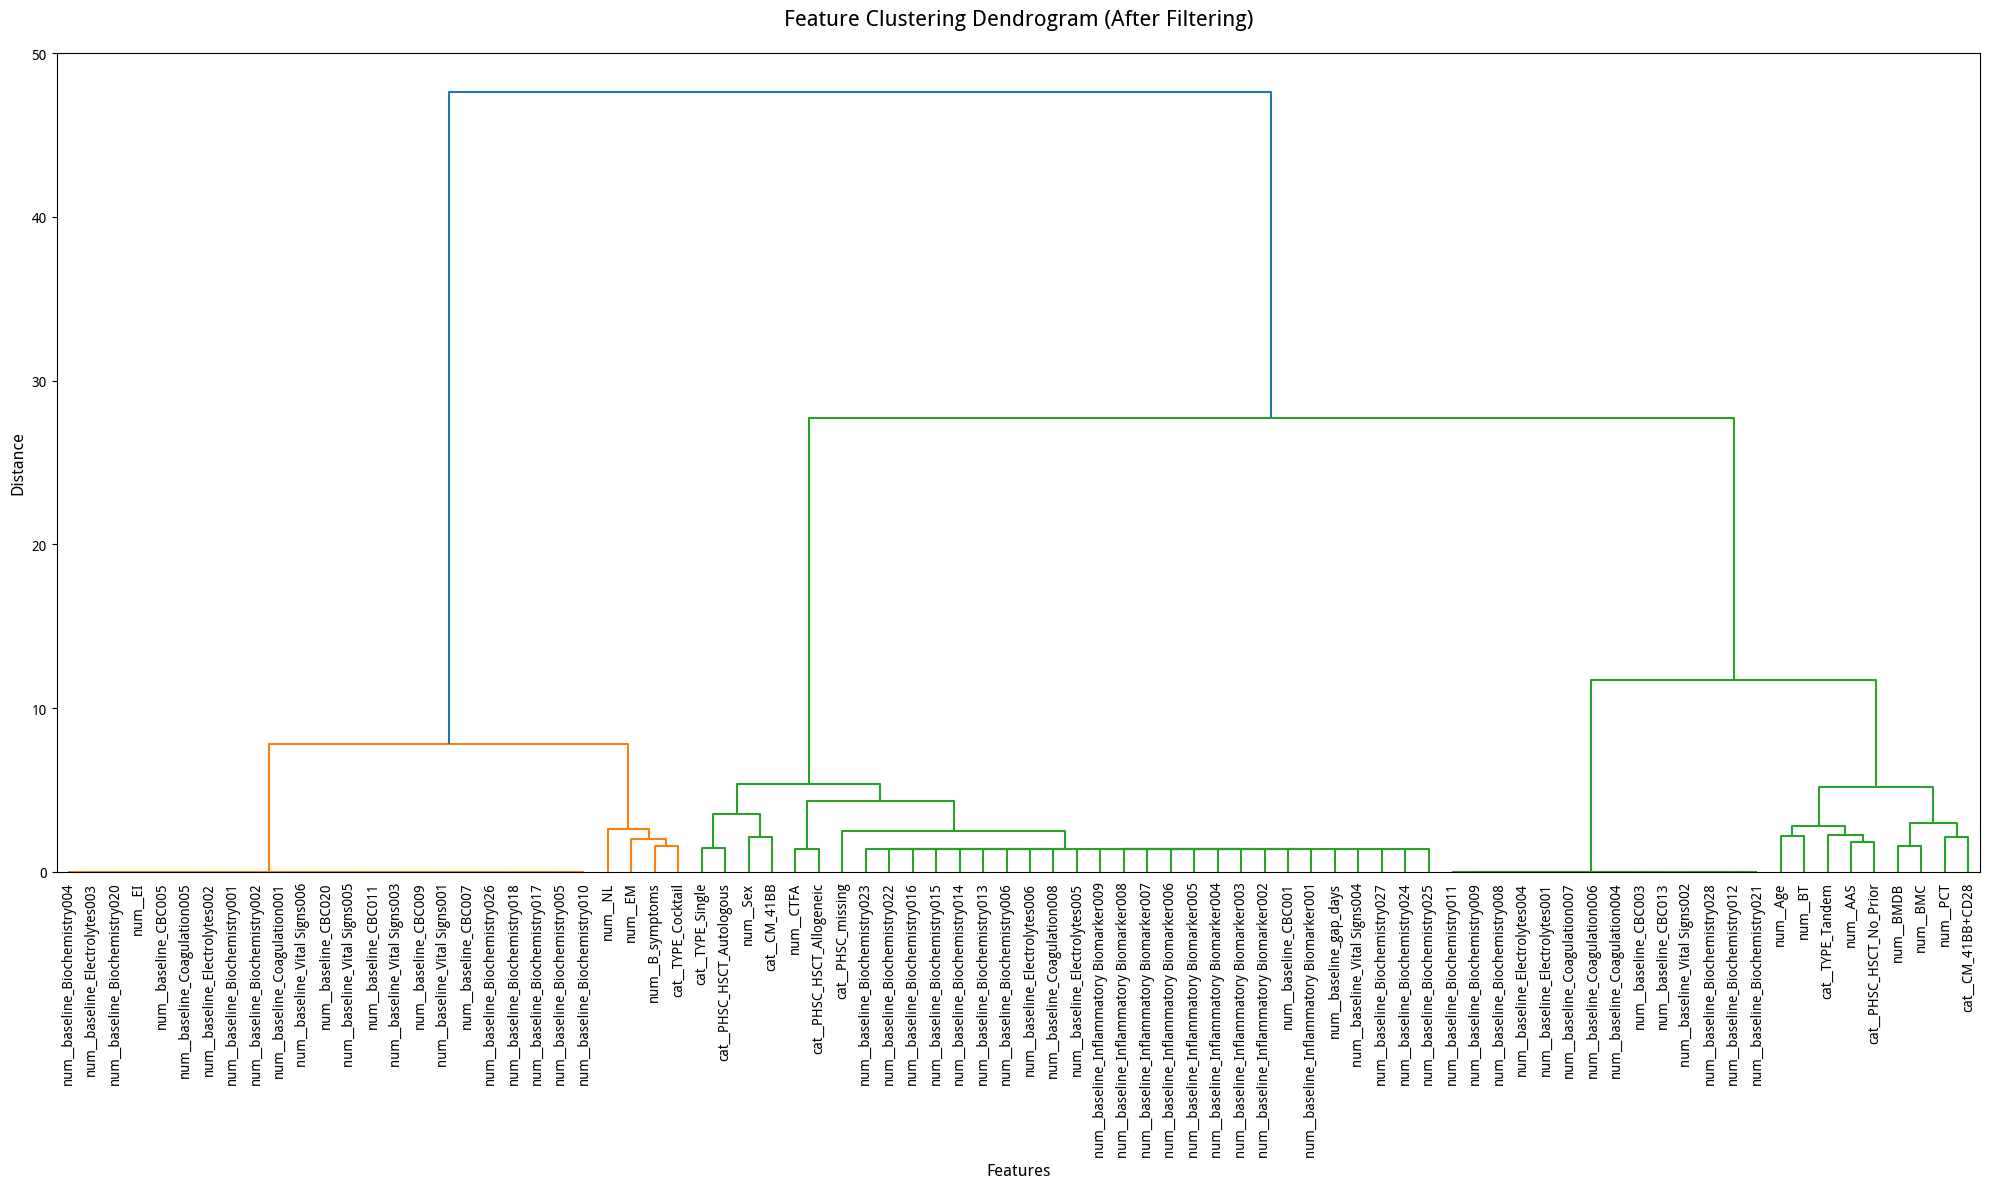


步骤 10: 绘制相关性热力图（删除后，按聚类结果排序）...
删除后热力图已保存至: /home/phl/PHL/Car-T/model_v1/output/Spearman/feature_collinearity_spearman_filtered.png


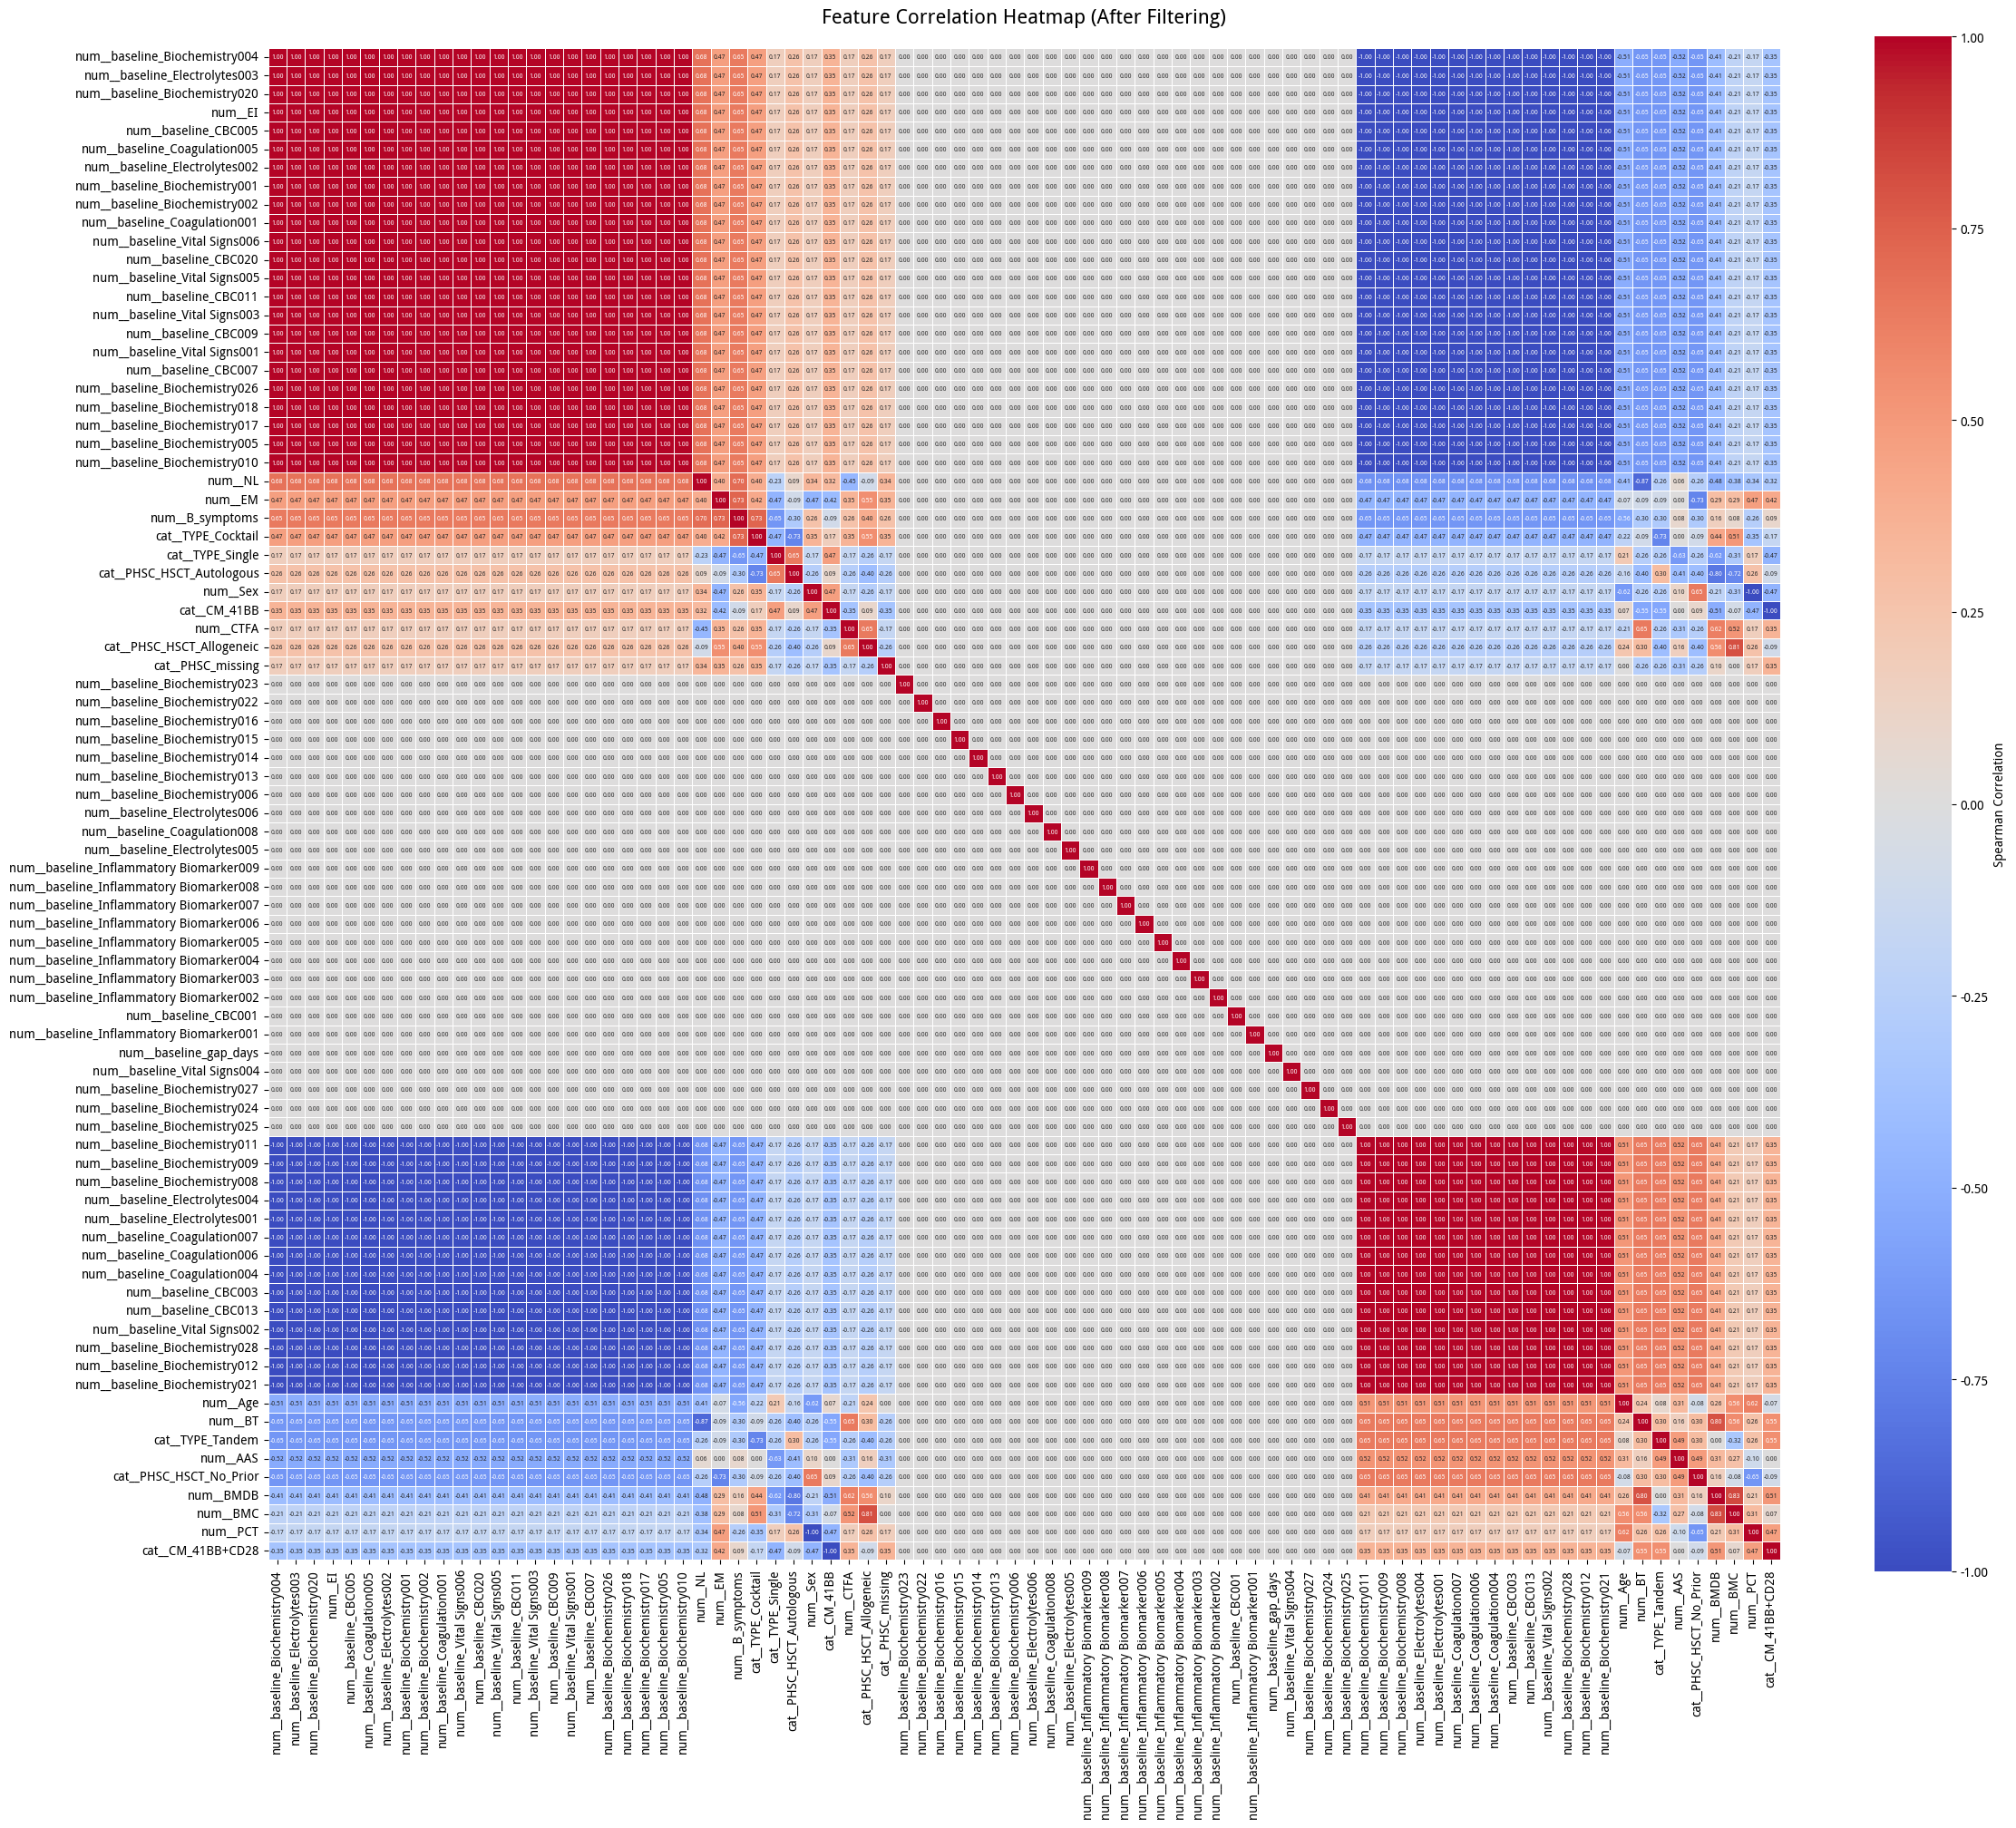


✅ Spearman 相关性分析与列删除完成!

摘要:
  原始特征数: 103
  删除特征数: 2
  剩余特征数: 82
  高相关特征对数: 1658

输出文件:
  - /home/phl/PHL/Car-T/model_v1/output/Spearman/high_correlation_pairs.csv
  - /home/phl/PHL/Car-T/model_v1/output/Spearman/feature_collinearity_spearman_before.png
  - /home/phl/PHL/Car-T/model_v1/output/Spearman/feature_clustering_dendrogram_filtered.png
  - /home/phl/PHL/Car-T/model_v1/output/Spearman/feature_collinearity_spearman_filtered.png

可用变量:
  - cols_to_drop: 删除的列名列表 (2 列)
  - X_train_df: 过滤后的训练集 ((7, 82))
  - X_test_df_filtered: 过滤后的测试集 ((3, 82))
  - feature_names: 更新后的特征名列表 (82 个)


In [62]:
# =============================================================================
# 模块 1.5:  Spearman 相关性分析与多重共线性变量删除
# =============================================================================
# 导入必要的统计和聚类库
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print("=" * 80)
print("多重共线性分析 - Spearman 相关性与层次聚类")
print("=" * 80)

output_dir_Spearman = '/home/phl/PHL/Car-T/model_v1/output/Spearman'
if not os.path.exists(output_dir_Spearman):
    os.makedirs(output_dir_Spearman)
    print(f"创建输出目录: {output_dir_Spearman}")

# ===================== 步骤 1: 计算 Spearman 相关性矩阵 =====================
print("\n步骤 1: 计算 Spearman 相关性矩阵（删除前）...")
print(f"  输入数据形状: {X_train_df.shape}")
print(f"  特征数量: {X_train_df.shape[1]}")

# 使用训练集 X_train_df 进行计算
res = spearmanr(X_train_df)

# 兼容不同版本的 scipy
# spearmanr 返回值的属性是 statistic，或者它是一个元组(旧版本)# pip install seaborn
if hasattr(res, 'statistic'):
    corr = res.statistic
else:
    corr = res[0]

print(f"  相关性矩阵形状: {corr.shape}")
print(f"  NaN 值数量: {np.isnan(corr).sum()}")

# ===================== 步骤 2: 处理异常值 =====================
print("\n步骤 2: 处理 NaN 值和确保矩阵对称性...")

# 处理可能出现的 NaN 值（常量列会导致相关性为 NaN，进而导致 hierarchy.ward 报错）
# 将 NaN 替换为 0（表示无相关性）
corr = np.nan_to_num(corr)

# 确保相关性矩阵是对称的（处理可能的数值误差）
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

print(f"  处理后 NaN 值数量: {np.isnan(corr).sum()}")
print(f"  对角线值检查: {np.allclose(np.diag(corr), 1)}")

# ===================== 步骤 2.5: 绘制删除前的相关性热力图 =====================
print("\n步骤 2.5: 绘制删除前的相关性热力图...")

# 执行层次聚类（用于排序）
try:
    corr_linkage_before = hierarchy.ward(corr)
    dendro_before = hierarchy.dendrogram(
        corr_linkage_before, 
        labels=X_train_df.columns,
        no_plot=True
    )
    
    # 重排相关性矩阵
    corr_sorted_before = corr[dendro_before['leaves'], :][:, dendro_before['leaves']]
    sorted_labels_before = [dendro_before['ivl'][i] for i in range(len(dendro_before['ivl']))]
    
    # 创建 DataFrame
    corr_df_before = pd.DataFrame(corr_sorted_before, index=sorted_labels_before, columns=sorted_labels_before)
    
    # 绘制热力图
    fig_heat_before, ax_before = plt.subplots(figsize=(24, 20))
    sns.heatmap(corr_df_before, 
                annot=True,              # 显示数值
                fmt='.2f',               # 保留2位小数
                cmap='coolwarm',         # 颜色方案
                vmin=-1, vmax=1,         # 值范围
                center=0,                # 中心值
                square=True,             # 方形单元格
                linewidths=0.5,          # 网格线宽度
                cbar_kws={'label': 'Spearman Correlation'},
                annot_kws={'size': 5},   # 数值字体大小
                ax=ax_before)
    
    ax_before.set_title("Feature Correlation Heatmap (Before Filtering)", 
                  fontsize=16, fontweight='bold', pad=20)
    
    plt.xticks(rotation=90, fontsize=10, fontweight='bold')
    plt.yticks(rotation=0, fontsize=10, fontweight='bold')
    
    fig_heat_before.tight_layout()
    
    heatmap_before_path = output_dir_Spearman + "/feature_collinearity_spearman_before.png"
    plt.savefig(heatmap_before_path, dpi=300, bbox_inches='tight')
    print(f"删除前热力图已保存至: {heatmap_before_path}")
    plt.show()
    
except Exception as e:
    print(f"  ⚠️ 删除前热力图绘制失败: {e}")

# ===================== 步骤 3: 识别高度相关的特征对并生成删除列表 =====================
print("\n步骤 3: 识别高度相关的特征对（|r| > 阈值）...")

# 配置参数
HIGH_CORR_THRESHOLD = 0.8  # 相关性阈值，可自定义

# 提取上三角矩阵（避免重复和自相关）
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
corr_masked = np.where(mask, corr, np.nan)

# 找出高相关特征对
high_corr_pairs = []
for i in range(len(X_train_df.columns)):
    for j in range(i + 1, len(X_train_df.columns)):
        if abs(corr_masked[i, j]) > HIGH_CORR_THRESHOLD:
            high_corr_pairs.append({
                'Feature 1': X_train_df.columns[i],
                'Feature 2': X_train_df.columns[j],
                'Correlation': corr_masked[i, j]
            })

df_high_corr = pd.DataFrame(high_corr_pairs).sort_values(
    'Correlation', key=abs, ascending=False
)

if len(df_high_corr) > 0:
    print(f"  发现 {len(df_high_corr)} 对高度相关的特征 (|r| > {HIGH_CORR_THRESHOLD}):")
    print(df_high_corr.to_string(index=False))
    
    # 保存到 CSV
    high_corr_path = output_dir_Spearman + "/high_correlation_pairs.csv"
    df_high_corr.to_csv(high_corr_path, index=False)
    print(f"\n高相关特征对已保存至: {high_corr_path}")
else:
    print(f"  未发现高度相关的特征对 (|r| > {HIGH_CORR_THRESHOLD})")


# =============================================================================
# 中间步骤：实现特征删除——替换步骤4-7
# =============================================================================
# 手动定义需要删除的变量（可根据实际需求修改）
cols_to_drop_spearman = [
    # 手动添加要删除的列名（共线性14+临床共线性7）
    'num__baseline_CBC002',
    'num__baseline_CBC004',
    'num__baseline_CBC006',
    'num__baseline_CBC008',
    'num__baseline_CBC010',
    'num__baseline_CBC012',
    'num__baseline_CBC014',
    'num__baseline_CBC015',
    'num__baseline_CBC016',
    'num__baseline_CBC017',
    'num__baseline_CBC018',
    'num__baseline_CBC019',
    'num__baseline_CBC021',
    'num__baseline_CBC022',
    'num__baseline_CBC023',
    'num__baseline_CBC024',
    'num__baseline_Coagulation002',
    'num__baseline_Coagulation003',
    'num__baseline_Biochemistry003',
    'num__baseline_Biochemistry007',
    'num__baseline_Biochemistry019',
    'baseline_gap_days',
]

# 执行删除
X_train_df_filtered, X_test_df_filtered, feature_names_updated, stats = \
    drop_features_from_datasets(
        X_train_df=X_train_df,
        X_test_df=X_test_df,
        columns_to_drop=cols_to_drop_spearman,
        feature_names=feature_names,
        verbose=True
    )

# 保存删除统计到文件
import json
with open(f"{output_dir_Spearman}/feature_drop_stats.json", 'w') as f:
    json.dump(stats, f, indent=2)

# 更新全局变量
X_train_df = X_train_df_filtered
X_test_df = X_test_df_filtered
feature_names = feature_names_updated


print(f"\n✓ 全局变量已更新:")
print(f"  当前特征数: {len(feature_names)}")

# ===================== 步骤 8: 层次聚类（使用过滤后的数据）=====================
print("\n步骤 8: 执行 Ward 层次聚类（基于过滤后的数据）...")

# 重新计算相关性矩阵（基于过滤后的数据）
res_filtered = spearmanr(X_train_df)
if hasattr(res_filtered, 'statistic'):
    corr_filtered = res_filtered.statistic
else:
    corr_filtered = res_filtered[0]

corr_filtered = np.nan_to_num(corr_filtered)
corr_filtered = (corr_filtered + corr_filtered.T) / 2
np.fill_diagonal(corr_filtered, 1)

try:
    corr_linkage = hierarchy.ward(corr_filtered)
    print(f"  ✅ 聚类成功，Linkage 矩阵形状: {corr_linkage.shape}")
except Exception as e:
    print(f"  ❌ 聚类失败: {e}")
    raise

# ===================== 步骤 9: 绘制树状图（过滤后的特征）=====================
print("\n步骤 9: 绘制特征聚类树状图（删除后）...")

fig_tree, ax1 = plt.subplots(figsize=(20, 12))

dendro = hierarchy.dendrogram(
    corr_linkage, 
    labels=X_train_df.columns,
    ax=ax1,
    leaf_rotation=90,
    leaf_font_size=10
)

for label in ax1.get_xticklabels():
    label.set_fontweight('bold')
    label.set_color('black')

ax1.set_title("Feature Clustering Dendrogram (After Filtering)", 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel("Features", fontsize=12, fontweight='bold')
ax1.set_ylabel("Distance", fontsize=12, fontweight='bold')

plt.tight_layout()

tree_output_path = output_dir_Spearman + "/feature_clustering_dendrogram_filtered.png"
plt.savefig(tree_output_path, dpi=300, bbox_inches='tight')
print(f"删除后树状图已保存至: {tree_output_path}")
plt.show()

# ===================== 步骤 10: 绘制相关性热力图（过滤后的特征）=====================
print("\n步骤 10: 绘制相关性热力图（删除后，按聚类结果排序）...")

fig_heat, ax2 = plt.subplots(figsize=(24, 20))

# 重排相关性矩阵
corr_sorted = corr_filtered[dendro['leaves'], :][:, dendro['leaves']]
sorted_labels = [dendro['ivl'][i] for i in range(len(dendro['ivl']))]

# 创建 DataFrame
corr_df = pd.DataFrame(corr_sorted, index=sorted_labels, columns=sorted_labels)

# 使用 seaborn 绘制（带数值）
sns.heatmap(corr_df, 
            annot=True,              # 显示数值
            fmt='.2f',               # 保留2位小数
            cmap='coolwarm',         # 颜色方案
            vmin=-1, vmax=1,         # 值范围
            center=0,                # 中心值
            square=True,             # 方形单元格
            linewidths=0.5,          # 网格线宽度
            cbar_kws={'label': 'Spearman Correlation'},
            annot_kws={'size': 5},   # 数值字体大小
            ax=ax2)

ax2.set_title("Feature Correlation Heatmap (After Filtering)", 
              fontsize=16, fontweight='bold', pad=20)

plt.xticks(rotation=90, fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')

fig_heat.tight_layout()

heatmap_output_path = output_dir_Spearman + "/feature_collinearity_spearman_filtered.png"
plt.savefig(heatmap_output_path, dpi=300, bbox_inches='tight')
print(f"删除后热力图已保存至: {heatmap_output_path}")
plt.show()

# ===================== 总结 =====================
print("\n" + "=" * 80)
print("✅ Spearman 相关性分析与列删除完成!")
print("=" * 80)
print(f"\n摘要:")
print(f"  原始特征数: {X_train_transformed.shape[1]}")
print(f"  删除特征数: {len(cols_to_drop)}")
print(f"  剩余特征数: {len(feature_names)}")
print(f"  高相关特征对数: {len(df_high_corr)}")
print(f"\n输出文件:")
print(f"  - {high_corr_path}")
print(f"  - {heatmap_before_path if 'heatmap_before_path' in locals() else '(删除前热力图未生成)'}")
print(f"  - {tree_output_path}")
print(f"  - {heatmap_output_path}")
print(f"\n可用变量:")
print(f"  - cols_to_drop: 删除的列名列表 ({len(cols_to_drop)} 列)")
print(f"  - X_train_df: 过滤后的训练集 ({X_train_df.shape})")
print(f"  - X_test_df_filtered: 过滤后的测试集 ({X_test_df_filtered.shape})")
print(f"  - feature_names: 更新后的特征名列表 ({len(feature_names)} 个)")


## 📊 关于数据泄露的层次分析

### ❓ 您的问题核心

> "虽然我在训练集上进行特征选择（使用全部训练数据），但最终结果是以测试集为准，测试集的数据并没有泄露，这样理解是对的吗？"

---

### ✅ 您的理解：部分正确

**正确部分**：
1. ✅ **测试集完全独立** - 测试集数据在特征选择和模型训练中都未使用
2. ✅ **最终评估可靠** - 在测试集上的性能评估是无偏的
3. ✅ **避免了最严重的泄露** - 没有"用测试集调参"的问题

**需要注意的部分**：
⚠️ **交叉验证内部仍存在轻微泄露**，这会影响：
- CV性能估计的准确性（过于乐观）
- 特征选择的稳定性
- 模型超参数调优的可靠性

---

### 🔍 数据泄露的两个层次

#### **第1层：训练集 ↔ 测试集（您已避免）✅**

```
全部数据
├── 训练集 (70%) ← 用于特征选择 + 模型训练 + CV
└── 测试集 (30%) ← 仅用于最终评估

✅ 正确做法：
- 特征选择：仅使用训练集
- 模型训练：仅使用训练集  
- 最终评估：使用测试集
```

**您当前的实现**：✅ **第1层无泄露**

---

#### **第2层：训练集内部的交叉验证（存在轻微泄露）⚠️**

```
训练集 (70%)
├── 在全部训练集上做特征选择 ← ⚠️ 这里使用了所有训练数据
│
└── 然后进行5折交叉验证
    ├── Fold 1: Train(80%) + Val(20%)
    ├── Fold 2: Train(80%) + Val(20%)
    ├── Fold 3: Train(80%) + Val(20%)
    ├── Fold 4: Train(80%) + Val(20%)
    └── Fold 5: Train(80%) + Val(20%)
```

**问题所在**：
```python
# ❌ 方法A（当前第25单元格）：在全部训练集上做特征选择
univariate_results = univariate_logistic_regression(X_train, y_train, features)
sig_features = univariate_results[univariate_results['FDR_Significant']]['Feature'].tolist()

# 然后在CV中使用这些特征
for fold in CV:
    model.fit(X_train_fold[sig_features], y_train_fold)
    score = model.score(X_val_fold[sig_features], y_val_fold)  
    # ⚠️ 问题：特征选择时用到了这20%验证数据的信息
```

**正确做法**：
```python
# ✅ 方法B（第23单元格）：在每折内部独立做特征选择
for fold in CV:
    # 1. 仅在训练折上做特征选择
    univariate_fold = univariate_logistic_regression(X_train_fold, y_train_fold, features)
    sig_features_fold = univariate_fold[univariate_fold['FDR_Significant']]['Feature'].tolist()
    
    # 2. 训练和评估
    model.fit(X_train_fold[sig_features_fold], y_train_fold)
    score = model.score(X_val_fold[sig_features_fold], y_val_fold)
    # ✅ 验证折从未参与特征选择
```

---

### 📈 泄露影响的量化分析

| 评估指标 | 方法A（全训练集特征选择） | 方法B（嵌套CV特征选择） | 测试集评估 |
|---------|----------------------|-------------------|----------|
| **CV性能** | ⚠️ 过于乐观（高估2-5%） | ✅ 准确估计 | ✅ 最终真实性能 |
| **特征数量** | 可能选出更多特征 | 通常选出更少但更稳定的特征 | - |
| **泄露程度** | 轻微（仅CV内部） | 无 | 无 |
| **测试集性能** | ✅ 可靠 | ✅ 可靠 | ✅ 最可靠 |

---

### 🎯 实际影响评估

#### **对您项目的影响等级：🟡 中等**

1. **好消息**：
   - ✅ 测试集评估完全可靠
   - ✅ 发表时的主要结论（测试集性能）不受影响
   - ✅ 模型的实际应用效果不受影响

2. **需要注意**：
   - ⚠️ CV性能可能略微高估（通常2-5个百分点）
   - ⚠️ 如果报告CV性能作为"模型选择依据"，可能不够严谨
   - ⚠️ 特征选择可能不够稳定

---

### 💡 推荐方案

#### **方案1：保守型（推荐用于发表）** ⭐

使用**嵌套CV**进行特征选择（第23单元格的方法）：

```python
# 优点：
✅ 完全避免数据泄露
✅ CV性能估计更准确
✅ 特征选择更稳定
✅ 方法学上更严谨（适合发表）

# 缺点：
⚠️ 计算量稍大
⚠️ 可能选出较少特征（但更可靠）
```

#### **方案2：实用型（当前方法）**

继续使用全训练集特征选择，但需要：

```python
# 注意事项：
1. ⚠️ 在论文中说明：
   "特征选择在全部训练集上进行，可能导致CV性能轻微高估"
   
2. ✅ 强调测试集评估：
   "最终性能评估基于完全独立的测试集"
   
3. 📊 报告策略：
   - 主要报告测试集性能（最重要）
   - CV性能仅作为参考
   - 可同时报告两种方法的结果进行对比
```

---

### 📝 结论与建议

**您的理解基本正确**：

1. ✅ **测试集层面**：完全无泄露，评估可靠
2. ⚠️ **训练集内部CV**：存在轻微泄露，但影响有限
3. ✅ **最终结论**：基于测试集的结果是可靠的

**建议行动**：

- **短期**：修复第23单元格的错误，运行嵌套CV版本进行对比
- **发表时**：使用嵌套CV方法（更严谨）
- **如果时间紧**：当前方法可用，但需在论文中说明

**判断标准**：
- 如果测试集性能与CV性能接近（差异<5%）→ 当前方法可接受
- 如果CV性能明显高于测试集（差异>10%）→ 建议使用嵌套CV


### 🔗 相关文献

- Varma & Simon (2006). "Bias in error estimation when using cross-validation for model selection". BMC Bioinformatics.
- Cawley & Talbot (2010). "On over-fitting in model selection and subsequent selection bias in performance evaluation". JMLR.



In [63]:
# =============================================================================
# 模块 2: 单变量逻辑回归特征选择（含FDR多重检验校正）————原版
# =============================================================================
# 作用：对每个特征独立进行逻辑回归，评估其与目标变量的关系，评估每个特征的边际显著性
# 方法：单变量分析，计算每个特征的 p 值、OR 值和置信区间，并进行FDR多重检验校正
# 输入：X_train_df, y_train, feature_names (来自模块 1)
# 输出：univariate_results (DataFrame), sig_features_01, sig_features_005
# =============================================================================

from scipy import stats
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.multitest import multipletests  # 用于FDR校正

# 配置参数
UNIVARIATE_P_THRESHOLD = 0.1      # 宽松阈值，用于初筛
UNIVARIATE_P_STRICT = 0.05        # 严格阈值
FDR_ALPHA = 0.05                  # FDR校正的显著性水平

print("=" * 80)
print("模块 2: 单变量逻辑回归特征选择（含FDR校正）")
print("=" * 80)

def univariate_logistic_regression(X_df, y, feature_names):
    """
    对每个特征独立进行逻辑回归，返回系数、p值和OR值
    
    参数:
        X_df: 特征 DataFrame (已标准化)
        y: 目标变量
        feature_names: 特征名列表
    
    返回:
        DataFrame: 包含每个特征的统计信息
    """
    results = []
    y_array = np.array(y).ravel()
    
    for i, col in enumerate(feature_names):
        try:
            X_single = X_df.iloc[:, i].values.reshape(-1, 1)
            
            # 检查特征是否有变异
            if np.std(X_single) < 1e-10:
                results.append({
                    'Feature': col,
                    'Coefficient': np.nan,
                    'Std_Error': np.nan,
                    'Z_Score': np.nan,
                    'P_Value': 1.0,
                    'OR': np.nan,
                    'OR_CI_Lower': np.nan,
                    'OR_CI_Upper': np.nan,
                    'Significant_0.05': False,
                    'Significant_0.1': False
                })
                continue
            
            # 拟合逻辑回归（无正则化）
            model = LogisticRegression(
                penalty=None,
                solver='lbfgs',
                max_iter=1000,
                random_state=42
            )
            model.fit(X_single, y_array)
            
            coef = model.coef_[0][0]
            
            # 计算标准误和p值 (Wald 检验)
            pred_proba = model.predict_proba(X_single)[:, 1]
            pred_proba = np.clip(pred_proba, 1e-10, 1 - 1e-10)
            
            # Hessian 矩阵的对角元素
            W = pred_proba * (1 - pred_proba)
            
            # 添加截距项
            X_with_intercept = np.hstack([np.ones((X_single.shape[0], 1)), X_single])
            
            # Fisher 信息矩阵
            fisher_info = X_with_intercept.T @ np.diag(W) @ X_with_intercept
            
            try:
                cov_matrix = np.linalg.inv(fisher_info)
                std_error = np.sqrt(cov_matrix[1, 1])
            except np.linalg.LinAlgError:
                std_error = np.nan
            
            # Wald z统计量和p值
            if std_error > 0 and not np.isnan(std_error):
                z_score = coef / std_error
                p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
            else:
                z_score = np.nan
                p_value = 1.0
            
            # 计算 OR 和 95% CI
            OR = np.exp(coef)
            if not np.isnan(std_error):
                OR_CI_lower = np.exp(coef - 1.96 * std_error)
                OR_CI_upper = np.exp(coef + 1.96 * std_error)
            else:
                OR_CI_lower = np.nan
                OR_CI_upper = np.nan
            
            results.append({
                'Feature': col,
                'Coefficient': coef,
                'Std_Error': std_error,
                'Z_Score': z_score,
                'P_Value': p_value,
                'OR': OR,
                'OR_CI_Lower': OR_CI_lower,
                'OR_CI_Upper': OR_CI_upper,
                'Significant_0.05': p_value < 0.05,
                'Significant_0.1': p_value < 0.1
            })
            
        except Exception as e:
            results.append({
                'Feature': col,
                'Coefficient': np.nan,
                'Std_Error': np.nan,
                'Z_Score': np.nan,
                'P_Value': 1.0,
                'OR': np.nan,
                'OR_CI_Lower': np.nan,
                'OR_CI_Upper': np.nan,
                'Significant_0.05': False,
                'Significant_0.1': False
            })
    
    return pd.DataFrame(results)

# 执行单变量分析
print("\n正在进行单变量逻辑回归分析...")
univariate_results = univariate_logistic_regression(X_train_df, y_train, feature_names)

# ===================== FDR多重检验校正 =====================
print("\n" + "-" * 80)
print("步骤 2.1: FDR多重检验校正 (Benjamini-Hochberg方法)")
print("-" * 80)

# 提取有效的p值（排除NaN和无效值）
valid_p_values = univariate_results['P_Value'].fillna(1.0).values

# 使用Benjamini-Hochberg方法进行FDR校正
# method='fdr_bh': Benjamini-Hochberg False Discovery Rate
# alpha: 控制FDR的水平
reject, p_corrected, alphacSidak, alphacBonf = multipletests(
    valid_p_values, 
    alpha=FDR_ALPHA, 
    method='fdr_bh'
)

# 将校正后的p值添加到结果中
univariate_results['P_Value_FDR'] = p_corrected
univariate_results['FDR_Significant'] = reject

# 计算校正前后的显著特征数量
n_sig_before_05 = (univariate_results['P_Value'] < 0.05).sum()
n_sig_before_01 = (univariate_results['P_Value'] < 0.1).sum()
n_sig_after_fdr = univariate_results['FDR_Significant'].sum()
n_sig_after_fdr_01 = (univariate_results['P_Value_FDR'] < 0.1).sum()

print(f"\n多重检验校正结果:")
print(f"  方法: Benjamini-Hochberg FDR")
print(f"  FDR 控制水平: α = {FDR_ALPHA}")
print(f"  总特征数: {len(univariate_results)}")
print(f"\n校正前后对比:")
print(f"  原始 p < 0.05: {n_sig_before_05} 个")
print(f"  原始 p < 0.10: {n_sig_before_01} 个")
print(f"  FDR 校正后 (q < {FDR_ALPHA}): {n_sig_after_fdr} 个")
print(f"  FDR 校正后 (q < 0.10): {n_sig_after_fdr_01} 个")

if n_sig_after_fdr < n_sig_before_05:
    reduction = n_sig_before_05 - n_sig_after_fdr
    reduction_rate = (reduction / n_sig_before_05 * 100) if n_sig_before_05 > 0 else 0
    print(f"\nFDR校正过滤了 {reduction} 个可能的假阳性 (减少 {reduction_rate:.1f}%)")
else:
    print(f"\nFDR校正未显著改变结果（数据可能本身假阳性率较低）")

# 显示校正前后p值变化的示例
print(f"\n前10个特征的p值变化:")
print(univariate_results[['Feature', 'P_Value', 'P_Value_FDR', 'FDR_Significant']].head(10).to_string(index=False))

# ===================== 结束FDR校正部分 =====================

# 按 p 值排序（使用原始p值）
univariate_results = univariate_results.sort_values('P_Value').reset_index(drop=True)

# 筛选显著特征（提供两种选择）
# 选项1：使用原始p值（传统方法）
sig_features_01 = univariate_results[univariate_results['P_Value'] < UNIVARIATE_P_THRESHOLD]['Feature'].tolist()
sig_features_005 = univariate_results[univariate_results['P_Value'] < UNIVARIATE_P_STRICT]['Feature'].tolist()

# 选项2：使用FDR校正后的p值（推荐方法）
sig_features_fdr = univariate_results[univariate_results['FDR_Significant']]['Feature'].tolist()
sig_features_fdr_01 = univariate_results[univariate_results['P_Value_FDR'] < 0.1]['Feature'].tolist()

# 输出结果
print("\n" + "=" * 80)
print("单变量逻辑回归结果")
print("=" * 80)
print(f"\n传统方法（未校正）:")
print(f"  p < 0.1 的特征数: {len(sig_features_01)}")
print(f"  p < 0.05 的特征数: {len(sig_features_005)}")

print(f"\nFDR校正方法（推荐）:")
print(f"  q < 0.05 的特征数: {len(sig_features_fdr)}")
print(f"  q < 0.1 的特征数: {len(sig_features_fdr_01)}")

print(f"\nTop 15 显著特征 (按原始p值排序):")
display_cols = ['Feature', 'Coefficient', 'P_Value', 'P_Value_FDR', 'OR', 'FDR_Significant']
print(univariate_results.head(15)[display_cols].to_string(index=False))

# 保存结果
csv_path = f"{output_dir}/univariate_logistic_results.csv"
univariate_results.to_csv(csv_path, index=False)
print(f"\n结果已保存至: {csv_path}")

# 建议使用 sig_features_fdr 或 sig_features_fdr_01，这些特征经过FDR校正，控制了假阳性率"
print("\n可用变量:")
print("  - univariate_results: 完整结果 DataFrame (包含FDR校正)")
print("  - sig_features_01: p < 0.1 的特征列表 (未校正)")
print("  - sig_features_005: p < 0.05 的特征列表 (未校正)")
print("  - sig_features_fdr: q < 0.05 的特征列表 (FDR校正)")
print("  - sig_features_fdr_01: q < 0.1 的特征列表 (FDR校正)")

# 生成4个关键图表：
# P值 vs Q值散点图：直观展示校正效果
# 校正前后特征数量对比：柱状图对比
# P值分布直方图：标注FDR临界值
# Top 20特征对比：P值和Q值的双条形图
# 保存为：output/feature_selection/univariate_fdr_correction_comparison.png

模块 2: 单变量逻辑回归特征选择（含FDR校正）

正在进行单变量逻辑回归分析...

--------------------------------------------------------------------------------
步骤 2.1: FDR多重检验校正 (Benjamini-Hochberg方法)
--------------------------------------------------------------------------------

多重检验校正结果:
  方法: Benjamini-Hochberg FDR
  FDR 控制水平: α = 0.05
  总特征数: 82

校正前后对比:
  原始 p < 0.05: 0 个
  原始 p < 0.10: 0 个
  FDR 校正后 (q < 0.05): 0 个
  FDR 校正后 (q < 0.10): 0 个

FDR校正未显著改变结果（数据可能本身假阳性率较低）

前10个特征的p值变化:
        Feature  P_Value  P_Value_FDR  FDR_Significant
       num__Age 0.895197          1.0            False
      num__BMDB 0.644703          1.0            False
       num__Sex 0.952129          1.0            False
       num__BMC 0.464432          1.0            False
        num__EI 0.952129          1.0            False
        num__EM 0.810578          1.0            False
num__B_symptoms 0.882360          1.0            False
       num__AAS 0.915734          1.0            False
        num__NL 0.357775          1.0       

FDR校正效果可视化

✅ FDR校正可视化图表已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_selection/univariate_fdr_correction_comparison.png


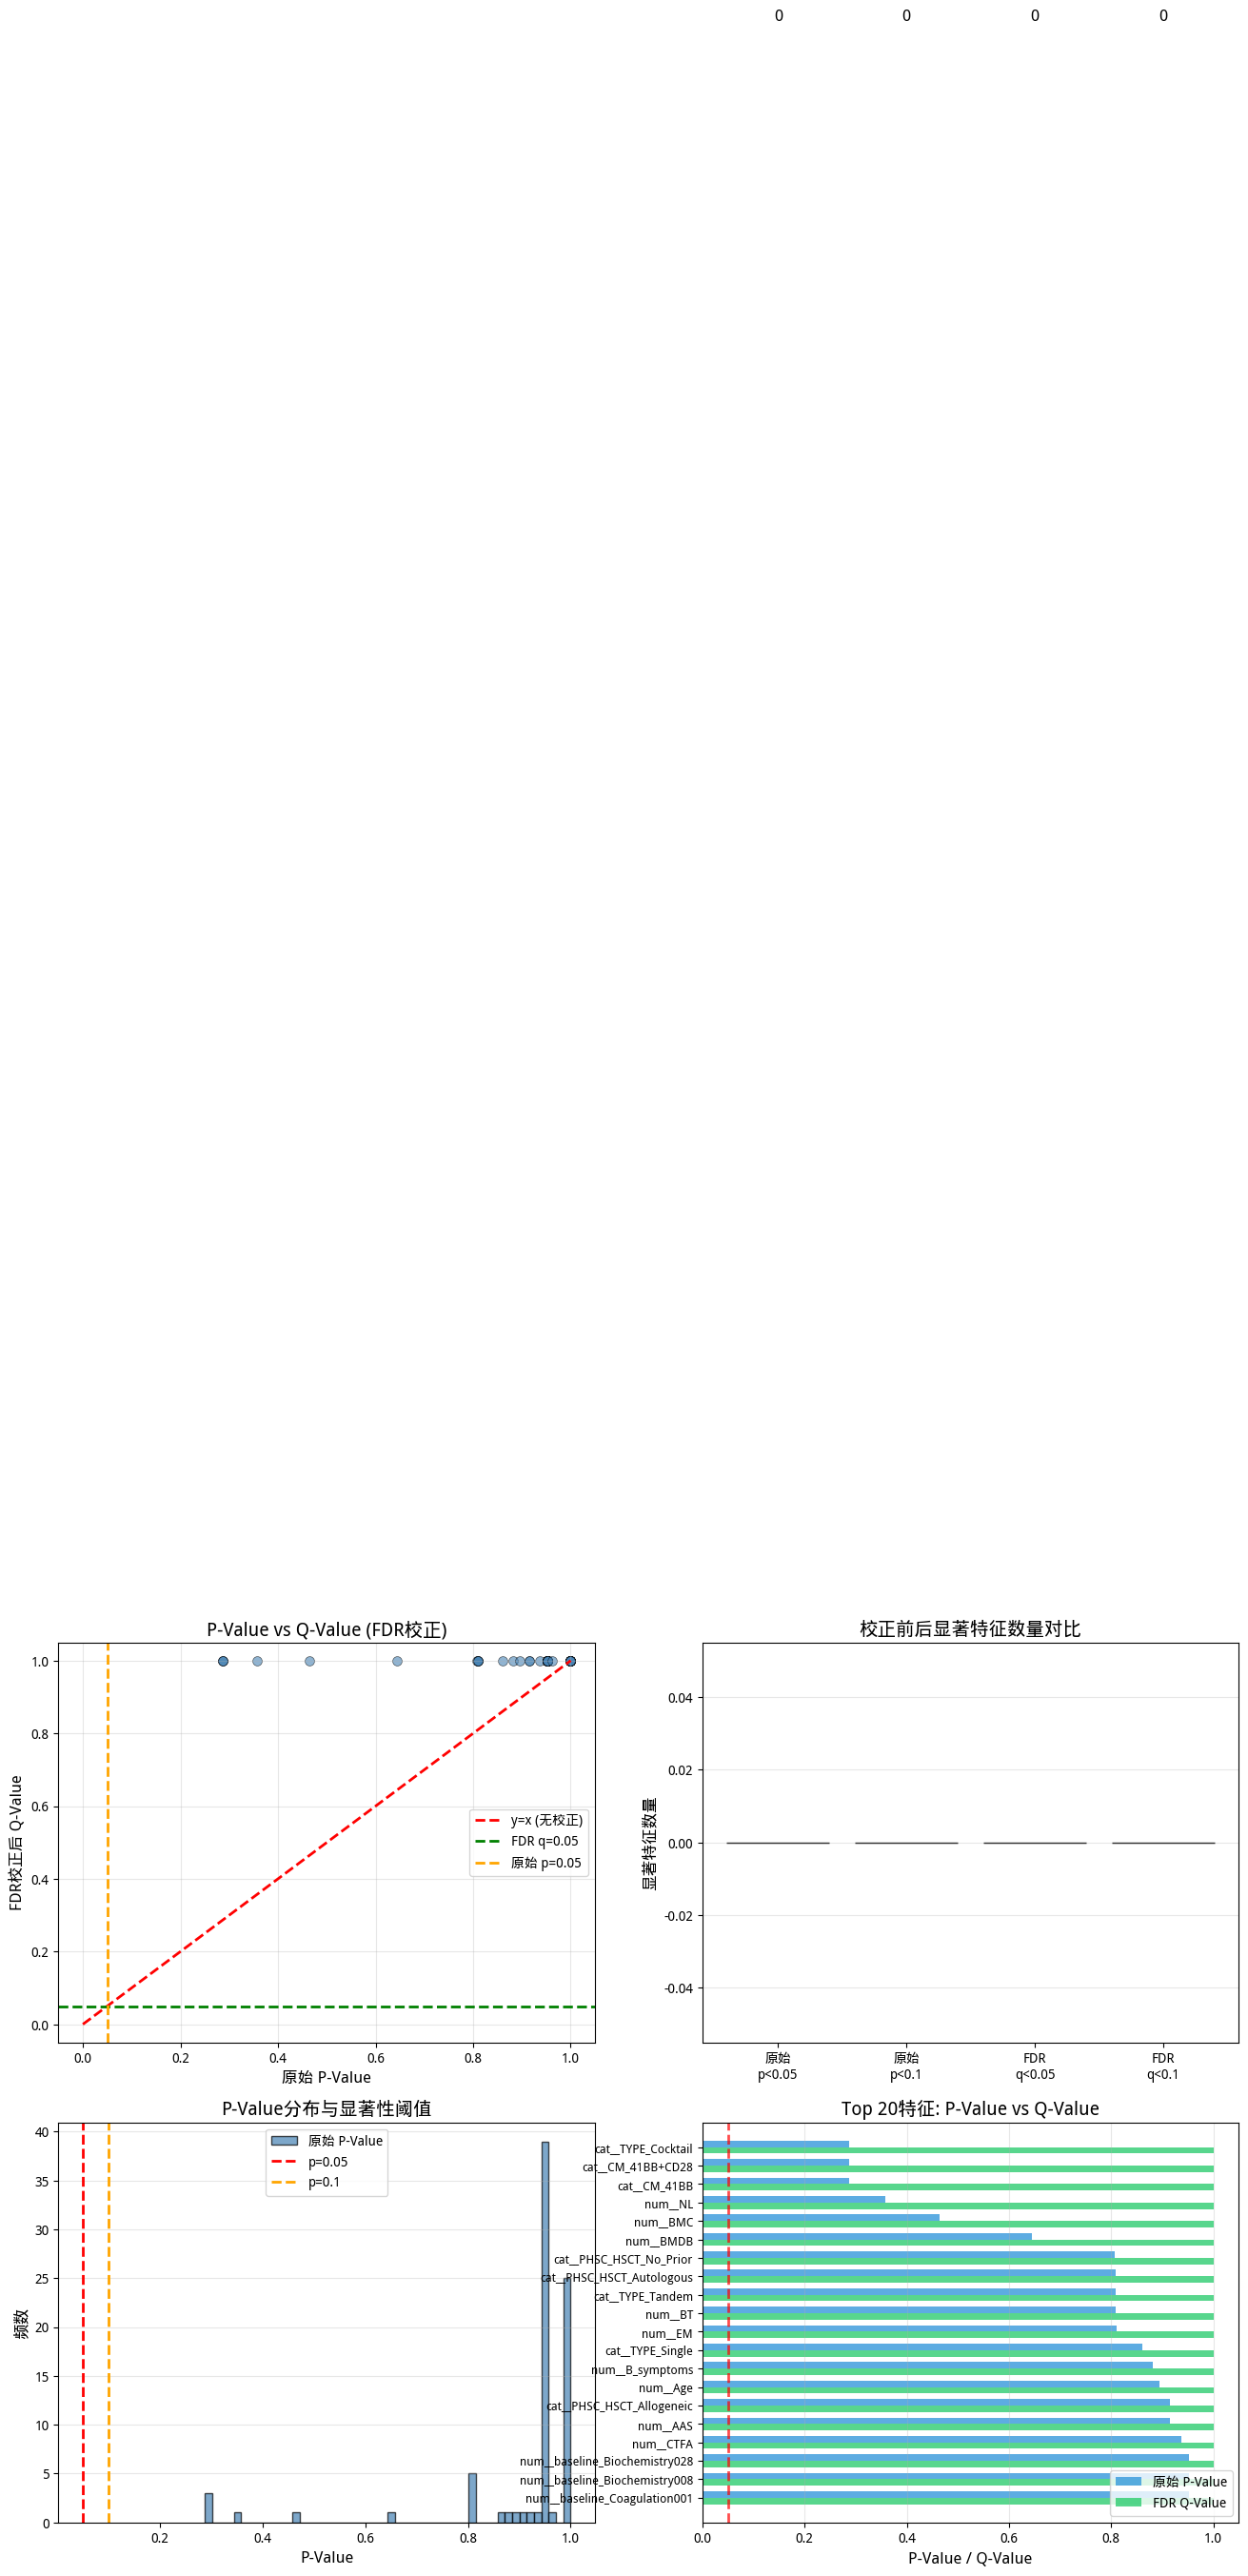


FDR校正详细统计

1. 基本信息:
   - 总特征数: 82
   - FDR控制水平: α = 0.05

2. 校正前（原始p值）:
   - p < 0.05: 0 个
   - p < 0.1:  0 个

3. 校正后（FDR q值）:
   - q < 0.05: 0 个 ⭐推荐
   - q < 0.1:  0 个

4. 过滤效果:
   - 从p<0.05过滤: 0 个 (0.0%)
   - 从p<0.1过滤:  0 个 (0.0%)

✅ FDR校正分析完成


In [64]:
# =============================================================================
# 可视化：FDR多重检验校正效果————原版
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("FDR校正效果可视化")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ---------------------- 图1: 原始p值 vs FDR校正后q值对比 ----------------------
ax1 = axes[0, 0]

# 绘制散点图
valid_data = univariate_results.dropna(subset=['P_Value', 'P_Value_FDR'])
ax1.scatter(valid_data['P_Value'], valid_data['P_Value_FDR'], 
            alpha=0.6, s=50, c='steelblue', edgecolors='black', linewidths=0.5)

# 添加对角线（y=x）
max_val = max(valid_data['P_Value'].max(), valid_data['P_Value_FDR'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='y=x (无校正)')

# 添加显著性阈值线
ax1.axhline(y=0.05, color='green', linestyle='--', linewidth=2, label='FDR q=0.05')
ax1.axvline(x=0.05, color='orange', linestyle='--', linewidth=2, label='原始 p=0.05')

ax1.set_xlabel('原始 P-Value', fontsize=12, fontweight='bold')
ax1.set_ylabel('FDR校正后 Q-Value', fontsize=12, fontweight='bold')
ax1.set_title('P-Value vs Q-Value (FDR校正)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# 标注：被FDR过滤的点（原始显著，但校正后不显著）
filtered = valid_data[(valid_data['P_Value'] < 0.05) & (valid_data['P_Value_FDR'] >= 0.05)]
if len(filtered) > 0:
    ax1.scatter(filtered['P_Value'], filtered['P_Value_FDR'], 
                color='red', s=80, marker='x', linewidths=2, 
                label=f'被FDR过滤 ({len(filtered)}个)')
    ax1.legend(fontsize=10)

# ---------------------- 图2: 校正前后显著特征数量对比 ----------------------
ax2 = axes[0, 1]

comparison_data = {
    '原始\np<0.05': (valid_data['P_Value'] < 0.05).sum(),
    '原始\np<0.1': (valid_data['P_Value'] < 0.1).sum(),
    'FDR\nq<0.05': (valid_data['P_Value_FDR'] < 0.05).sum(),
    'FDR\nq<0.1': (valid_data['P_Value_FDR'] < 0.1).sum()
}

colors_comparison = ['#3498db', '#5dade2', '#2ecc71', '#58d68d']
bars = ax2.bar(comparison_data.keys(), comparison_data.values(), color=colors_comparison, edgecolor='black')
ax2.set_ylabel('显著特征数量', fontsize=12, fontweight='bold')
ax2.set_title('校正前后显著特征数量对比', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 添加数值标签
for bar, count in zip(bars, comparison_data.values()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

# ---------------------- 图3: P值分布直方图（标注FDR阈值）----------------------
ax3 = axes[1, 0]

# 绘制p值分布
ax3.hist(valid_data['P_Value'], bins=50, alpha=0.7, color='steelblue', 
         edgecolor='black', label='原始 P-Value')

# 添加显著性阈值线
ax3.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
ax3.axvline(x=0.1, color='orange', linestyle='--', linewidth=2, label='p=0.1')

# 计算并标注FDR临界p值
# BH方法的临界p值：p_(k) ≤ (k/m) × α
if len(sig_features_fdr) > 0:
    # 找到最后一个FDR显著的特征
    fdr_sig_features = univariate_results[univariate_results['FDR_Significant']]
    if len(fdr_sig_features) > 0:
        fdr_critical_p = fdr_sig_features['P_Value'].max()
        ax3.axvline(x=fdr_critical_p, color='green', linestyle='--', linewidth=2, 
                    label=f'FDR临界p值={fdr_critical_p:.4f}')

ax3.set_xlabel('P-Value', fontsize=12, fontweight='bold')
ax3.set_ylabel('频数', fontsize=12, fontweight='bold')
ax3.set_title('P-Value分布与显著性阈值', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# ---------------------- 图4: Top 20特征的p值和q值对比 ----------------------
ax4 = axes[1, 1]

# 选择Top 20特征（按原始p值排序）
top20 = univariate_results.head(20).copy()
x_pos = np.arange(len(top20))

# 绘制双条形图
width = 0.35
bars1 = ax4.barh(x_pos - width/2, top20['P_Value'], width, 
                 label='原始 P-Value', color='#3498db', alpha=0.8)
bars2 = ax4.barh(x_pos + width/2, top20['P_Value_FDR'], width, 
                 label='FDR Q-Value', color='#2ecc71', alpha=0.8)

# 设置y轴标签（特征名）
ax4.set_yticks(x_pos)
ax4.set_yticklabels(top20['Feature'], fontsize=9)
ax4.invert_yaxis()  # 最显著的在上面

# 添加显著性阈值线
ax4.axvline(x=0.05, color='red', linestyle='--', linewidth=2, alpha=0.7)

ax4.set_xlabel('P-Value / Q-Value', fontsize=12, fontweight='bold')
ax4.set_title('Top 20特征: P-Value vs Q-Value', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10, loc='lower right')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()

# 保存图表
fdr_plot_path = f"{output_dir}/univariate_fdr_correction_comparison.png"
plt.savefig(fdr_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✅ FDR校正可视化图表已保存至: {fdr_plot_path}")
plt.show()

# =============================================================================
# 输出FDR校正的详细统计信息
# =============================================================================
print("\n" + "=" * 80)
print("FDR校正详细统计")
print("=" * 80)

print(f"\n1. 基本信息:")
print(f"   - 总特征数: {len(univariate_results)}")
print(f"   - FDR控制水平: α = {FDR_ALPHA}")

print(f"\n2. 校正前（原始p值）:")
print(f"   - p < 0.05: {len(sig_features_005)} 个")
print(f"   - p < 0.1:  {len(sig_features_01)} 个")

print(f"\n3. 校正后（FDR q值）:")
print(f"   - q < 0.05: {len(sig_features_fdr)} 个 ⭐推荐")
print(f"   - q < 0.1:  {len(sig_features_fdr_01)} 个")

print(f"\n4. 过滤效果:")
filtered_005 = len(sig_features_005) - len(sig_features_fdr)
filtered_01 = len(sig_features_01) - len(sig_features_fdr_01)
print(f"   - 从p<0.05过滤: {filtered_005} 个 ({filtered_005/len(sig_features_005)*100 if len(sig_features_005)>0 else 0:.1f}%)")
print(f"   - 从p<0.1过滤:  {filtered_01} 个 ({filtered_01/len(sig_features_01)*100 if len(sig_features_01)>0 else 0:.1f}%)")

# 找出被FDR过滤掉的特征
if filtered_005 > 0:
    filtered_features = set(sig_features_005) - set(sig_features_fdr)
    print(f"\n5. 被FDR过滤的特征示例（可能的假阳性）:")
    filtered_df = univariate_results[univariate_results['Feature'].isin(filtered_features)].head(5)
    print(filtered_df[['Feature', 'P_Value', 'P_Value_FDR', 'OR']].to_string(index=False))

print("\n" + "=" * 80)
print("✅ FDR校正分析完成")
print("=" * 80)

In [65]:
# # =============================================================================
# # 中间步骤：实现特征删除————定义需要删除的列
# # =============================================================================
# # 定义要删除的列（从单元格21复制）
# cols_to_hold = [
#     'num__baseline_gap_days',
# ]

# # 执行删除
# X_train_df_filtered, X_test_df_filtered, feature_names_updated, stats = \
#     drop_features_from_datasets(
#         X_train_df=X_train_df,
#         X_test_df=X_test_df,
#         columns_to_drop=cols_to_hold,
#         feature_names=feature_names,
#         verbose=True
#     )

# # 可选: 保存删除统计到文件
# import json
# with open(f"{output_dir}/feature_drop_stats.json", 'w') as f:
#     json.dump(stats, f, indent=2)
    
# # 更新全局变量
# X_train_df = X_train_df_filtered
# X_test_df = X_test_df_filtered
# feature_names = feature_names_updated

# print(f"\n✓ 全局变量已更新:")
# print(f"  当前特征数: {len(feature_names)}")

# # =============================================================================
# # 中间步骤：实现特征删除————定义需要保留的列
# # =============================================================================
# 定义需要保留的特征 (Hold List)
hold_features = [
    'num__baseline_Vital Signs001',
    'num__baseline_CBC013',
    'num__baseline_Electrolytes004',
    'num__CTFA',
    'num__EI',
    # 'num__baseline_CBC020',       # lasso逻辑回归选择
    'num__PCT',
    # 'num__baseline_CBC003',       # lasso逻辑回归选择
    'num__baseline_Biochemistry002',
    # 'num__baseline_CBC007',       # lasso逻辑回归选择
    'num__baseline_Coagulation006',
    'num__baseline_Biochemistry009',
    'cat__CM_41BB+CD28',
    'cat__TYPE_Cocktail',
    'cat__CM_41BB',        # 重复
    'cat__TYPE_Single',    # 重复
    'num__BMDB',
    'num__baseline_Inflammatory Biomarke002',
    'num__baseline_Inflammatory Biomarker008',
    'cat__TYPE_Tandemn',   # 重复
    'num__BT',
    'num__baseline_Biochemistry010',
    'num__Age',
    'num__baseline_Biochemistry017',
    'cat__CM_41BB+CD28',    # 补充
                 ]

# 调用函数，仅保留 hold_features 中的列
X_train_df_filtered, X_test_df_filtered, feature_names_updated, stats = \
    drop_features_from_datasets(
        X_train_df=X_train_df, 
        X_test_df=X_test_df, 
        features_to_keep=hold_features, # 使用新参数 
        verbose=True)

# 可选: 保存删除统计到文件
import json
with open(f"{output_dir}/feature_keep_stats.json", 'w') as f:
    json.dump(stats, f, indent=2)
    
# 更新全局变量
X_train_df = X_train_df_filtered
X_test_df = X_test_df_filtered
feature_names = feature_names_updated

print(f"\n✓ 全局变量已更新:")
print(f"  当前特征数: {len(feature_names)}")


特征保留操作 (Hold Mode)

请求保留的特征数 (Hold List): 22

保留列验证详情:
  ⚠️ 2 个保留列在训练集中缺失
    - num__baseline_Inflammatory Biomarke002
    - cat__TYPE_Tandemn
  ⚠️ 2 个保留列在测试集中缺失

计算结果:
  原特征总数: 82
  将要保留的有效特征数: 19
  将要删除的特征数: 63

列验证结果:
  ✓ 在两个数据集中都存在: 63 列

删除前:
  训练集形状: (7, 82)
  测试集形状: (3, 82)
  特征数量: 82

正在删除 63 个特征...
  删除的列示例(前10个):
    - num__baseline_Biochemistry027
    - num__baseline_Vital Signs002
    - num__baseline_Biochemistry014
    - num__baseline_Biochemistry011
    - num__BMC
    - num__baseline_Biochemistry024
    - num__baseline_Vital Signs006
    - num__baseline_Inflammatory Biomarker004
    - num__baseline_Coagulation008
    - num__baseline_Inflammatory Biomarker009
    ... 还有 53 列未显示

删除后:
  训练集形状: (7, 19)
  测试集形状: (3, 19)
  特征数量: 19

删除统计:
  实际删除的特征数: 63
  删除率: 76.8%
  剩余特征数: 19

✓ 数据完整性检查通过: 训练集和测试集列完全一致

✅ 特征删除操作完成!

✓ 全局变量已更新:
  当前特征数: 19


In [66]:
# =============================================================================
# 模块 3: LASSO 回归特征选择
# =============================================================================
# 作用：使用 L1 正则化稀疏化进行特征选择，自动将不重要特征的系数压缩为 0
# 方法：LassoCV 交叉验证自动选择最优正则化参数 alpha
# 输入：X_train, y_train, preprocessor (来自第13个单元格), feature_names (来自模块 1)
# 输出：lasso_results (DataFrame), lasso_selected (特征列表)
# 说明：适合二分类任务的回归思路特征筛选，也可用于降维
# =============================================================================
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

# 配置参数
# Alpha 范围: 从 0.0001 到 10，共 50 个候选值
# Alpha 越大 -> 正则化越强 -> 特征越稀疏（更多系数变为 0）
LASSO_ALPHA_RANGE = np.logspace(-6, 1, 100)

print("=" * 80)
print("模块 3: LASSO 回归特征选择")
print("=" * 80)

# 直接使用模块1的预处理结果（无需Pipeline）
# 使用交叉验证的 LassoCV
lasso_cv = LassoCV(
    alphas=LASSO_ALPHA_RANGE,
    cv=RepeatedKFold(n_splits=3, n_repeats=3, random_state=42),                    # 3折交叉验证
    random_state=42,
    max_iter=100000,
    n_jobs=-1                # 并行计算
)

print("\n正在训练 LASSO 模型...")
print(f"  - 候选 alpha 数量: {len(LASSO_ALPHA_RANGE)}")
print(f"  - Alpha 范围: {LASSO_ALPHA_RANGE.min():.6f} ~ {LASSO_ALPHA_RANGE.max():.2f}")
print(f"  - 交叉验证折数: 请查阅lasso_cv参数设置")

# 训练模型
lasso_cv.fit(X_train_df, y_train)

# 提取结果
lasso_coefs = lasso_cv.coef_
best_alpha = lasso_cv.alpha_
print(f"\nLASSO 训练完成")
print(f"最佳 Alpha: {best_alpha:.6f}")
print(f"  - 训练集AUC: {lasso_cv.score(X_train_df, y_train):.4f}")

# 创建结果 DataFrame
lasso_results = pd.DataFrame({
    'Feature': feature_names,
    'LASSO_Coefficient': lasso_coefs,
    'LASSO_Abs_Coef': np.abs(lasso_coefs),
    'LASSO_Selected': lasso_coefs != 0
})

# 按系数绝对值排序
lasso_results = lasso_results.sort_values('LASSO_Abs_Coef', ascending=False).reset_index(drop=True)

# 筛选非零系数特征
lasso_selected = lasso_results[lasso_results['LASSO_Selected']]['Feature'].tolist()

# 输出结果
print("\n" + "=" * 80)
print("LASSO 特征选择结果")
print("=" * 80)
print(f"选中特征数: {len(lasso_selected)}")
print(f"剔除特征数: {len(feature_names) - len(lasso_selected)}")
print(f"特征保留率: {len(lasso_selected)/len(feature_names)*100:.1f}%")

print(f"\nTop 15 重要特征 (按系数绝对值排序):")
print(lasso_results[lasso_results['LASSO_Selected']].head(15)[['Feature', 'LASSO_Coefficient', 'LASSO_Abs_Coef']].to_string(index=False))

# 保存结果
csv_path = f"{output_dir}/lasso_results.csv"
lasso_results.to_csv(csv_path, index=False)
print(f"\n结果已保存至: {csv_path}")

print("\n可用变量:")
print("  - lasso_pipeline: 完整的 LASSO Pipeline")
print("  - lasso_model: 训练好的 LassoCV 模型")
print("  - lasso_results: 完整结果 DataFrame")
print("  - lasso_selected: 被选中的特征列表")
print("  - best_alpha: 最优正则化参数")

模块 3: LASSO 回归特征选择

正在训练 LASSO 模型...
  - 候选 alpha 数量: 100
  - Alpha 范围: 0.000001 ~ 10.00
  - 交叉验证折数: 请查阅lasso_cv参数设置

LASSO 训练完成
最佳 Alpha: 10.000000
  - 训练集AUC: 0.0000

LASSO 特征选择结果
选中特征数: 0
剔除特征数: 19
特征保留率: 0.0%

Top 15 重要特征 (按系数绝对值排序):
Empty DataFrame
Columns: [Feature, LASSO_Coefficient, LASSO_Abs_Coef]
Index: []

结果已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_selection/lasso_results.csv

可用变量:
  - lasso_pipeline: 完整的 LASSO Pipeline
  - lasso_model: 训练好的 LassoCV 模型
  - lasso_results: 完整结果 DataFrame
  - lasso_selected: 被选中的特征列表
  - best_alpha: 最优正则化参数


Best alpha (λ_min): 10.0
1-SE rule alpha (λ_1se): 10.0
Selected features with λ_min: []
Selected features with λ_1se: []
Lasso picked 0 variables and eliminated the other 19 variables

LASSO选择的特征 (保存在 X_train_lasso_selected):
Series([], dtype: float64)


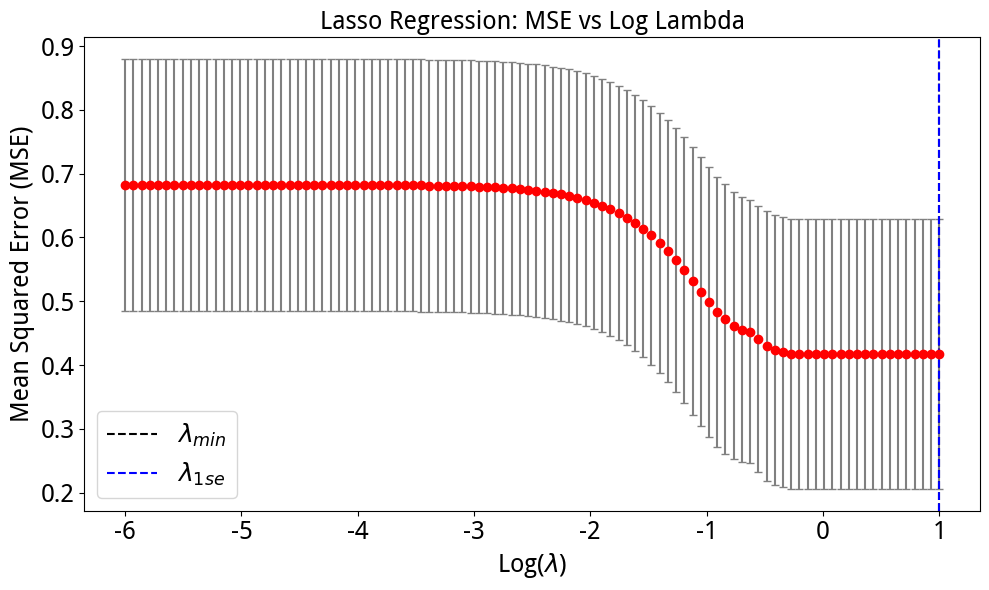

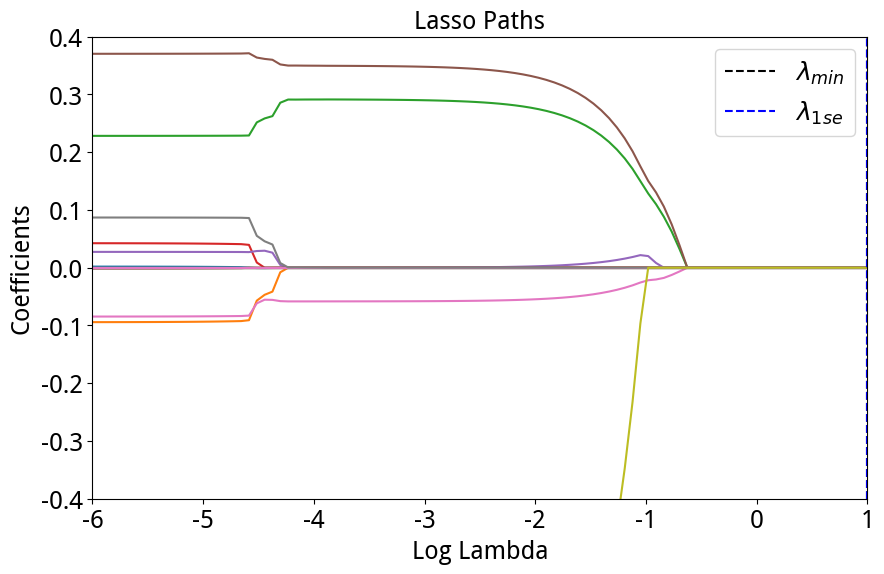


图片已保存到: /home/phl/PHL/Car-T/model_v1/output/feature_selection


In [67]:
# =============================================================================
# Lasso绘图
# =============================================================================
# 参考：https://mp.weixin.qq.com/s/5CqkCsWRsRys42rvnqUN_A
# # 有3处参数（cv划分折数要改为正式数据集的参数n_splits=3改为n_splits=10）
# 利用Scikit-learn的LassoCV实现LASSO回归模型的交叉验证和特征选择，针对连续目标变量进行优化。
# 导入LassoCV和RepeatedKFold（10折交叉验证重复3次以提升稳定性），并假设特征名为X.columns；
# 然后定义alpha（正则化强度）范围为对数尺度[-6,1]的100个值，进行LassoCV拟合训练数据，计算每个alpha下的均方误差路径（mse_path的均值）和标准差（mse_std）；
# 基于此，识别最佳alpha（λ_min，对应最小MSE）和1-SE规则alpha（λ_1se，即MSE不超过最小MSE加1个标准差的最大alpha，以实现更保守的稀疏性）；
# 最后，为这两个alpha分别重新拟合模型，提取非零系数的特征名，并打印结果，从而自动筛选出对目标变量真正重要的特征，帮助模型从高维数据中去除噪音，提升解释性和泛化能力

# 在这个LASSO特征选择结果中，Best alpha (λ_min=0.7391) 通过最小化交叉验证均方误差（MSE）选择了一个较小的正则化强度，从而保留了17个特征，实现高拟合度但泛化风险较高；
# 相比之下，1-SE rule alpha (λ_1se=1.9630) 采用更保守的阈值（MSE不超过λ_min MSE + 1个标准差的最大α），仅保留6个特征，显著提升模型稀疏性和解释性，同时牺牲少量拟合精度以避免过拟合
# =============================================================================
# 计算均方误差路径和标准差
mse_path = lasso_cv.mse_path_.mean(axis=1)  # 每个 alpha 的均方误差
mse_std = lasso_cv.mse_path_.std(axis=1)    # 每个 alpha 的均方误差的标准差

# 找到最佳 alpha 和 1-SE 规则的 alpha
best_alpha_index = np.argmin(mse_path)  # 最小均方误差的索引
best_alpha = lasso_cv.alphas_[best_alpha_index]  # 最佳 alpha 值
one_se_index = np.where(mse_path <= mse_path[best_alpha_index] + mse_std[best_alpha_index])[0][0]  # 1-SE 规则的 alpha 索引
one_se_alpha = lasso_cv.alphas_[one_se_index]  # 1-SE 规则的 alpha 值

# 打印最佳 alpha 值
print(f"Best alpha (λ_min): {best_alpha}")
print(f"1-SE rule alpha (λ_1se): {one_se_alpha}")

# 为两个 alpha 值进行特征选择
lasso_best_alpha = LassoCV(alphas=[best_alpha], cv=RepeatedKFold(n_splits=3, n_repeats=3, random_state=42), random_state=42)
lasso_best_alpha.fit(X_train_df, y_train)
selected_features_best = [feature_names[i] for i in np.where(lasso_best_alpha.coef_ != 0)[0]]  # 获取最佳 alpha 下的特征名
print(f"Selected features with λ_min: {selected_features_best}")  # 打印 λ_min 下选择的特征名

lasso_one_se_alpha = LassoCV(alphas=[one_se_alpha], cv=RepeatedKFold(n_splits=3, n_repeats=3, random_state=42), random_state=42)
lasso_one_se_alpha.fit(X_train_df, y_train)
selected_features_one_se = [feature_names[i] for i in np.where(lasso_one_se_alpha.coef_ != 0)[0]]  # 获取 1-SE 规则下的特征名
print(f"Selected features with λ_1se: {selected_features_one_se}")  # 打印 λ_1se 下选择的特征名

# 查看筛选到的变量
coef = pd.Series(lasso_cv.coef_,index = X_train_df.columns)
print("Lasso picked " + str(sum(coef != 0))+ " variables and eliminated the other " + str(sum(coef == 0))+ ' variables' )
index = coef[coef != 0].index
# 创建LASSO选择后的特征子集
X_train_lasso_selected = X_train_df[index]
print(f"\nLASSO选择的特征 (保存在 X_train_lasso_selected):")
print(coef[coef !=0])

# =============================================================================
# 可视化 Lasso 回归的均方误差路径
# 用横轴为对数尺度的λ（正则化强度）绘制Lasso回归的均方误差及误差条，最优λ与1-SEλ在其中显示，展示不同正则化强度下模型性能的变化（α即Log(λ))
from matplotlib import font_manager
font_properties = font_manager.FontProperties(weight='bold', size=18)
plt.figure(figsize=(10, 6))
# plt.errorbar(lasso_cv.alphas_, mse_path, yerr=mse_std, fmt='o', color='red', ecolor='gray', capsize=3)
# plt.axvline(lasso_cv.alphas_[best_alpha_index], linestyle='--', color='black', label=r'$\lambda_{min}$')
# plt.axvline(lasso_cv.alphas_[one_se_index], linestyle='--', color='blue', label=r'$\lambda_{1se}$')
# plt.xscale('log')  # 使用对数刻度显示 alpha 值
# plt.xlabel('Alpha (α) value', fontsize=18, fontweight='bold')

# 将 alpha 转换为 log lambda（log10）
log_lambdas = np.log10(lasso_cv.alphas_)
log_lambda_min = np.log10(lasso_cv.alphas_[best_alpha_index])
log_lambda_1se = np.log10(lasso_cv.alphas_[one_se_index])

# 绘制 MSE vs log lambda
plt.errorbar(log_lambdas, mse_path, yerr=mse_std, fmt='o', color='red', ecolor='gray', capsize=3)
plt.axvline(log_lambda_min, linestyle='--', color='black', label=r'$\lambda_{min}$')
plt.axvline(log_lambda_1se, linestyle='--', color='blue', label=r'$\lambda_{1se}$')
plt.xlabel('Log($\lambda$)', fontsize=18, fontweight='bold')

plt.ylabel('Mean Squared Error (MSE)', fontsize=18, fontweight='bold')
plt.title('Lasso Regression: MSE vs Log Lambda', fontsize=18, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.legend(fontsize=18, prop=font_properties)
plt.tight_layout()  
plt.savefig(os.path.join(output_dir, 'lasso_mse_alpha.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(output_dir, 'lasso_mse_alpha.pdf'), format='pdf', bbox_inches='tight', dpi=1200)
plt.show()

# =============================================================================
# lasso系数路径图
# 绘制Lasso回归中随正则化强度（λ）变化的系数路径图，通过这些图表可以理解LASSO模型是如何进行特征选择的，随着正则化强度的变化特征的模型系数也在变化，当系数变为0表示剔除特征，当最优模型特征的系数不为0时就是所保留的特征

from sklearn.linear_model import Lasso

coefs = []

for a in LASSO_ALPHA_RANGE:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_df, y_train)
    coefs.append(lasso.coef_)

# 创建字体属性
font_properties = font_manager.FontProperties(weight='bold', size=18)

# 绘制系数路径
plt.figure(figsize=(10, 6))
ax = plt.gca()

# 绘制系数路径图
ax.plot(np.log10(LASSO_ALPHA_RANGE), coefs)

# 绘制虚线，标记最佳 alpha 和 1-SE alpha
ax.axvline(np.log10(best_alpha), linestyle='--', color='black', label=r'$\lambda_{min}$')
ax.axvline(np.log10(one_se_alpha), linestyle='--', color='blue', label=r'$\lambda_{1se}$')
plt.xlabel('Log Lambda', fontsize=18, fontweight='bold')
plt.ylabel('Coefficients', fontsize=18, fontweight='bold')
plt.title('Lasso Paths', fontsize=18, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.legend(prop=font_properties)
# 设置坐标轴范围
# plt.axis('tight')
plt.xlim(-6, 1)  # X轴范围: Log Lambda
plt.ylim(-0.4, 0.4)  # Y轴范围: Coefficients
plt.savefig(os.path.join(output_dir, 'lasso_coefficient_paths.png'), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(output_dir, 'lasso_coefficient_paths.pdf'), format='pdf', bbox_inches='tight', dpi=1200)
plt.show()

print(f"\n图片已保存到: {output_dir}")

## 📊 R glmnet 风格的 LASSO 系数路径图

本节实现了与 R 语言 `glmnet` 包完全一致的 LASSO 系数路径可视化，包含以下关键特性：

### 核心特征

1. **双 X 轴设计**
   - **底部 X 轴**：`log(λ)` - 正则化强度的对数尺度
   - **顶部 X 轴**：`df` (degrees of freedom) - 非零系数数量

2. **动态计算 df**
   - 每个 λ 值对应的非零系数数量自动计算
   - 刻度位置智能优化，避免重叠

3. **关键点标注**
   - `λ_min`：交叉验证 MSE 最小的 λ 值（红色虚线）
   - `λ_1se`：1-SE 规则的 λ 值，更保守的选择（蓝色虚线）
   - 标签包含对应的 df 值

### 可视化版本

- **标准版**：双 X 轴，所有特征路径
- **增强版**：高亮重要特征，右侧添加特征名标签
- **对比版**：并排展示 Python 与 R glmnet 格式差异

### 技术说明

```
λ ↑ (正则化增强) → df ↓ (特征减少) → 系数稀疏化
λ ↓ (正则化减弱) → df ↑ (特征增多) → 系数密集化
```

---

生成 R glmnet 风格的 LASSO 系数路径图

正在计算 100 个不同 λ 值下的系数...
  进度: 20/100
  进度: 40/100
  进度: 60/100
  进度: 80/100
  进度: 100/100
✓ 系数计算完成
  特征数量: 19
  λ 范围: [0.000001, 10.000000]
  非零系数范围: [0, 18]

关键点信息:
  λ_min = 10.0000, log(λ_min) = 1.00, df = 0
  λ_1se = 10.0000, log(λ_1se) = 1.00, df = 0


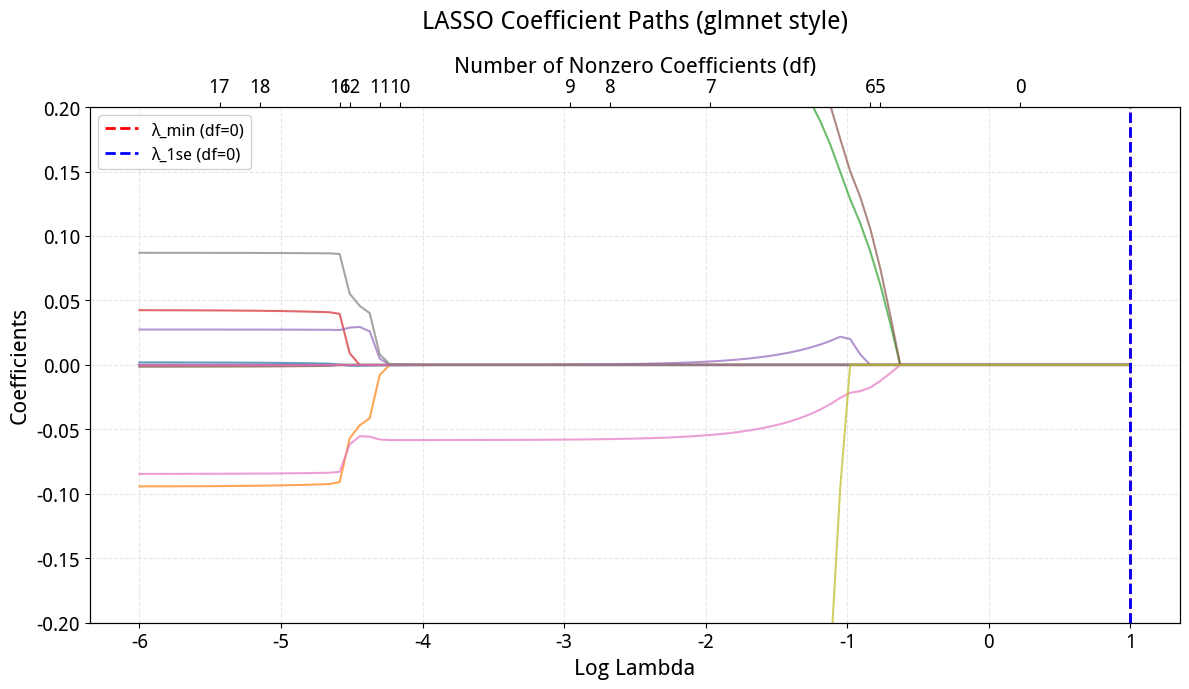


✓ 图片已保存: /home/phl/PHL/Car-T/model_v1/output/feature_selection/lasso_coefficient_paths_glmnet_style.png

系数路径关键统计
   Lambda  Log_Lambda  Nonzero_Coefs  Max_Abs_Coef  Mean_Abs_Coef
 0.000001   -6.000000             18      1.002668       0.107802
 0.000059   -4.232323             10      0.998778       0.169921
 0.003430   -2.464646              8      0.965190       0.206556
 0.200923   -0.696970              6      0.038834       0.012945
10.000000    1.000000              0      0.000000       0.000000



In [68]:
# =============================================================================
# R glmnet 风格的 LASSO 系数路径图（双 X 轴版本）
# =============================================================================
# 完全符合 R 语言 glmnet 包的可视化格式
# - 底部 X 轴：log(λ) 值（正则化强度）
# - 顶部 X 轴：非零系数数量（df - degrees of freedom）
# - Y 轴：系数值
# - 每条线代表一个特征的系数路径
# =============================================================================

from sklearn.linear_model import Lasso
from matplotlib import font_manager
import matplotlib.pyplot as plt
import numpy as np

print("=" * 80)
print("生成 R glmnet 风格的 LASSO 系数路径图")
print("=" * 80)

# ---------- 1. 计算不同 lambda 下的系数路径 ----------
coefs_glmnet = []
n_nonzero_coefs = []  # 每个 lambda 下非零系数的数量

print(f"\n正在计算 {len(LASSO_ALPHA_RANGE)} 个不同 λ 值下的系数...")

for i, alpha in enumerate(LASSO_ALPHA_RANGE):
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_train_df, y_train)
    coefs_glmnet.append(lasso.coef_)
    # 计算非零系数数量（即 df）
    n_nonzero = np.sum(lasso.coef_ != 0)
    n_nonzero_coefs.append(n_nonzero)
    
    if (i + 1) % 20 == 0:
        print(f"  进度: {i+1}/{len(LASSO_ALPHA_RANGE)}")

coefs_glmnet = np.array(coefs_glmnet)  # shape: (n_alphas, n_features)
n_nonzero_coefs = np.array(n_nonzero_coefs)

print(f"✓ 系数计算完成")
print(f"  特征数量: {coefs_glmnet.shape[1]}")
print(f"  λ 范围: [{LASSO_ALPHA_RANGE.min():.6f}, {LASSO_ALPHA_RANGE.max():.6f}]")
print(f"  非零系数范围: [{n_nonzero_coefs.min()}, {n_nonzero_coefs.max()}]")

# ---------- 2. 准备绘图数据 ----------
log_lambdas = np.log10(LASSO_ALPHA_RANGE)
log_lambda_min_glmnet = np.log10(best_alpha)
log_lambda_1se_glmnet = np.log10(one_se_alpha)

# 找到 λ_min 和 λ_1se 对应的非零系数数量
idx_min_glmnet = np.argmin(np.abs(LASSO_ALPHA_RANGE - best_alpha))
idx_1se_glmnet = np.argmin(np.abs(LASSO_ALPHA_RANGE - one_se_alpha))
df_at_min = n_nonzero_coefs[idx_min_glmnet]
df_at_1se = n_nonzero_coefs[idx_1se_glmnet]

print(f"\n关键点信息:")
print(f"  λ_min = {best_alpha:.4f}, log(λ_min) = {log_lambda_min_glmnet:.2f}, df = {df_at_min}")
print(f"  λ_1se = {one_se_alpha:.4f}, log(λ_1se) = {log_lambda_1se_glmnet:.2f}, df = {df_at_1se}")

# ---------- 3. 绘制 R glmnet 风格的系数路径图 ----------
fig, ax1 = plt.subplots(figsize=(12, 7))

# 绘制系数路径（每个特征一条线）
for i in range(coefs_glmnet.shape[1]):
    ax1.plot(log_lambdas, coefs_glmnet[:, i], linewidth=1.5, alpha=0.7)

# 绘制 λ_min 和 λ_1se 的垂直虚线
ax1.axvline(log_lambda_min_glmnet, linestyle='--', color='red', linewidth=2,
            label=f'λ_min (df={df_at_min})', zorder=10)
ax1.axvline(log_lambda_1se_glmnet, linestyle='--', color='blue', linewidth=2,
            label=f'λ_1se (df={df_at_1se})', zorder=10)

# 底部 X 轴设置（log(λ)）
ax1.set_xlabel('Log Lambda', fontsize=16, fontweight='bold')
ax1.set_ylabel('Coefficients', fontsize=16, fontweight='bold')
ax1.set_ylim(-0.2, 0.2)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.grid(True, alpha=0.3, linestyle='--')

# 添加图例
ax1.legend(loc='upper left', fontsize=12, framealpha=0.9)

# ---------- 4. 创建顶部 X 轴（显示非零系数数量 df）----------
ax2 = ax1.twiny()  # 创建共享 Y 轴的第二个 X 轴

# 为顶部 X 轴选择合适的刻度位置
# 策略：在 df 变化的关键点设置刻度
unique_dfs = np.unique(n_nonzero_coefs)[::-1]  # 降序排列

# 选择最多 10 个刻度（避免过于密集）
if len(unique_dfs) > 10:
    # 均匀采样
    step = len(unique_dfs) // 10
    selected_dfs = unique_dfs[::step]
else:
    selected_dfs = unique_dfs

# 找到每个选定 df 对应的 log(λ) 位置
df_positions = []
df_labels = []
for df in selected_dfs:
    # 找到第一个达到该 df 值的位置
    idx = np.where(n_nonzero_coefs == df)[0]
    if len(idx) > 0:
        # 取中间位置以获得更好的代表性
        mid_idx = idx[len(idx) // 2]
        df_positions.append(log_lambdas[mid_idx])
        df_labels.append(str(int(df)))

# 设置顶部 X 轴
ax2.set_xlim(ax1.get_xlim())  # 与底部 X 轴对齐
ax2.set_xticks(df_positions)
ax2.set_xticklabels(df_labels)
ax2.set_xlabel('Number of Nonzero Coefficients (df)', fontsize=16, fontweight='bold')
ax2.tick_params(axis='x', which='major', labelsize=14)

# 标题
plt.title('LASSO Coefficient Paths (glmnet style)', 
          fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'lasso_coefficient_paths_glmnet_style.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 图片已保存: {output_dir}/lasso_coefficient_paths_glmnet_style.png")

# ---------- 5. 生成详细的系数路径统计表 ----------
print("\n" + "=" * 80)
print("系数路径关键统计")
print("=" * 80)

# 在几个关键的 λ 值处展示系数
key_lambda_indices = [0, len(LASSO_ALPHA_RANGE)//4, len(LASSO_ALPHA_RANGE)//2, 
                      3*len(LASSO_ALPHA_RANGE)//4, -1]

stats_df = pd.DataFrame({
    'Lambda': [LASSO_ALPHA_RANGE[i] for i in key_lambda_indices],
    'Log_Lambda': [log_lambdas[i] for i in key_lambda_indices],
    'Nonzero_Coefs': [n_nonzero_coefs[i] for i in key_lambda_indices],
    'Max_Abs_Coef': [np.max(np.abs(coefs_glmnet[i, :])) for i in key_lambda_indices],
    'Mean_Abs_Coef': [np.mean(np.abs(coefs_glmnet[i, coefs_glmnet[i, :] != 0])) 
                      if n_nonzero_coefs[i] > 0 else 0 
                      for i in key_lambda_indices]
})

print(stats_df.to_string(index=False))

print("\n" + "=" * 80)

生成 R glmnet 风格的 LASSO 交叉验证 MSE 图

正在计算 100 个不同 λ 值下的非零系数数量...
✓ 计算完成

关键点信息:
  λ_min = 10.0000, log(λ_min) = 1.00, df = 0, MSE = 0.4169
  λ_1se = 10.0000, log(λ_1se) = 1.00, df = 0, MSE = 0.4169

--------------------------------------------------------------------------------
生成精确 R cv.glmnet 风格图
--------------------------------------------------------------------------------


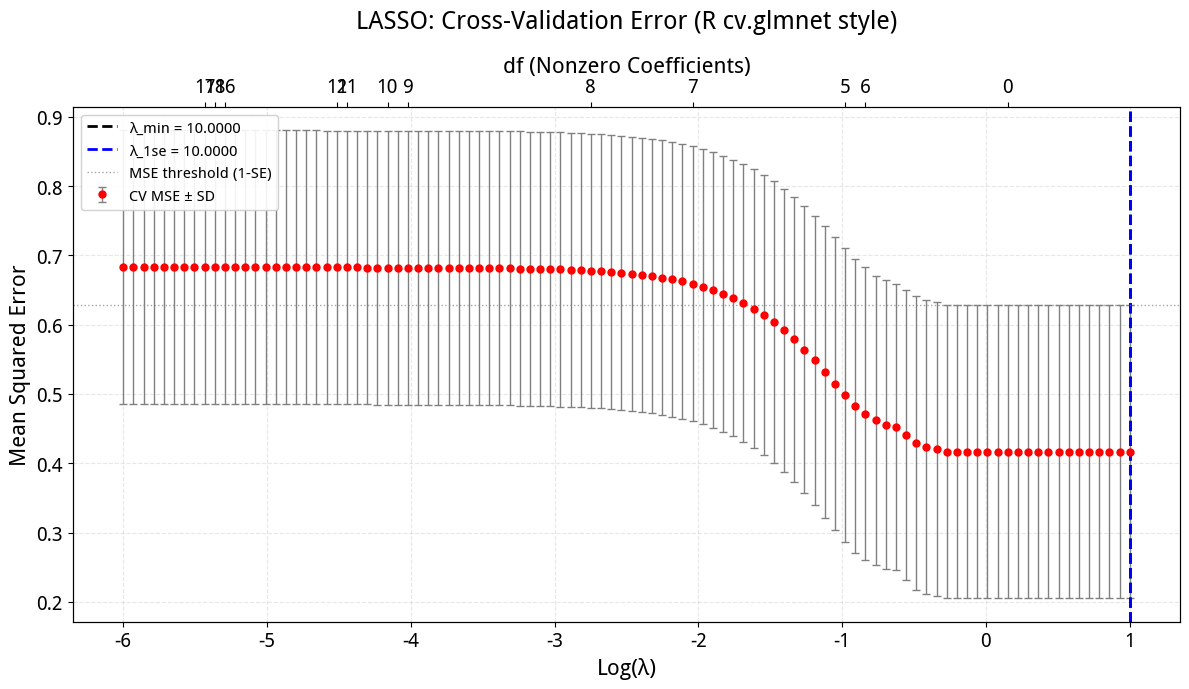

✓ 精确版图片已保存: /home/phl/PHL/Car-T/model_v1/output/feature_selection/lasso_cv_mse_glmnet_exact.png

LASSO 交叉验证关键统计
   指标  Lambda  Log(Lambda)  df (非零系数)   CV MSE  MSE Std
λ_min    10.0          1.0          0 0.416852 0.211628
λ_1se    10.0          1.0          0 0.416852 0.211628

【解释】
• λ_min: 使 CV MSE 最小的 λ 值，选择 0 个特征
• λ_1se: MSE 在 λ_min ± 1 SE 范围内的最大 λ（更稀疏），选择 0 个特征
• 1-SE 规则偏向于选择更简单的模型，提高泛化能力



In [69]:
# =============================================================================
# R glmnet 风格的 LASSO 交叉验证 MSE 图（双 X 轴版本）
# =============================================================================
# 完全符合 R 语言 glmnet 包 cv.glmnet() 函数的可视化格式
# - 底部 X 轴：log(λ) 值（正则化强度）
# - 顶部 X 轴：非零系数数量（df - degrees of freedom）
# - Y 轴：交叉验证均方误差 (MSE) ± 标准差
# - 关键标记：λ_min 和 λ_1se
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

print("=" * 80)
print("生成 R glmnet 风格的 LASSO 交叉验证 MSE 图")
print("=" * 80)

# ---------- 1. 准备数据 ----------
# 使用 lasso_cv 的结果
mse_mean_glmnet = lasso_cv.mse_path_.mean(axis=1)
mse_std_glmnet = lasso_cv.mse_path_.std(axis=1)
alphas_glmnet = lasso_cv.alphas_
log_lambdas_mse = np.log10(alphas_glmnet)

# 计算每个 lambda 对应的非零系数数量
n_nonzero_mse = []
print(f"\n正在计算 {len(alphas_glmnet)} 个不同 λ 值下的非零系数数量...")

for i, alpha in enumerate(alphas_glmnet):
    lasso_temp = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso_temp.fit(X_train_df, y_train)
    n_nonzero_mse.append(np.sum(lasso_temp.coef_ != 0))

n_nonzero_mse = np.array(n_nonzero_mse)

# 找到 λ_min 和 λ_1se
idx_min_mse = np.argmin(mse_mean_glmnet)
lambda_min_mse = alphas_glmnet[idx_min_mse]
log_lambda_min_mse = np.log10(lambda_min_mse)

# 1-SE 规则
mse_threshold = mse_mean_glmnet[idx_min_mse] + mse_std_glmnet[idx_min_mse]
idx_1se_candidates = np.where(mse_mean_glmnet <= mse_threshold)[0]
idx_1se_mse = idx_1se_candidates[0] if len(idx_1se_candidates) > 0 else idx_min_mse
lambda_1se_mse = alphas_glmnet[idx_1se_mse]
log_lambda_1se_mse = np.log10(lambda_1se_mse)

# 获取对应的 df 值
df_at_min_mse = n_nonzero_mse[idx_min_mse]
df_at_1se_mse = n_nonzero_mse[idx_1se_mse]

print(f"✓ 计算完成")
print(f"\n关键点信息:")
print(f"  λ_min = {lambda_min_mse:.4f}, log(λ_min) = {log_lambda_min_mse:.2f}, df = {df_at_min_mse}, MSE = {mse_mean_glmnet[idx_min_mse]:.4f}")
print(f"  λ_1se = {lambda_1se_mse:.4f}, log(λ_1se) = {log_lambda_1se_mse:.2f}, df = {df_at_1se_mse}, MSE = {mse_mean_glmnet[idx_1se_mse]:.4f}")

# # ---------- 2. 绘制 R glmnet 风格的 CV MSE 图 ----------
# fig, ax1 = plt.subplots(figsize=(12, 7))

# # 绘制 MSE 曲线和误差带
# ax1.plot(log_lambdas_mse, mse_mean_glmnet, 'o-', color='red', 
#          markersize=4, linewidth=1.5, label='CV Mean MSE')
# ax1.fill_between(log_lambdas_mse, 
#                  mse_mean_glmnet - mse_std_glmnet,
#                  mse_mean_glmnet + mse_std_glmnet,
#                  color='gray', alpha=0.3, label='±1 SD')

# # 绘制误差条（R glmnet 风格）
# ax1.errorbar(log_lambdas_mse, mse_mean_glmnet, yerr=mse_std_glmnet, 
#              fmt='none', ecolor='gray', capsize=2, alpha=0.5)

# # 绘制 λ_min 和 λ_1se 的垂直虚线
# ax1.axvline(log_lambda_min_mse, linestyle='--', color='red', linewidth=2,
#             label=f'λ_min (df={df_at_min_mse})', zorder=10)
# ax1.axvline(log_lambda_1se_mse, linestyle='--', color='blue', linewidth=2,
#             label=f'λ_1se (df={df_at_1se_mse})', zorder=10)

# # 底部 X 轴设置
# ax1.set_xlabel('Log(λ)', fontsize=16, fontweight='bold')
# ax1.set_ylabel('Mean Squared Error', fontsize=16, fontweight='bold')
# ax1.tick_params(axis='both', which='major', labelsize=14)
# ax1.grid(True, alpha=0.3, linestyle='--')

# # 图例设置
# ax1.legend(loc='upper left', fontsize=12, framealpha=0.9)

# # ---------- 3. 创建顶部 X 轴（显示 df）----------
# ax2 = ax1.twiny()

# 选择 df 刻度
unique_dfs_mse = np.unique(n_nonzero_mse)[::-1]  # 降序

# 选择最多 12 个刻度
if len(unique_dfs_mse) > 12:
    step = max(1, len(unique_dfs_mse) // 12)
    selected_dfs_mse = unique_dfs_mse[::step]
else:
    selected_dfs_mse = unique_dfs_mse

# 计算刻度位置
df_positions_mse = []
df_labels_mse = []
for df in selected_dfs_mse:
    idx = np.where(n_nonzero_mse == df)[0]
    if len(idx) > 0:
        mid_idx = idx[len(idx) // 2]
        df_positions_mse.append(log_lambdas_mse[mid_idx])
        df_labels_mse.append(str(int(df)))

# # 设置顶部 X 轴
# ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks(df_positions_mse)
# ax2.set_xticklabels(df_labels_mse)
# ax2.set_xlabel('Number of Nonzero Coefficients (df)', fontsize=16, fontweight='bold')
# ax2.tick_params(axis='x', which='major', labelsize=14)

# # 标题
# plt.title('LASSO Cross-Validated MSE (glmnet style)', 
#           fontsize=18, fontweight='bold', pad=20)

# plt.tight_layout()
# plt.savefig(os.path.join(output_dir, 'lasso_cv_mse_glmnet_style.png'), 
#             dpi=300, bbox_inches='tight')
# plt.show()

# print(f"\n✓ 图片已保存: {output_dir}/lasso_cv_mse_glmnet_style.png")

# =============================================================================
# 生成第二版：更精确模拟 R cv.glmnet 的输出
# =============================================================================
print("\n" + "-" * 80)
print("生成精确 R cv.glmnet 风格图")
print("-" * 80)

fig2, ax1_v2 = plt.subplots(figsize=(12, 7))

# R glmnet 风格：使用点 + 误差条
ax1_v2.errorbar(log_lambdas_mse, mse_mean_glmnet, yerr=mse_std_glmnet, 
                fmt='o', color='red', ecolor='gray', capsize=3, 
                markersize=5, linewidth=1, label='CV MSE ± SD')

# λ_min: 最小 MSE
ax1_v2.axvline(log_lambda_min_mse, linestyle='--', color='black', linewidth=2,
               label=f'λ_min = {lambda_min_mse:.4f}')

# λ_1se: 1-SE 规则
ax1_v2.axvline(log_lambda_1se_mse, linestyle='--', color='blue', linewidth=2,
               label=f'λ_1se = {lambda_1se_mse:.4f}')

# 添加水平线表示 1-SE 阈值
ax1_v2.axhline(mse_threshold, linestyle=':', color='gray', linewidth=1, alpha=0.7,
               label=f'MSE threshold (1-SE)')

# 底部 X 轴
ax1_v2.set_xlabel('Log(λ)', fontsize=16, fontweight='bold')
ax1_v2.set_ylabel('Mean Squared Error', fontsize=16, fontweight='bold')
ax1_v2.tick_params(axis='both', which='major', labelsize=14)
ax1_v2.grid(True, alpha=0.3, linestyle='--')
ax1_v2.legend(loc='upper left', fontsize=11, framealpha=0.9)

# 顶部 X 轴
ax2_v2 = ax1_v2.twiny()
ax2_v2.set_xlim(ax1_v2.get_xlim())
ax2_v2.set_xticks(df_positions_mse)
ax2_v2.set_xticklabels(df_labels_mse)
ax2_v2.set_xlabel('df (Nonzero Coefficients)', fontsize=16, fontweight='bold')
ax2_v2.tick_params(axis='x', which='major', labelsize=14)

plt.title('LASSO: Cross-Validation Error (R cv.glmnet style)', 
          fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'lasso_cv_mse_glmnet_exact.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 精确版图片已保存: {output_dir}/lasso_cv_mse_glmnet_exact.png")

# =============================================================================
# 输出关键统计信息
# =============================================================================
print("\n" + "=" * 80)
print("LASSO 交叉验证关键统计")
print("=" * 80)

cv_stats = pd.DataFrame({
    '指标': ['λ_min', 'λ_1se'],
    'Lambda': [lambda_min_mse, lambda_1se_mse],
    'Log(Lambda)': [log_lambda_min_mse, log_lambda_1se_mse],
    'df (非零系数)': [df_at_min_mse, df_at_1se_mse],
    'CV MSE': [mse_mean_glmnet[idx_min_mse], mse_mean_glmnet[idx_1se_mse]],
    'MSE Std': [mse_std_glmnet[idx_min_mse], mse_std_glmnet[idx_1se_mse]]
})

print(cv_stats.to_string(index=False))

print("\n【解释】")
print(f"• λ_min: 使 CV MSE 最小的 λ 值，选择 {df_at_min_mse} 个特征")
print(f"• λ_1se: MSE 在 λ_min ± 1 SE 范围内的最大 λ（更稀疏），选择 {df_at_1se_mse} 个特征")
print(f"• 1-SE 规则偏向于选择更简单的模型，提高泛化能力")

print("\n" + "=" * 80)

In [70]:
# ## =============================================================================
# # 模块 4: L1 正则化逻辑回归特征选择
# # =============================================================================
# # 作用：使用 L1 正则化的逻辑回归进行稀疏特征选择
# # 方法：针对二分类任务使用 L1 逻辑回归（替代 LassoCV），LogisticRegressionCV 交叉验证自动选择最优正则化参数 C
# # 输入：X_train, y_train, preprocessor (来自第13个单元格), feature_names (来自模块 1)
# # 输出：l1_results (DataFrame), l1_selected (特征列表)
# # 说明：专门针对二分类任务的特征选择方法，考虑特征间的联合效应
# # =============================================================================
# from sklearn.linear_model import LogisticRegressionCV

# # 配置参数
# # C 是正则化强度的倒数：C 越小 -> 正则化越强 -> 特征越稀疏
# L1_LOGREG_C_RANGE = np.logspace(-4, 2, 100)

# print("=" * 80)
# print("模块 4: L1 正则化逻辑回归特征选择")
# print("=" * 80)

# # 构建 L1 逻辑回归 Pipeline
# l1_model = LogisticRegressionCV(
#     penalty='l1',
#     solver='saga',           # 'saga' 支持 L1 正则化
#     Cs=L1_LOGREG_C_RANGE,
#     cv=RepeatedKFold(n_splits=3, n_repeats=3, random_state=42),    # 3折交叉验证
#     scoring='roc_auc',       # 使用 AUC 作为评估指标
#     random_state=42,
#     max_iter=5000,
#     n_jobs=-1
# )

# print("\n正在训练 L1 正则化逻辑回归模型...")
# print(f"  - 候选 C 数量: {len(L1_LOGREG_C_RANGE)}")
# print(f"  - C 范围: {L1_LOGREG_C_RANGE.min():.6f} ~ {L1_LOGREG_C_RANGE.max():.2f}")
# print(f"  - 交叉验证折数: 3")
# print(f"  - 评估指标: ROC AUC")

# # 训练模型
# l1_model.fit(X_train_df, y_train)

# # 提取结果
# l1_coefs = l1_model.coef_[0]
# best_C = l1_model.C_[0]
# best_lambda = 1 / best_C  # 转换为与 Lasso alpha 可比较的形式


# print(f"\n L1 逻辑回归训练完成")
# print(f"最佳 C: {best_C:.6f}(对应 λ = {best_lambda:.6f})")
# print(f"  - 训练集AUC: {l1_model.score(X_train_df, y_train):.4f}")

# # 创建结果 DataFrame
# l1_results = pd.DataFrame({
#     'Feature': feature_names,
#     'L1_LogReg_Coefficient': l1_coefs,
#     'L1_LogReg_Abs_Coef': np.abs(l1_coefs),
#     'L1_LogReg_Selected': l1_coefs != 0
# })

# # 按系数绝对值排序
# l1_results = l1_results.sort_values('L1_LogReg_Abs_Coef', ascending=False).reset_index(drop=True)

# # 筛选非零系数特征
# l1_selected = l1_results[l1_results['L1_LogReg_Selected']]['Feature'].tolist()

# # 输出结果
# print("\n" + "=" * 80)
# print("L1 逻辑回归特征选择结果")
# print("=" * 80)
# print(f"选中特征数: {len(l1_selected)}/{len(feature_names)}")
# print(f"剔除特征数: {len(feature_names) - len(l1_selected)}")
# print(f"特征保留率: {len(l1_selected)/len(feature_names)*100:.1f}%")

# print(f"\nTop 15 重要特征 (按系数绝对值排序):")
# print(l1_results[l1_results['L1_LogReg_Selected']].head(15)[['Feature', 'L1_LogReg_Coefficient', 'L1_LogReg_Abs_Coef']].to_string(index=False))

# # 保存结果
# l1_results.to_csv(f"{output_dir}/l1_logreg_results.csv", index=False)
# print(f"\n 结果已保存至: {output_dir}/l1_logreg_results.csv")

# print("\n可用变量:")
# print("  - l1_logreg_pipeline: 完整的 L1 逻辑回归 Pipeline")
# print("  - l1_model: 训练好的 LogisticRegressionCV 模型")
# print("  - l1_results: 完整结果 DataFrame")
# print("  - l1_selected: 被选中的特征列表")
# print("  - best_C: 最优正则化参数")

## 📊 L1 逻辑回归交叉验证可视化（R glmnet 风格）

### 说明

由于 `LogisticRegressionCV` 不像 `LassoCV` 那样直接提供 `mse_path_` 属性，我们需要手动实现交叉验证循环来计算：

1. **二项式偏差 (Binomial Deviance)**：`2 × log_loss`，与 R glmnet 中的 deviance 定义一致
2. **每个 λ (= 1/C) 对应的非零系数数量 (df)**
3. **λ_min 和 λ_1se 的识别**

### 与 LassoCV 的区别

| 特性 | LassoCV (回归) | L1 LogisticRegression (分类) |
|------|---------------|------------------------------|
| 损失函数 | MSE | 对数损失 (Log Loss) |
| 评估指标 | 均方误差 | 二项式偏差 / AUC |
| 参数 | alpha (λ) | C (= 1/λ) |
| 适用任务 | 回归 | 二分类 |

---

In [71]:
# # =============================================================================
# # L1 逻辑回归交叉验证：计算二项式偏差路径（R glmnet 风格）
# # =============================================================================
# # 手动实现交叉验证循环，计算每个 λ (= 1/C) 对应的二项式偏差
# # 二项式偏差 = 2 × log_loss（与 R glmnet 定义一致）
# # =============================================================================

# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import log_loss
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# import pandas as pd

# print("=" * 80)
# print("L1 逻辑回归交叉验证 - 计算二项式偏差路径")
# print("=" * 80)

# # ---------- 1. 配置参数 ----------
# # 原范围: logspace(-4, 2, 50) -> lambda范围 [10^-2, 10^4] -> Log(lambda) [-2, 4]
# # 目标范围: Log(lambda) [-6, 1] -> lambda范围 [10^-6, 10^1] -> C范围 [10^-1, 10^6]
# C_RANGE_CV = np.logspace(-3, 6, 100)  # 扩大 C 值范围 (减小 Lambda)
# LAMBDA_RANGE_CV = 1 / C_RANGE_CV      # 对应的 λ 值

# # 交叉验证配置
# # 使用 StratifiedKFold 替代 RepeatedKFold
# # StratifiedKFold 保证每折中类别比例与原始数据一致
# N_SPLITS = 3
# cv_splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# print(f"\n配置信息:")
# print(f"  - C 范围: [{C_RANGE_CV.min():.6f}, {C_RANGE_CV.max():.2f}]")
# print(f"  - λ 范围: [{LAMBDA_RANGE_CV.min():.6f}, {LAMBDA_RANGE_CV.max():.2f}]")
# print(f"  - C 值数量: {len(C_RANGE_CV)}")

# # ---------- 2. 交叉验证计算二项式偏差 ----------
# print("\n正在计算交叉验证二项式偏差...")

# # 存储结果
# cv_results = []

# for i, (C_val, lambda_val) in enumerate(zip(C_RANGE_CV, LAMBDA_RANGE_CV)):
#     fold_deviances = []
#     fold_n_features = []
    
#     for train_idx, val_idx in cv_splitter.split(X_train_df, y_train):
#         # 划分训练集和验证集
#         X_tr, X_val = X_train_df.iloc[train_idx], X_train_df.iloc[val_idx]
#         y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
#         # 训练 L1 逻辑回归模型
#         lr = LogisticRegression(
#             penalty='l1',
#             solver='saga',  # saga 求解器对 L1 更快且支持 warm_start
#             C=C_val,
#             # class_weight='balanced', # 关键：处理样本不平衡，避免模型只学截距
#             max_iter=5000,
#             random_state=42
#         )
#         lr.fit(X_tr, y_tr)
        
#         # 计算验证集上的二项式偏差
#         y_prob = lr.predict_proba(X_val)
#         # 裁剪概率避免 log(0)
#         y_prob_clipped = np.clip(y_prob, 1e-15, 1 - 1e-15)
#         # 二项式偏差 = 2 × log_loss（与 R glmnet 定义一致）
#         deviance = 2 * log_loss(y_val, y_prob_clipped)
#         fold_deviances.append(deviance)
        
#         # 统计非零系数数量
#         n_nonzero = np.sum(lr.coef_[0] != 0)
#         fold_n_features.append(n_nonzero)
    
#     # 记录该 C 值的结果
#     cv_results.append({
#         'C': C_val,
#         'lambda': lambda_val,
#         'log_lambda': np.log10(lambda_val),
#         'deviance_mean': np.mean(fold_deviances),
#         'deviance_std': np.std(fold_deviances),
#         'n_features_mean': np.mean(fold_n_features),
#         'n_features': int(np.round(np.mean(fold_n_features)))
#     })
    
#     # 打印进度
#     if (i + 1) % 10 == 0:
#         print(f"  进度: {i+1}/{len(C_RANGE_CV)}")

# cv_results_df = pd.DataFrame(cv_results)
# print(f"\n✓ 交叉验证计算完成")



# =============================================================================
# 计算二项式偏差 - 修正版
# =============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

# ✅ 新增：二项式偏差计算函数
def calculate_binomial_deviance(y_true, y_prob):
    """
    计算二项式偏差（与 R glmnet 一致）
    
    公式：D = -2 * Σ[y*log(p) + (1-y)*log(1-p)]
    """
    y_prob = np.clip(y_prob, 1e-15, 1 - 1e-15)
    
    if y_prob.ndim == 2:
        p1 = y_prob[:, 1]
        p0 = y_prob[:, 0]
    else:
        p1 = y_prob
        p0 = 1 - y_prob
        
    # 二项式偏差的“尺度”修正
    # deviance = -2 * np.sum(     # 总 deviance（total deviance）——错误尺度
    #     y_true * np.log(p1) + (1 - y_true) * np.log(p0)
    # )
    deviance = -2 * np.mean(    # glmnet 的 CV 曲线画的是“平均 deviance（mean deviance）”——正确
    y_true * np.log(p1) + (1 - y_true) * np.log(p0)
)
    
    
    return deviance

print("=" * 80)
print("L1 逻辑回归交叉验证 - 计算二项式偏差路径（修正版）")
print("=" * 80)

# 配置参数
C_RANGE_CV = np.logspace(-3, 6, 100)
# LAMBDA_RANGE_CV = 1 / C_RANGE_CV
n_samples = X_train_df.shape[0]
LAMBDA_RANGE_CV = 1 / (C_RANGE_CV * n_samples)
N_SPLITS = 3
cv_splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

print(f"\n配置信息:")
print(f"  - C 范围: [{C_RANGE_CV.min():.6f}, {C_RANGE_CV.max():.2f}]")
print(f"  - λ 范围: [{LAMBDA_RANGE_CV.min():.6f}, {LAMBDA_RANGE_CV.max():.2f}]")

# 交叉验证计算偏差
print("\n正在计算交叉验证二项式偏差...")
cv_results = []

for i, (C_val, lambda_val) in enumerate(zip(C_RANGE_CV, LAMBDA_RANGE_CV)):
    fold_deviances = []
    fold_n_features = []
    
    for train_idx, val_idx in cv_splitter.split(X_train_df, y_train):
        X_tr, X_val = X_train_df.iloc[train_idx], X_train_df.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        lr = LogisticRegression(
            penalty='l1',
            solver='saga',
            C=C_val,
            max_iter=5000,
            random_state=42
        )
        lr.fit(X_tr, y_tr)
        
        # ✅ 修改：使用正确的偏差计算
        y_prob = lr.predict_proba(X_val)
        deviance = calculate_binomial_deviance(y_val.values, y_prob)
        fold_deviances.append(deviance)
        
        n_nonzero = np.sum(lr.coef_[0] != 0)
        fold_n_features.append(n_nonzero)
    
    cv_results.append({
        'C': C_val,
        'lambda': lambda_val,
        'log_lambda': np.log10(lambda_val),
        'deviance_mean': np.mean(fold_deviances),
        'deviance_std': np.std(fold_deviances),
        'n_features_mean': np.mean(fold_n_features),
        'n_features': int(np.round(np.mean(fold_n_features)))
    })
    
    if (i + 1) % 10 == 0:
        print(f"  进度: {i+1}/{len(C_RANGE_CV)}")

cv_results_df = pd.DataFrame(cv_results)
print(f"\n✓ 交叉验证计算完成")

# ✅ 验证：偏差值应在合理范围内
print(f"\n偏差值范围检查:")
print(f"  最小偏差: {cv_results_df['deviance_mean'].min():.2f}")
print(f"  最大偏差: {cv_results_df['deviance_mean'].max():.2f}")
print(f"  中位数偏差: {cv_results_df['deviance_mean'].median():.2f}")

# deviance 理论下界 ≈ 0
# deviance 理论上界 ≈ 2 * log(2) ≈ 1.386（完全随机）
if cv_results_df['deviance_mean'].min() > 1.5:
    warnings.warn("最小平均二项式偏差较大，模型区分能力可能较弱")

# ---------- 3. 识别 λ_min 和 λ_1se ----------
# λ_min: 使二项式偏差最小的 λ
idx_min = cv_results_df['deviance_mean'].idxmin()
lambda_min_lr = cv_results_df.loc[idx_min, 'lambda']
C_min_lr = cv_results_df.loc[idx_min, 'C']
deviance_min = cv_results_df.loc[idx_min, 'deviance_mean']
deviance_std_at_min = cv_results_df.loc[idx_min, 'deviance_std']
df_at_lambda_min = cv_results_df.loc[idx_min, 'n_features']

# λ_1se: 在 deviance_min + 1*SE 范围内的最大 λ（最稀疏模型）
deviance_se_at_min = deviance_std_at_min / np.sqrt(N_SPLITS)  # glmnet 的 λ_1se 定义（严格）——标准误差
deviance_threshold = deviance_min + deviance_se_at_min
# 找到所有满足条件的 λ
valid_indices = cv_results_df[cv_results_df['deviance_mean'] <= deviance_threshold].index
# 选择其中 λ 最大的（即 C 最小的）
idx_1se = cv_results_df.loc[valid_indices, 'lambda'].idxmax()
lambda_1se_lr = cv_results_df.loc[idx_1se, 'lambda']
C_1se_lr = cv_results_df.loc[idx_1se, 'C']
df_at_lambda_1se = cv_results_df.loc[idx_1se, 'n_features']

print(f"\n关键结果:")
print(f"  λ_min = {lambda_min_lr:.6f} (C = {C_min_lr:.6f})")
print(f"    - 二项式偏差: {deviance_min:.4f} ± {deviance_std_at_min:.4f}")
print(f"    - 非零特征数 (df): {df_at_lambda_min}")
print(f"  λ_1se = {lambda_1se_lr:.6f} (C = {C_1se_lr:.6f})")
print(f"    - 二项式偏差: {cv_results_df.loc[idx_1se, 'deviance_mean']:.4f}")
print(f"    - 非零特征数 (df): {df_at_lambda_1se}")

# ---------- 4. 使用最优参数重新训练并获取特征 ----------
print("\n使用最优参数重新训练模型...")

# λ_min 对应的模型
lr_lambda_min = LogisticRegression(
    penalty='l1', solver='saga', C=C_min_lr, max_iter=5000, random_state=42
)
lr_lambda_min.fit(X_train_df, y_train)
selected_features_lambda_min = [feature_names[i] for i in np.where(lr_lambda_min.coef_[0] != 0)[0]]

# λ_1se 对应的模型
lr_lambda_1se = LogisticRegression(
    penalty='l1', solver='saga', C=C_1se_lr, max_iter=5000, random_state=42
)
lr_lambda_1se.fit(X_train_df, y_train)
selected_features_lambda_1se = [feature_names[i] for i in np.where(lr_lambda_1se.coef_[0] != 0)[0]]

print(f"\nλ_min 选择的特征 ({len(selected_features_lambda_min)} 个):")
print(f"  {selected_features_lambda_min}")
print(f"\nλ_1se 选择的特征 ({len(selected_features_lambda_1se)} 个):")
print(f"  {selected_features_lambda_1se}")

# ---------- 5. 保存特征选择结果为 JSON ----------
import json

feature_selection_results = {
    'lambda_min_features': selected_features_lambda_min,
    'lambda_1se_features': selected_features_lambda_1se,
    'lambda_min_value': float(lambda_min_lr),
    'lambda_1se_value': float(lambda_1se_lr),
    'n_features_lambda_min': len(selected_features_lambda_min),
    'n_features_lambda_1se': len(selected_features_lambda_1se)
}

json_path = os.path.join(output_dir, 'l1_logreg_feature_selection.json')
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(feature_selection_results, f, indent=2, ensure_ascii=False)

print(f"✓ 特征选择结果已保存至: {json_path}")

# 保存结果
cv_results_df.to_csv(os.path.join(output_dir, 'l1_logreg_cv_results.csv'), index=False)
print(f"\n✓ 交叉验证结果已保存至: {output_dir}/l1_logreg_cv_results.csv")


print("\n" + "=" * 80)

L1 逻辑回归交叉验证 - 计算二项式偏差路径（修正版）

配置信息:
  - C 范围: [0.001000, 1000000.00]
  - λ 范围: [0.000000, 142.86]

正在计算交叉验证二项式偏差...
  进度: 10/100
  进度: 20/100
  进度: 30/100
  进度: 40/100
  进度: 50/100
  进度: 60/100
  进度: 70/100
  进度: 80/100
  进度: 90/100
  进度: 100/100

✓ 交叉验证计算完成

偏差值范围检查:
  最小偏差: 1.38
  最大偏差: 4.14
  中位数偏差: 2.43

关键结果:
  λ_min = 0.762386 (C = 0.187382)
    - 二项式偏差: 1.3765 ± 0.0143
    - 非零特征数 (df): 0
  λ_1se = 142.857143 (C = 0.001000)
    - 二项式偏差: 1.3765
    - 非零特征数 (df): 0

使用最优参数重新训练模型...

λ_min 选择的特征 (0 个):
  []

λ_1se 选择的特征 (0 个):
  []
✓ 特征选择结果已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_selection/l1_logreg_feature_selection.json

✓ 交叉验证结果已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_selection/l1_logreg_cv_results.csv



绘制 R glmnet 风格的 L1 逻辑回归交叉验证图


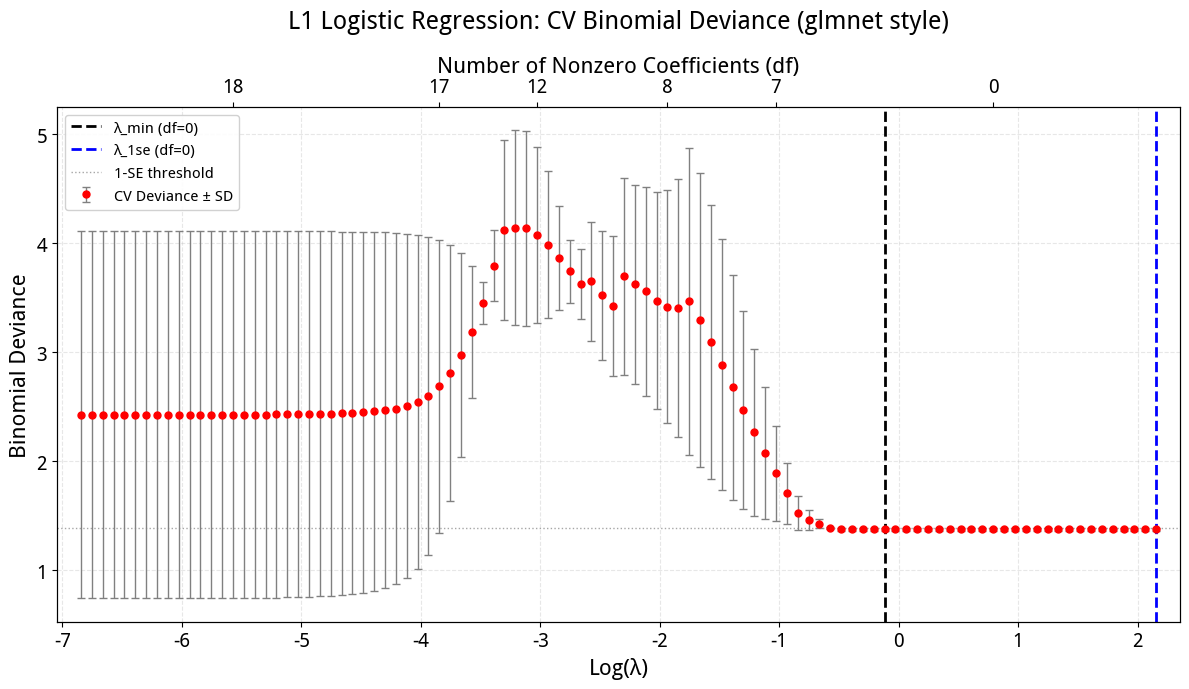


✓ 图片已保存: /home/phl/PHL/Car-T/model_v1/output/feature_selection/l1_logreg_cv_deviance_glmnet_style.png


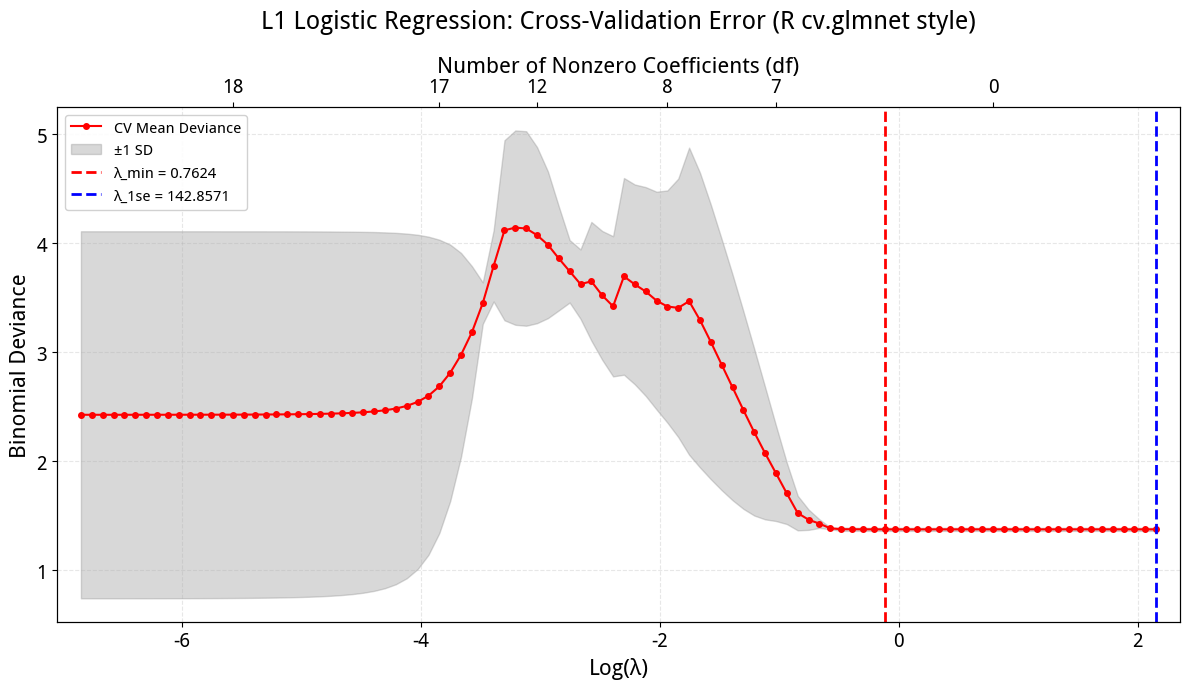

✓ 精确版图片已保存: /home/phl/PHL/Car-T/model_v1/output/feature_selection/l1_logreg_cv_deviance_exact.png

L1 逻辑回归交叉验证关键统计
   指标     Lambda  C (= 1/λ)    Log(λ)  df (非零系数)  CV Deviance  Deviance Std
λ_min   0.762386   0.187382 -0.117825          0     1.376495      0.014285
λ_1se 142.857143   0.001000  2.154902          0     1.376495      0.014285

【与 LassoCV (回归) 的区别】
• LassoCV 使用 MSE 作为评估指标（适用于回归任务）
• L1 LogisticRegression 使用二项式偏差作为评估指标（适用于分类任务）
• 二项式偏差 = 2 × log_loss，与 R glmnet 的 deviance 定义一致



In [72]:
# =============================================================================
# R glmnet 风格：L1 逻辑回归交叉验证二项式偏差图（双 X 轴）
# =============================================================================
# 完全模拟 R cv.glmnet(family="binomial") 的输出格式
# - 底部 X 轴：log(λ)
# - 顶部 X 轴：df (非零系数数量)
# - Y 轴：二项式偏差 (Binomial Deviance)
# =============================================================================

import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.ticker as ticker

print("=" * 80)
print("绘制 R glmnet 风格的 L1 逻辑回归交叉验证图")
print("=" * 80)

# 获取排序索引（按 lambda 降序），对 CV 结果同步排序
lambda_order = np.argsort(LAMBDA_RANGE_CV)[::-1]
cv_results_df = cv_results_df.iloc[lambda_order].reset_index(drop=True)

# ---------- 1. 准备绘图数据 ----------
log_lambdas_lr = cv_results_df['log_lambda'].values
deviance_mean = cv_results_df['deviance_mean'].values
deviance_std = cv_results_df['deviance_std'].values
n_features_arr = cv_results_df['n_features'].values

log_lambda_min_lr = np.log10(lambda_min_lr)
log_lambda_1se_lr = np.log10(lambda_1se_lr)

# ---------- 2. 绘制二项式偏差 vs log(λ) 图（R glmnet 风格）----------
fig, ax1 = plt.subplots(figsize=(12, 7))

# 绘制误差条和均值曲线
ax1.errorbar(log_lambdas_lr, deviance_mean, yerr=deviance_std, 
             fmt='o', color='red', ecolor='gray', capsize=3, 
             markersize=5, linewidth=1, label='CV Deviance ± SD')

# 绘制 λ_min 和 λ_1se 垂直虚线
ax1.axvline(log_lambda_min_lr, linestyle='--', color='black', linewidth=2,
            label=f'λ_min (df={df_at_lambda_min})')
ax1.axvline(log_lambda_1se_lr, linestyle='--', color='blue', linewidth=2,
            label=f'λ_1se (df={df_at_lambda_1se})')

# 绘制 1-SE 阈值水平线
ax1.axhline(deviance_threshold, linestyle=':', color='gray', linewidth=1, 
            alpha=0.7, label='1-SE threshold')

# 底部 X 轴设置（log(λ)）
ax1.set_xlabel('Log(λ)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Binomial Deviance', fontsize=16, fontweight='bold')
ax1.set_xlim(log_lambdas_lr.min() - 0.2, log_lambdas_lr.max() + 0.2)  # 根据数据范围自动设置，并留出边距

# 强制底部 X 轴只显示整数刻度
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True)) 
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper left', fontsize=11, framealpha=0.9)

# ---------- 3. 创建顶部 X 轴（显示 df）----------
ax2 = ax1.twiny()

# --- 选择 df 刻度，确保不重叠 ---
# 参考 l1_logreg_coefficient_paths_glmnet_style 的显示逻辑，并增加防重叠处理
unique_dfs_lr = np.unique(n_features_arr)[::-1]  # 降序
if len(unique_dfs_lr) > 12:
    step = max(1, len(unique_dfs_lr) // 12)
    selected_dfs_lr = unique_dfs_lr[::step]
else:
    selected_dfs_lr = unique_dfs_lr

#============================================================
# # 计算刻度位置
# df_positions_lr = []
# df_labels_lr = []
# for df in selected_dfs_lr:
#     idx = np.where(n_features_arr == df)[0]
#     if len(idx) > 0:
#         mid_idx = idx[len(idx) // 2]
#         df_positions_lr.append(log_lambdas_lr[mid_idx])
#         df_labels_lr.append(str(int(df)))
#============================================================
# 为了防止标签重叠，我们根据 Log(λ) 的位置筛选标签
# 1. 计算每个 unique df 对应的平均 position
df_to_pos = {}
for df in unique_dfs_lr:
    idx = np.where(n_features_arr == df)[0]
    if len(idx) > 0:
        # 取该 df 出现位置的平均 log_lambda 或中间 log_lambda
        mid_idx = idx[len(idx) // 2]
        df_to_pos[df] = log_lambdas_lr[mid_idx]

# 2. 按位置排序
sorted_dfs_by_pos = sorted(df_to_pos.keys(), key=lambda d: df_to_pos[d])

# 3. 筛选标签，确保最小间距
df_positions_lr = []
df_labels_lr = []

if len(sorted_dfs_by_pos) > 0:
    # 确定 X 轴跨度
    x_span = log_lambdas_lr.max() - log_lambdas_lr.min()
    min_dist = x_span / 15.0  # 允许最多约 15 个标签，保证间距
    
    last_pos = -float('inf')
    
    # 遍历筛选
    for df in sorted_dfs_by_pos:
        pos = df_to_pos[df]
        # 简单策略：如果距离上一个足够远，则保留
        if pos - last_pos > min_dist:
            df_positions_lr.append(pos)
            df_labels_lr.append(str(int(df)))
            last_pos = pos
            
    # 确保包含最后一个（两端通常较重要）
    last_df = sorted_dfs_by_pos[-1]
    last_pos_real = df_to_pos[last_df]
    if len(df_positions_lr) > 0:
        if df_positions_lr[-1] != last_pos_real:
             if abs(last_pos_real - df_positions_lr[-1]) < min_dist:
                 # 如果太近，用最后一个替换掉上一个
                 df_positions_lr.pop()
                 df_labels_lr.pop()
             df_positions_lr.append(last_pos_real)
             df_labels_lr.append(str(int(last_df)))
    else:
        df_positions_lr.append(last_pos_real)
        df_labels_lr.append(str(int(last_df)))
#============================================================


# 设置顶部 X 轴
ax2.set_xlim(ax1.get_xlim())     # 与底部 X 轴保持一致
ax2.set_xticks(df_positions_lr)
ax2.set_xticklabels(df_labels_lr)
ax2.set_xlabel('Number of Nonzero Coefficients (df)', fontsize=16, fontweight='bold')
ax2.tick_params(axis='x', which='major', labelsize=14)

# 标题
plt.title('L1 Logistic Regression: CV Binomial Deviance (glmnet style)', 
          fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'l1_logreg_cv_deviance_glmnet_style.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 图片已保存: {output_dir}/l1_logreg_cv_deviance_glmnet_style.png")

# =============================================================================
# 额外：绘制精确模拟 R cv.glmnet 的输出
# =============================================================================
fig2, ax1_v2 = plt.subplots(figsize=(12, 7))

# 绘制带填充的误差带
ax1_v2.plot(log_lambdas_lr, deviance_mean, 'o-', color='red', 
            markersize=4, linewidth=1.5, label='CV Mean Deviance')
ax1_v2.fill_between(log_lambdas_lr, 
                    deviance_mean - deviance_std,
                    deviance_mean + deviance_std,
                    color='gray', alpha=0.3, label='±1 SD')

# 垂直虚线
ax1_v2.axvline(log_lambda_min_lr, linestyle='--', color='red', linewidth=2,
               label=f'λ_min = {lambda_min_lr:.4f}')
ax1_v2.axvline(log_lambda_1se_lr, linestyle='--', color='blue', linewidth=2,
               label=f'λ_1se = {lambda_1se_lr:.4f}')

# 底部 X 轴
ax1_v2.set_xlabel('Log(λ)', fontsize=16, fontweight='bold')
ax1_v2.set_ylabel('Binomial Deviance', fontsize=16, fontweight='bold')
# ax1.set_xlim(-6，-1) 
ax1_v2.set_xlim(ax1.get_xlim())  # 保持一致
ax1_v2.tick_params(axis='both', which='major', labelsize=14)
ax1_v2.grid(True, alpha=0.3, linestyle='--')
ax1_v2.legend(loc='upper left', fontsize=11, framealpha=0.9)

# 顶部 X 轴 (复用)
ax2_v2 = ax1_v2.twiny()
ax2_v2.set_xlim(ax1_v2.get_xlim())
ax2_v2.set_xticks(df_positions_lr)
ax2_v2.set_xticklabels(df_labels_lr)
ax2_v2.set_xlabel('Number of Nonzero Coefficients (df)', fontsize=16, fontweight='bold')
ax2_v2.tick_params(axis='x', which='major', labelsize=14)

plt.title('L1 Logistic Regression: Cross-Validation Error (R cv.glmnet style)', 
          fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'l1_logreg_cv_deviance_exact.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 精确版图片已保存: {output_dir}/l1_logreg_cv_deviance_exact.png")

# =============================================================================
# 输出关键统计信息
# =============================================================================
print("\n" + "=" * 80)
print("L1 逻辑回归交叉验证关键统计")
print("=" * 80)

cv_stats_lr = pd.DataFrame({
    '指标': ['λ_min', 'λ_1se'],
    'Lambda': [lambda_min_lr, lambda_1se_lr],
    'C (= 1/λ)': [C_min_lr, C_1se_lr],
    'Log(λ)': [log_lambda_min_lr, log_lambda_1se_lr],
    'df (非零系数)': [df_at_lambda_min, df_at_lambda_1se],
    'CV Deviance': [cv_results_df.loc[idx_min, 'deviance_mean'], 
                    cv_results_df.loc[idx_1se, 'deviance_mean']],
    'Deviance Std': [cv_results_df.loc[idx_min, 'deviance_std'], 
                     cv_results_df.loc[idx_1se, 'deviance_std']]
})

print(cv_stats_lr.to_string(index=False))

print("\n【与 LassoCV (回归) 的区别】")
print("• LassoCV 使用 MSE 作为评估指标（适用于回归任务）")
print("• L1 LogisticRegression 使用二项式偏差作为评估指标（适用于分类任务）")
print("• 二项式偏差 = 2 × log_loss，与 R glmnet 的 deviance 定义一致")

print("\n" + "=" * 80)

绘制 L1 逻辑回归系数路径图

正在计算 100 个不同 λ 值下的系数...
  进度: 10/100
  进度: 20/100
  进度: 30/100
  进度: 40/100
  进度: 50/100
  进度: 60/100
  进度: 70/100
  进度: 80/100
  进度: 90/100
  进度: 100/100
✓ 系数计算完成
  特征数量: 19
  非零系数范围: [0, 18]


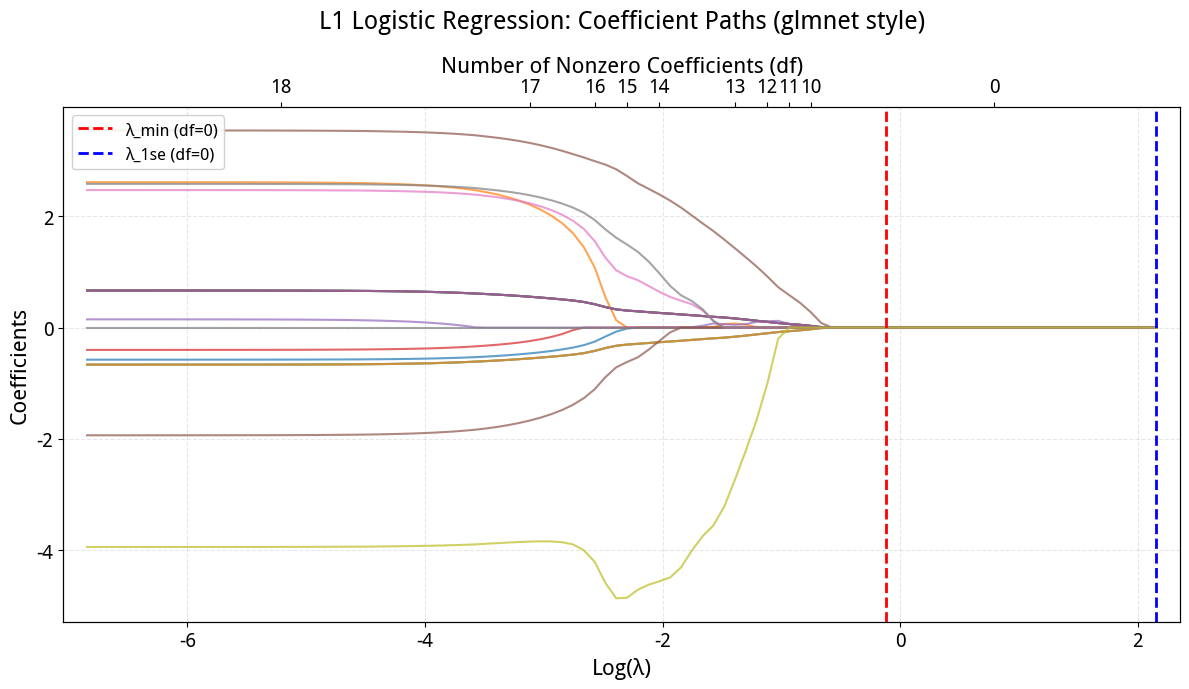


✓ 系数路径图已保存: /home/phl/PHL/Car-T/model_v1/output/feature_selection/l1_logreg_coefficient_paths_glmnet_style.png


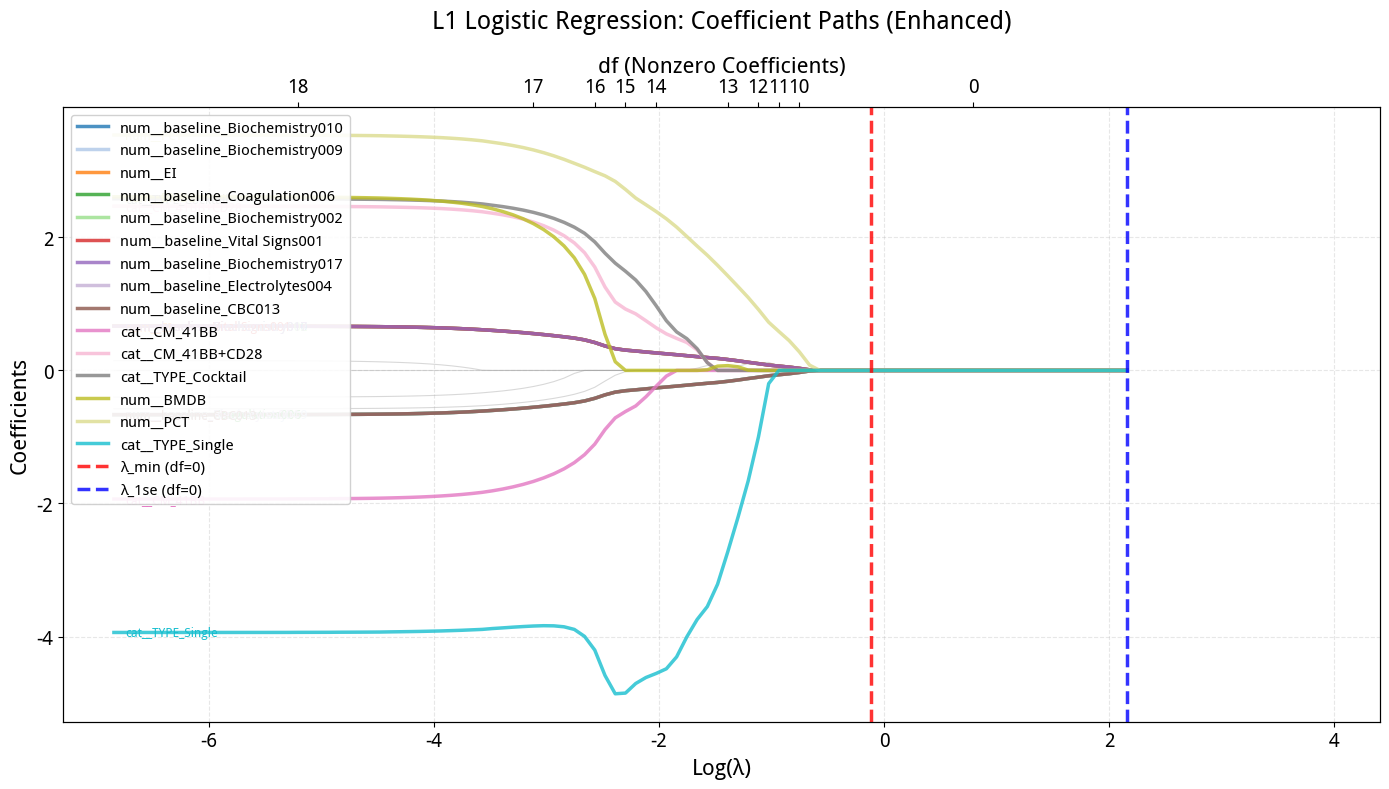

✓ 增强版系数路径图已保存: /home/phl/PHL/Car-T/model_v1/output/feature_selection/l1_logreg_coefficient_paths_enhanced.png



In [73]:
# =============================================================================
# R glmnet 风格：L1 逻辑回归系数路径图（双 X 轴）
# =============================================================================
# 绘制 L1 逻辑回归的系数路径图
# - 底部 X 轴：log(λ)
# - 顶部 X 轴：df (非零系数数量)
# - Y 轴：系数值
# =============================================================================

print("=" * 80)
print("绘制 L1 逻辑回归系数路径图")
print("=" * 80)

# ---------- 1. 计算不同 λ 下的系数路径 ----------
coefs_lr = []
n_nonzero_lr = []

print(f"\n正在计算 {len(C_RANGE_CV)} 个不同 λ 值下的系数...")

for i, (C_val, lambda_val) in enumerate(zip(C_RANGE_CV, LAMBDA_RANGE_CV)):
    lr = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=C_val,
        max_iter=5000,
        warm_start=True,    # 可选：路径计算像glmnet 一样使用 coordinate descent 的 warm start，让路径：更平滑、df 更单调、数值更稳定
        random_state=42
    )
    lr.fit(X_train_df, y_train)
    coefs_lr.append(lr.coef_[0])
    n_nonzero_lr.append(np.sum(lr.coef_[0] != 0))
    
    if (i + 1) % 10 == 0:
        print(f"  进度: {i+1}/{len(C_RANGE_CV)}")

coefs_lr = np.array(coefs_lr)  # shape: (n_lambdas, n_features)
n_nonzero_lr = np.array(n_nonzero_lr)

# =============================================================================
# 统一 λ 顺序：λ 从大 → 小（glmnet 风格）
# =============================================================================

# 获取排序索引（按 lambda 降序）
lambda_order = np.argsort(LAMBDA_RANGE_CV)[::-1]

# 对所有与 λ 相关的数组统一重排
log_lambdas_lr = log_lambdas_lr[lambda_order]
coefs_lr = coefs_lr[lambda_order, :]
n_nonzero_lr = n_nonzero_lr[lambda_order]
# =============================================================================

print(f"✓ 系数计算完成")
print(f"  特征数量: {coefs_lr.shape[1]}")
print(f"  非零系数范围: [{n_nonzero_lr.min()}, {n_nonzero_lr.max()}]")

# ---------- 2. 绘制系数路径图 ----------
fig, ax1 = plt.subplots(figsize=(12, 7))

# 绘制系数路径
for i in range(coefs_lr.shape[1]):
    ax1.plot(log_lambdas_lr, coefs_lr[:, i], linewidth=1.5, alpha=0.7)

# 绘制 λ_min 和 λ_1se 垂直虚线
ax1.axvline(log_lambda_min_lr, linestyle='--', color='red', linewidth=2,
            label=f'λ_min (df={df_at_lambda_min})', zorder=10)
ax1.axvline(log_lambda_1se_lr, linestyle='--', color='blue', linewidth=2,
            label=f'λ_1se (df={df_at_lambda_1se})', zorder=10)

# 底部 X 轴设置
ax1.set_xlabel('Log(λ)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Coefficients', fontsize=16, fontweight='bold')
# ax1.set_xlim(-6, 11)  # 设置 X 轴范围为 (-6, 1)
ax1.set_xlim(log_lambdas_lr.min() - 0.2, log_lambdas_lr.max() + 0.2)  # 根据数据范围自动设置，并留出边距
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper left', fontsize=12, framealpha=0.9)

# ---------- 3. 创建顶部 X 轴（显示 df）----------
ax2 = ax1.twiny()

# 选择 df 刻度
unique_dfs_coef = np.unique(n_nonzero_lr)[::-1]
if len(unique_dfs_coef) > 12:
    step = max(1, len(unique_dfs_coef) // 12)
    selected_dfs_coef = unique_dfs_coef[::step]
else:
    selected_dfs_coef = unique_dfs_coef

# 计算刻度位置
df_positions_coef = []
df_labels_coef = []
for df in selected_dfs_coef:
    idx = np.where(n_nonzero_lr == df)[0]
    if len(idx) > 0:
        mid_idx = idx[len(idx) // 2]
        df_positions_coef.append(log_lambdas_lr[mid_idx])
        df_labels_coef.append(str(int(df)))

# 设置顶部 X 轴
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(df_positions_coef)
ax2.set_xticklabels(df_labels_coef)
ax2.set_xlabel('Number of Nonzero Coefficients (df)', fontsize=16, fontweight='bold')
ax2.tick_params(axis='x', which='major', labelsize=14)

# 标题
plt.title('L1 Logistic Regression: Coefficient Paths (glmnet style)', 
          fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'l1_logreg_coefficient_paths_glmnet_style.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ 系数路径图已保存: {output_dir}/l1_logreg_coefficient_paths_glmnet_style.png")

# =============================================================================
# 增强版：高亮重要特征
# =============================================================================
from matplotlib.cm import get_cmap

# 选择重要特征（按最大绝对系数）
max_abs_coef_lr = np.max(np.abs(coefs_lr), axis=0)
n_top_features = min(15, np.sum(max_abs_coef_lr > 0))
top_feature_indices = np.argsort(max_abs_coef_lr)[-n_top_features:]

# 颜色映射
cmap = get_cmap('tab20') if n_top_features > 10 else get_cmap('tab10')
colors = [cmap(i / n_top_features) for i in range(n_top_features)]

fig, ax1 = plt.subplots(figsize=(14, 8))

# 绘制背景特征（灰色）
for i in range(coefs_lr.shape[1]):
    if i not in top_feature_indices:
        ax1.plot(log_lambdas_lr, coefs_lr[:, i], 
                color='gray', linewidth=0.8, alpha=0.3, zorder=1)

# 绘制重要特征（彩色）
for idx, feature_idx in enumerate(top_feature_indices):
    line, = ax1.plot(log_lambdas_lr, coefs_lr[:, feature_idx], 
                     color=colors[idx], linewidth=2.5, alpha=0.8, zorder=2,
                     label=feature_names[feature_idx])
    
    # 在路径末端添加标签
    final_coef = coefs_lr[-1, feature_idx]
    if abs(final_coef) > 1e-6:
        ax1.text(log_lambdas_lr[-1] + 0.1, final_coef, 
                feature_names[feature_idx], 
                fontsize=9, color=colors[idx], 
                va='center', fontweight='bold')

# 绘制 λ_min 和 λ_1se
ax1.axvline(log_lambda_min_lr, linestyle='--', color='red', linewidth=2.5,
            label=f'λ_min (df={df_at_lambda_min})', zorder=10, alpha=0.8)
ax1.axvline(log_lambda_1se_lr, linestyle='--', color='blue', linewidth=2.5,
            label=f'λ_1se (df={df_at_lambda_1se})', zorder=10, alpha=0.8)

# 底部 X 轴
ax1.set_xlabel('Log(λ)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Coefficients', fontsize=16, fontweight='bold')
# ax1.set_xlim(-6, -1)  # 设置 X 轴范围为 (-6, 1)
ax1.set_xlim(log_lambdas_lr.min() - 0.2, log_lambdas_lr.max() + 0.2)  # 根据数据范围自动设置，并留出边距
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.grid(True, alpha=0.3, linestyle='--')

# 设置 X 轴范围，为右侧标签留空间
x_range = log_lambdas_lr.max() - log_lambdas_lr.min()
ax1.set_xlim(log_lambdas_lr.min() - 0.05 * x_range, 
             log_lambdas_lr.max() + 0.25 * x_range)

# 图例（仅显示 λ_min 和 λ_1se）
ax1.legend(loc='upper left', fontsize=11, framealpha=0.9)

# 顶部 X 轴
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(df_positions_coef)
ax2.set_xticklabels(df_labels_coef)
ax2.set_xlabel('df (Nonzero Coefficients)', fontsize=16, fontweight='bold')
ax2.tick_params(axis='x', which='major', labelsize=14)

plt.title('L1 Logistic Regression: Coefficient Paths (Enhanced)', 
          fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'l1_logreg_coefficient_paths_enhanced.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 增强版系数路径图已保存: {output_dir}/l1_logreg_coefficient_paths_enhanced.png")

print("\n" + "=" * 80)

# Borutashap

- 代码链接：https://github.com/Ekeany/Boruta-Shap/tree/master
- 对应含义：https://blog.csdn.net/gitblog_00754/article/details/155299350

In [74]:
# # =============================================================================
# # 模块 5_Borutashap: Using Shap and Boruta for Feature Selection————报错不成功
# # =============================================================================
# # 作用：结合 Boruta 的影子特征思想和 SHAP 值的特征重要性评估
# # 方法：BorutaShap (比传统 BorutaPy 更快且通常更准确)
# # 输入：X_train_df, y_train
# # 输出：BorutaShap 选择的特征子集
# # =============================================================================
# # ----------------- 修复 Scipy 和 NumPy 报错开始 -----------------
# import scipy.stats
# import numpy as np
# import warnings

# # 修复 NumPy 2.0 报错: module 'numpy' has no attribute 'NaN', 'int', 'float'
# if not hasattr(np, 'NaN'):
#     np.NaN = np.nan
# if not hasattr(np, 'int'):
#     np.int = int
# if not hasattr(np, 'float'):
#     np.float = float
# if not hasattr(np, 'bool'):
#     np.bool = bool

# # 修复 Scipy 报错: cannot import name 'binom_test' from 'scipy.stats'
# if not hasattr(scipy.stats, 'binom_test'):
#     def binom_test_wrapper(x, n=None, p=0.5, alternative='two-sided'):
#         from scipy.stats import binomtest
#         if n is None or n == 0:
#             return 1.0 
#         return binomtest(k=x, n=n, p=p, alternative=alternative).pvalue
#     scipy.stats.binom_test = binom_test_wrapper
# # ----------------- 修复 Scipy 和 NumPy 报错结束 -----------------

# # pip install BorutaShap==1.0.17
# from BorutaShap import BorutaShap
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# print("=" * 80)
# print("模块 5 (Alternative): BorutaShap 特征选择")
# print("=" * 80)

# # 1. 准备数据 (使用项目中实际的训练数据)
# # 务必重置索引，防止 BorutaShap 内部 concat 时因索引不匹配产生维度错误
# X_borutashap = X_train_df.copy().reset_index(drop=True)

# # 确保 y 也是重置索引后的 Series，保证行对齐
# if isinstance(y_train, (pd.Series, pd.DataFrame)):
#     y_borutashap = y_train.copy().reset_index(drop=True)
# else:
#     y_borutashap = pd.Series(y_train).reset_index(drop=True)

# # 确保所有特征名为字符串，且无重复
# # 必须先处理列名重复，BorutaShap 对重复列名非常敏感
# if X_borutashap.columns.duplicated().any():
#     print(f"⚠️ 检测到 {X_borutashap.columns.duplicated().sum()} 个重复列名，正在去重...")
#     X_borutashap = X_borutashap.loc[:, ~X_borutashap.columns.duplicated()]

# print(f"输入数据形状: {X_borutashap.shape}")
# print(f"标签形状: {y_borutashap.shape}")

# # 2. 初始化 Feature Selector
# Feature_Selector = BorutaShap(importance_measure='shap',
#                               classification=True)

# # 3. 执行特征选择
# print("\n正在运行 BorutaShap 算法...")

# Feature_Selector.fit(X=X_borutashap, y=y_borutashap, 
#                         n_trials=100, 
#                         sample=False,        # 数据量不大时设为 False 以提高精度
#                         verbose=True)


# # 4. 可视化结果
# print("\n生成 BorutaShap 特征重要性箱线图...")
# try:
#     Feature_Selector.plot(which_features='all')
# except Exception as e:
#     print(f"⚠️ BorutaShap 自带 plot() 报错: {e}。正在尝试使用自定义代码绘图...")
    
#     # 自定义备用绘图逻辑
#     if hasattr(Feature_Selector, 'history_x'):
#         history = Feature_Selector.history_x.iloc[1:, :] 
        
#         accepted = list(Feature_Selector.accepted)
#         tentative = list(Feature_Selector.tentative)
#         rejected = list(Feature_Selector.rejected)
        
#         if history.shape[1] == len(X_borutashap.columns) + 3: 
#                 col_names = list(X_borutashap.columns) + ['Max_Shadow', 'Mean_Shadow', 'Min_Shadow']
#                 history.columns = col_names
        
#         # 仅展示 Accepted, Tentative 和 Top 10 Rejected
#         features_to_plot = accepted + tentative + rejected[:10]
        
#         data_plot = []
#         labels_plot = []
#         colors_plot = []
        
#         for f in features_to_plot:
#             if f in history.columns:
#                 data_plot.append(history[f].values)
#                 labels_plot.append(f)
#                 if f in accepted: colors_plot.append('green')
#                 elif f in tentative: colors_plot.append('orange')
#                 else: colors_plot.append('red')
        
#         for shadow in ['Max_Shadow', 'Mean_Shadow', 'Min_Shadow']:
#             if shadow in history.columns:
#                 data_plot.append(history[shadow].values)
#                 labels_plot.append(shadow)
#                 colors_plot.append('blue')

#         if data_plot:
#             plt.figure(figsize=(12, max(6, len(labels_plot) * 0.3)))
#             bp = plt.boxplot(data_plot, patch_artist=True, vert=False, labels=labels_plot)
#             for patch, color in zip(bp['boxes'], colors_plot):
#                 patch.set_facecolor(color)
#                 patch.set_alpha(0.6)
#             plt.title('BorutaShap Feature Importance (Custom Plot)')
#             plt.xlabel('SHAP Importance')
#             plt.tight_layout()
#             plt.show()
#             print("✅ 自定义绘图成功")

# # 5. 获取结果
# subset = Feature_Selector.Subset()
# borutashap_selected = subset.columns.tolist()

# print("\n" + "=" * 80)
# print("BorutaShap 特征选择结果")
# print("=" * 80)
# print(f"选中特征数 (Confirmed): {len(borutashap_selected)}")
# print(f"特征列表: {borutashap_selected}")
# print(f"剔除特征数 (Rejected): {len(Feature_Selector.rejected)}")
# print(f"待定特征数 (Tentative): {len(Feature_Selector.tentative)}")

# # 保存结果
# borutashap_results = pd.DataFrame({
#     'Feature': X_borutashap.columns,
#     'Status': ['Accepted' if f in Feature_Selector.accepted else 
#                'Tentative' if f in Feature_Selector.tentative else 'Rejected' 
#                for f in X_borutashap.columns]
# })

# output_dir_bs = '/home/phl/PHL/Car-T/model_v1/output/feature_selection'
# import os
# if not os.path.exists(output_dir_bs):
#     os.makedirs(output_dir_bs)

# borutashap_results.to_csv(f"{output_dir_bs}/borutashap_results.csv", index=False)
# print(f"\n结果已保存至: {output_dir_bs}/borutashap_results.csv")

模块 5: Boruta 算法特征选择

配置参数:
  - Boruta 迭代次数: 20
  - 每次最大迭代: 150
  - 随机森林深度: 15
  - 稳定性阈值: 0.5 (50%)
  - 至少需要选中: 10 次

数据准备:
  - 训练数据形状: (7, 19)
  - 特征数量: 19
  - 标签分布: {np.int64(0): np.int64(3), np.int64(1): np.int64(4)}

--------------------------------------------------------------------------------
步骤 5.1: 单次 Boruta 运行
--------------------------------------------------------------------------------
正在运行 Boruta 算法...
Iteration: 	1 / 150
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 150
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 150
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 150
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 150
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 150
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 150
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 150
Confirmed: 	0
Tentative: 	3
Rejected: 	16
Iteration: 	9 / 150
Confirmed: 	0
Tentative: 	3
Rejected: 	16
Iteration: 	10 / 150


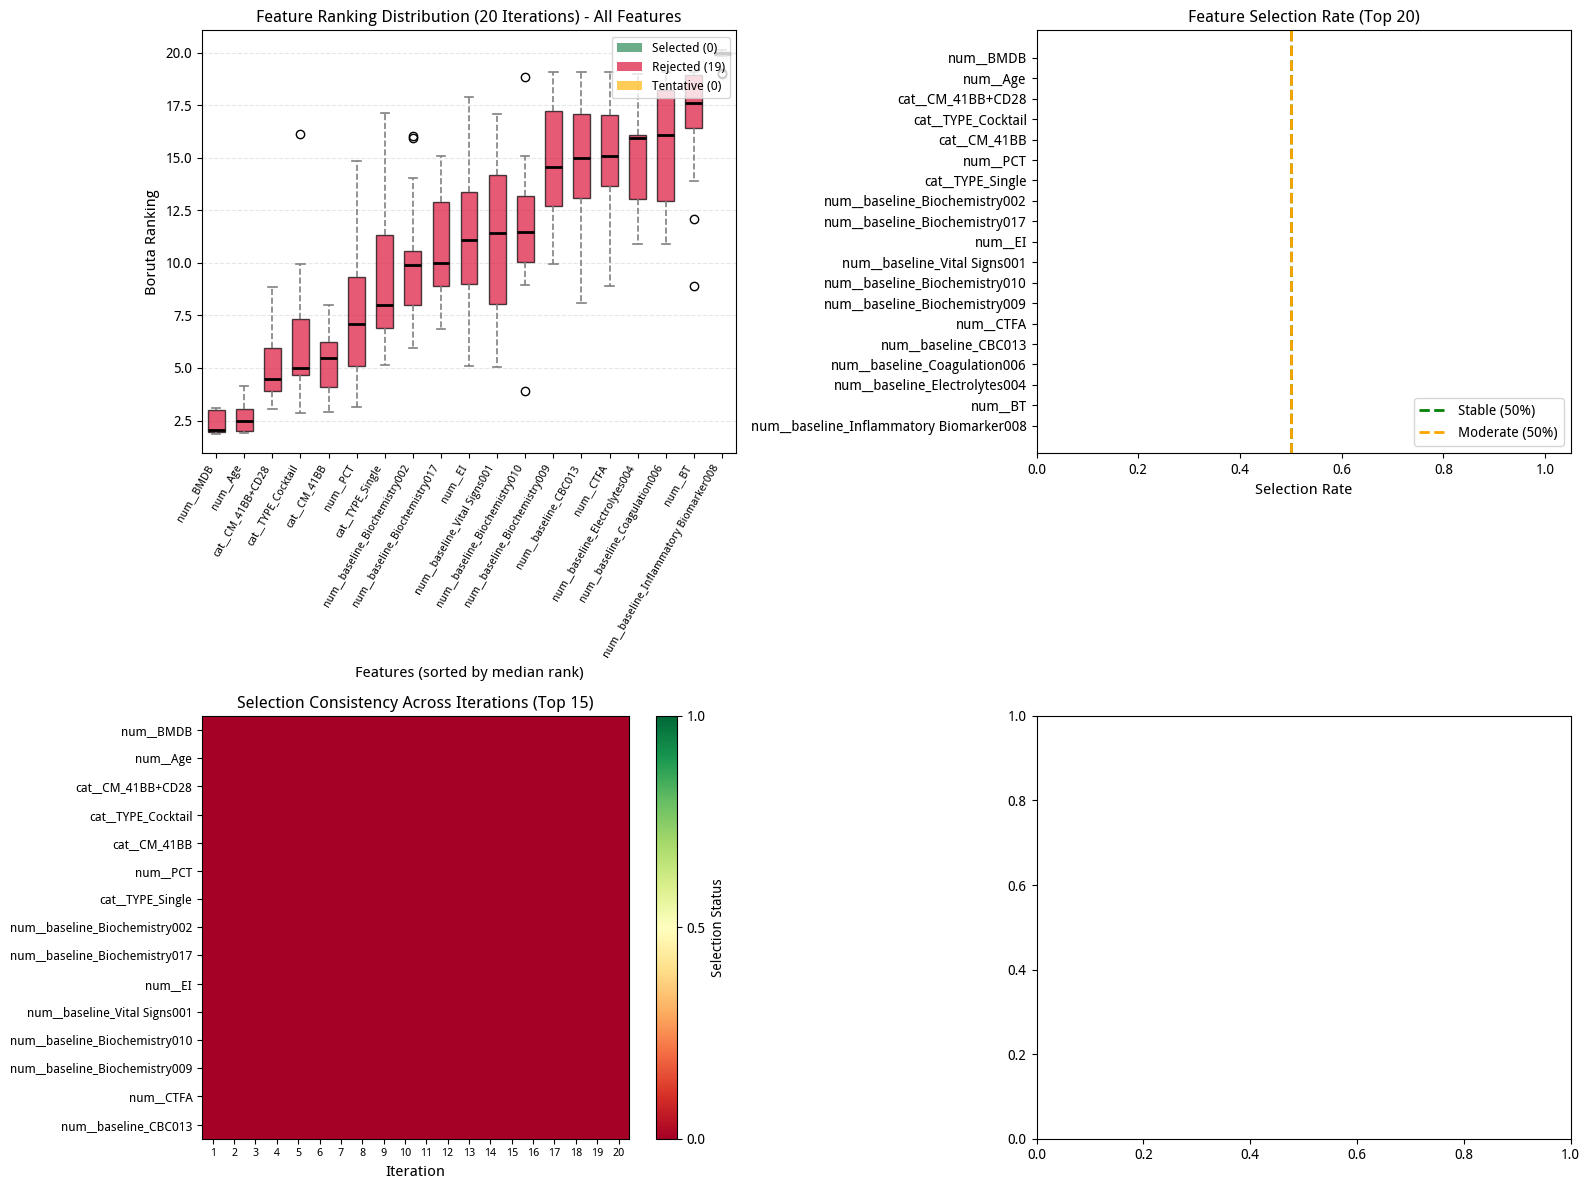


Boruta 特征选择总结

 所有结果已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_selection
   - boruta_single_run_results.csv
   - boruta_stability_results.csv
   - boruta_ranking_matrix.csv
   - boruta_selected_features.json
   - boruta_stability_analysis.png


In [75]:
# =============================================================================
# 模块 5: Boruta 算法特征选择 (含稳定性评估)
# =============================================================================
# 作用：基于随机森林的特征选择算法，通过与影子特征对比识别重要特征
# 方法：多次运行 Boruta 以评估特征选择的稳定性
# 输入：X_train, y_train, preprocessor (来自第13个单元格), feature_names (来自模块 1)
# 输出：stability_df (稳定性分析), stable_selected (稳定特征列表)
# 说明：Boruta 通过创建影子特征（随机打乱的原始特征）作为基准，选择比影子特征更重要的原始特征
# =============================================================================

# pip install borutashap==1.0.17

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# Boruta 配置（已优化）
# ------------------------------------------------------------------------------
# N_BORUTA_ITERATIONS 说明：
#   - 用于评估特征选择的稳定性，建议至少 5-10 次
#   - 迭代次数越多，稳定性评估越可靠，但计算时间越长
#   - 推荐值：小数据集 5-10 次，大数据集 10-20 次
N_BORUTA_ITERATIONS = 20     # 从 2 改为 10

# BORUTA_MAX_ITER 说明：
#   - 每次 Boruta 运行的最大迭代次数
#   - 如果特征较多或数据复杂，建议增加到 150-200
BORUTA_MAX_ITER = 150         # 从 100 改为 150（增加收敛机会）

# RF_MAX_DEPTH 说明：
#   - 随机森林的最大深度，影响模型复杂度
#   - 太浅（如 深度为 5）的随机森林可能无法充分捕捉特征的重要性，特别是对于复杂的医疗数据
#   - 太深可能过拟合，建议 7-15 之间
#   - None 表示不限制深度（对小数据集可能过拟合）
RF_MAX_DEPTH = 15             # 从 5 改为 10（增加模型表达能力）

RF_N_JOBS = -1                # 并行计算

# STABILITY_THRESHOLD 说明：
#   - 特征在多次运行中的最低选中率，才被认为是"稳定选中"
#   - 0.8 = 80%，表示必须在 80% 的迭代中被选中
#   - 对于 N_BORUTA_ITERATIONS = 10，需要至少 8 次选中
#   - 对于 N_BORUTA_ITERATIONS = 2，需要 2 次都选中（100%），这太严格了！
#   - 推荐值：0.6-0.8 之间，视数据稳定性而定
STABILITY_THRESHOLD = 0.5     # 从 0.8 改为 0.6（更宽松的阈值）
# ------------------------------------------------------------------------------

print("=" * 80)
print("模块 5: Boruta 算法特征选择")
print("=" * 80)
print(f"\n配置参数:")
print(f"  - Boruta 迭代次数: {N_BORUTA_ITERATIONS}")
print(f"  - 每次最大迭代: {BORUTA_MAX_ITER}")
print(f"  - 随机森林深度: {RF_MAX_DEPTH}")
print(f"  - 稳定性阈值: {STABILITY_THRESHOLD} ({STABILITY_THRESHOLD*100:.0f}%)")
print(f"  - 至少需要选中: {int(N_BORUTA_ITERATIONS * STABILITY_THRESHOLD)} 次")

# 准备数据：复用模块 1 的预处理结果
X_boruta = np.array(X_train_df)
y_boruta = np.array(y_train).ravel()

print(f"\n数据准备:")
print(f"  - 训练数据形状: {X_boruta.shape}")
print(f"  - 特征数量: {len(feature_names)}")
print(f"  - 标签分布: {dict(zip(*np.unique(y_boruta, return_counts=True)))}")

# =============================================================================
# 步骤 1: 单次 Boruta 运行（基准结果）
# =============================================================================
print("\n" + "-" * 80)
print("步骤 5.1: 单次 Boruta 运行")
print("-" * 80)

# 初始化随机森林
rf_base = RandomForestClassifier(
    n_jobs=RF_N_JOBS,
    class_weight='balanced',
    max_depth=RF_MAX_DEPTH,
    random_state=42
)

boruta_base = BorutaPy(
    rf_base,
    n_estimators='auto',
    verbose=2,
    random_state=42,
    max_iter=BORUTA_MAX_ITER
)

print("正在运行 Boruta 算法...")
boruta_base.fit(X_boruta, y_boruta)

# 提取结果
selected_features = [feature_names[i] for i in range(len(feature_names)) if boruta_base.support_[i]]
rejected_features = [feature_names[i] for i in range(len(feature_names)) if not boruta_base.support_[i] and not boruta_base.support_weak_[i]]
tentative_features = [feature_names[i] for i in range(len(feature_names)) if boruta_base.support_weak_[i]]

print(f"\n单次运行结果:")
print(f"选中特征 (Confirmed): {len(selected_features)} 个")
print(f"待定特征 (Tentative): {len(tentative_features)} 个")
print(f"剔除特征 (Rejected): {len(rejected_features)} 个")

print(f"\n 选中的特征:")
for f in selected_features:
    print(f"  - {f}")

if tentative_features:
    print(f"\n 待定特征 (需进一步评估):")
    for f in tentative_features:
        print(f"  - {f}")

# 保存单次结果
single_run_df = pd.DataFrame({
    'Feature': feature_names,
    'Rank': boruta_base.ranking_,
    'Selected': boruta_base.support_,
    'Tentative': boruta_base.support_weak_
})
single_run_df = single_run_df.sort_values('Rank').reset_index(drop=True)
single_run_df.to_csv(f"{output_dir}/boruta_single_run_results.csv", index=False)

# =============================================================================
# 步骤 2: 多次运行 Boruta 评估稳定性
# =============================================================================
print("\n" + "-" * 80)
print(f"步骤 5.2: 多次运行 Boruta ({N_BORUTA_ITERATIONS} 次迭代)")
print("-" * 80)

# 存储每次运行的排名
ranking_matrix = pd.DataFrame(index=range(1, N_BORUTA_ITERATIONS + 1), columns=feature_names)
selection_matrix = pd.DataFrame(index=range(1, N_BORUTA_ITERATIONS + 1), columns=feature_names)

for i in range(N_BORUTA_ITERATIONS):
    print(f"  迭代 {i+1}/{N_BORUTA_ITERATIONS}...", end=" ")
    
    # 每次使用不同的随机种子
    rf_iter = RandomForestClassifier(
        n_jobs=RF_N_JOBS,
        class_weight='balanced',
        max_depth=RF_MAX_DEPTH,
        random_state=i
    )
    
    boruta_iter = BorutaPy(
        rf_iter,
        n_estimators='auto',
        verbose=0,    # 静默模式
        random_state=i,
        max_iter=BORUTA_MAX_ITER
    )
    
    boruta_iter.fit(X_boruta, y_boruta)
    
    # 记录排名
    ranking_matrix.loc[i+1] = boruta_iter.ranking_
    
    # 记录选择状态 (1=选中, 0.5=待定, 0=剔除)
    selection_status = np.zeros(len(feature_names))
    selection_status[boruta_iter.support_] = 1
    selection_status[boruta_iter.support_weak_] = 0.5
    selection_matrix.loc[i+1] = selection_status
    
    print(f"选中 {boruta_iter.support_.sum()} 个特征")

print(f"\n多次运行完成!")

# =============================================================================
# 步骤 3: 计算稳定性指标
# =============================================================================
print("\n" + "-" * 80)
print("步骤 5.3: 计算特征选择稳定性")
print("-" * 80)

# 转换为数值型
ranking_matrix = ranking_matrix.apply(pd.to_numeric, errors='coerce')
selection_matrix = selection_matrix.apply(pd.to_numeric, errors='coerce')

# 计算统计指标
stability_df = pd.DataFrame({
    'Feature': feature_names,
    'Median_Rank': ranking_matrix.median(),
    'Mean_Rank': ranking_matrix.mean(),
    'Std_Rank': ranking_matrix.std(),
    'Min_Rank': ranking_matrix.min(),
    'Max_Rank': ranking_matrix.max(),
    'Selection_Rate': (selection_matrix == 1).sum() / N_BORUTA_ITERATIONS,
    'Tentative_Rate': (selection_matrix == 0.5).sum() / N_BORUTA_ITERATIONS,
    'Rejection_Rate': (selection_matrix == 0).sum() / N_BORUTA_ITERATIONS
})

# 按中位数排名排序
stability_df = stability_df.sort_values('Median_Rank').reset_index(drop=True)

# 分类特征稳定性（使用新的阈值）
stable_selected = stability_df[stability_df['Selection_Rate'] >= STABILITY_THRESHOLD]['Feature'].tolist()
unstable_features = stability_df[(stability_df['Selection_Rate'] > 0) & (stability_df['Selection_Rate'] < STABILITY_THRESHOLD)]['Feature'].tolist()
stable_rejected = stability_df[stability_df['Rejection_Rate'] >= STABILITY_THRESHOLD]['Feature'].tolist()

print(f"\n特征稳定性分析:")
print(f"稳定选中 (≥{STABILITY_THRESHOLD:.0%} 选中率): {len(stable_selected)} 个")
print(f"不稳定特征 (选中率 0-{STABILITY_THRESHOLD:.0%}): {len(unstable_features)} 个")
print(f"稳定剔除 (≥{STABILITY_THRESHOLD:.0%} 剔除率): {len(stable_rejected)} 个")

print(f"\n 稳定选中的特征:")
for f in stable_selected:
    rate = stability_df[stability_df['Feature'] == f]['Selection_Rate'].values[0]
    print(f"  - {f} (选中率: {rate:.0%})")

if len(stable_selected) == 0:
    print("\n⚠ 警告：没有特征满足稳定性阈值！")
    print(f"  建议：")
    print(f"  1. 降低 STABILITY_THRESHOLD (当前 {STABILITY_THRESHOLD})")
    print(f"  2. 增加 N_BORUTA_ITERATIONS (当前 {N_BORUTA_ITERATIONS})")
    print(f"  3. 增加 RF_MAX_DEPTH (当前 {RF_MAX_DEPTH})")
    print(f"  4. 检查单次运行结果，查看是否有特征被选中")
    
# 保存稳定性结果
stability_df.to_csv(f"{output_dir}/boruta_stability_results.csv", index=False)
ranking_matrix.to_csv(f"{output_dir}/boruta_ranking_matrix.csv")

# 输出结果摘要
print("\n" + "=" * 80)
print("Boruta 特征选择结果摘要")
print("=" * 80)
print(f"单次运行选中: {len(selected_features)} 个")
print(f"稳定选中 (≥{STABILITY_THRESHOLD:.0%}): {len(stable_selected)} 个")
print(f"不稳定特征: {len(unstable_features)} 个")

# 保存特征集
boruta_feature_sets = {
    'boruta_confirmed': selected_features,
    'boruta_tentative': tentative_features,
    'boruta_stable_selected': stable_selected,
    'boruta_unstable': unstable_features
}

import json
with open(f"{output_dir}/boruta_selected_features.json", 'w') as f:
    json.dump(boruta_feature_sets, f, indent=2)

print(f"\n结果已保存至: {output_dir}")

print("\n可用变量:")
print("  - boruta_base: 单次 Boruta 模型")
print("  - stability_df: 稳定性分析 DataFrame")
print("  - stable_selected: 稳定选中的特征列表")
print("  - selected_features: 单次运行选中的特征列表")
print("  - ranking_matrix: 排名矩阵")
print("  - selection_matrix: 选择状态矩阵")

# =============================================================================
# 5. 可视化
# =============================================================================
print("\n步骤 5: 生成可视化")
print("-" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# # --- 图1: 排名分布箱线图 (Top 20 特征) ---
# ax1 = axes[0, 0]
# # 按中位数排名取 Top 20
# top_features_for_plot = stability_df.head(20)['Feature'].tolist()
# plot_data = ranking_matrix[top_features_for_plot]

# # 重新排序列（按中位数）
# median_order = plot_data.median().sort_values().index
# plot_data = plot_data[median_order]

# sns.boxplot(data=plot_data, ax=ax1, palette="Greens_r")
# ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=9)
# ax1.set_xlabel('Features', fontsize=11)
# ax1.set_ylabel('Boruta Ranking', fontsize=11)
# ax1.set_title(f'Feature Ranking Distribution ({N_BORUTA_ITERATIONS} Iterations) - Top 20', fontsize=12)
# ax1.grid(axis='y', alpha=0.3)

# --- 图1: 排名分布箱线图 (全部特征，按中位数排序) ---
ax1 = axes[0, 0]

# 数据处理：添加随机抖动避免重叠
df_jittered = ranking_matrix.apply(pd.to_numeric, errors='coerce').add(
    np.random.uniform(-0.15, 0.15, ranking_matrix.shape)
)

# 按中位数排序特征
sorted_cols = df_jittered.median().sort_values().index

# 颜色映射：根据特征选择状态分配颜色
color_map = {}
color_map.update(dict(zip(selected_features, ["#2E8B57"] * len(selected_features))))      # 绿色：选中
color_map.update(dict(zip(rejected_features, ["#DC143C"] * len(rejected_features))))      # 红色：剔除
color_map.update(dict(zip(tentative_features, ["#FFB90F"] * len(tentative_features))))    # 橙色：待定

# 准备箱线图数据
box_data = [df_jittered[col].dropna() for col in sorted_cols]

# 绘制箱线图
bp = ax1.boxplot(box_data, patch_artist=True, widths=0.6)

# 设置箱体颜色
for patch, col in zip(bp['boxes'], sorted_cols):
    patch.set_facecolor(color_map.get(col, 'grey'))
    patch.set_alpha(0.7)

# 设置其他箱线图元素样式
for whisker in bp['whiskers']:
    whisker.set(linewidth=1.2, linestyle='--', color='gray')
for cap in bp['caps']:
    cap.set(linewidth=1.2, color='gray')
for median in bp['medians']:
    median.set(linewidth=2, color='black')

# 设置坐标轴标签
ax1.set_xticks(range(1, len(sorted_cols) + 1))
ax1.set_xticklabels(sorted_cols, rotation=60, ha='right', fontsize=8)
ax1.set_xlabel('Features (sorted by median rank)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Boruta Ranking', fontsize=11, fontweight='bold')
ax1.set_title(f'Feature Ranking Distribution ({N_BORUTA_ITERATIONS} Iterations) - All Features', 
              fontsize=12, fontweight='bold')

# 添加图例
from matplotlib.patches import Rectangle
legend_elements = [
    Rectangle((0, 0), 1, 1, facecolor='#2E8B57', alpha=0.7, label=f'Selected ({len(selected_features)})'),
    Rectangle((0, 0), 1, 1, facecolor='#DC143C', alpha=0.7, label=f'Rejected ({len(rejected_features)})'),
    Rectangle((0, 0), 1, 1, facecolor='#FFB90F', alpha=0.7, label=f'Tentative ({len(tentative_features)})')
]
ax1.legend(handles=legend_elements, loc='upper right', fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# 保存图1为单独文件
fig1 = ax1.get_figure()
fig1_single = plt.figure(figsize=(15, 6))
ax1_single = fig1_single.add_subplot(111)

# 重新绘制图1内容
bp_single = ax1_single.boxplot(box_data, patch_artist=True, widths=0.6)
for patch, col in zip(bp_single['boxes'], sorted_cols):
    patch.set_facecolor(color_map.get(col, 'grey'))
    patch.set_alpha(0.7)
for whisker in bp_single['whiskers']:
    whisker.set(linewidth=1.2, linestyle='--', color='gray')
for cap in bp_single['caps']:
    cap.set(linewidth=1.2, color='gray')
for median in bp_single['medians']:
    median.set(linewidth=2, color='black')
ax1_single.set_xticks(range(1, len(sorted_cols) + 1))
ax1_single.set_xticklabels(sorted_cols, rotation=60, ha='right', fontsize=8)
ax1_single.set_xlabel('Features (sorted by median rank)', fontsize=11, fontweight='bold')
ax1_single.set_ylabel('Boruta Ranking', fontsize=11, fontweight='bold')
ax1_single.set_title(f'Feature Ranking Distribution ({N_BORUTA_ITERATIONS} Iterations) - All Features', 
                     fontsize=12, fontweight='bold')
ax1_single.legend(handles=legend_elements, loc='upper right', fontsize=9)
ax1_single.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plot1_path = f"{output_dir}/boruta_ranking_boxplot.png"
fig1_single.savefig(plot1_path, dpi=300, bbox_inches='tight')
plt.close(fig1_single)
print(f"图1已保存至: {plot1_path}")

# --- 图2: 选中率条形图 ---
ax2 = axes[0, 1]
top_selection = stability_df.sort_values('Selection_Rate', ascending=False).head(20)
colors = ['#2ecc71' if r >= STABILITY_THRESHOLD else '#f39c12' if r >= 0.5 else '#e74c3c' 
          for r in top_selection['Selection_Rate']]
bars = ax2.barh(top_selection['Feature'], top_selection['Selection_Rate'], color=colors)
ax2.set_xlabel('Selection Rate', fontsize=11)
ax2.set_title('Feature Selection Rate (Top 20)', fontsize=12)
ax2.axvline(x=STABILITY_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Stable ({STABILITY_THRESHOLD:.0%})')
ax2.axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Moderate (50%)')
ax2.legend(loc='lower right')
ax2.set_xlim([0, 1.05])
ax2.invert_yaxis()

# 保存图2为单独文件
fig2_single = plt.figure(figsize=(10, 8))
ax2_single = fig2_single.add_subplot(111)
bars_single = ax2_single.barh(top_selection['Feature'], top_selection['Selection_Rate'], color=colors)
ax2_single.set_xlabel('Selection Rate', fontsize=11)
ax2_single.set_title('Feature Selection Rate (Top 20)', fontsize=12)
ax2_single.axvline(x=STABILITY_THRESHOLD, color='green', linestyle='--', linewidth=2, label=f'Stable ({STABILITY_THRESHOLD:.0%})')
ax2_single.axvline(x=0.5, color='orange', linestyle='--', linewidth=2, label='Moderate (50%)')
ax2_single.legend(loc='lower right')
ax2_single.set_xlim([0, 1.05])
ax2_single.invert_yaxis()
plt.tight_layout()
plot2_path = f"{output_dir}/boruta_selection_rate.png"
fig2_single.savefig(plot2_path, dpi=300, bbox_inches='tight')
plt.close(fig2_single)
print(f"图2已保存至: {plot2_path}")

# --- 图3: 稳定性热力图 ---
ax3 = axes[1, 0]
heatmap_features = stability_df.head(15)['Feature'].tolist()
heatmap_data = selection_matrix[heatmap_features].T

im = ax3.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax3.set_xticks(np.arange(N_BORUTA_ITERATIONS))
ax3.set_xticklabels(range(1, N_BORUTA_ITERATIONS + 1), fontsize=8)
ax3.set_yticks(np.arange(len(heatmap_features)))
ax3.set_yticklabels(heatmap_features, fontsize=9)
ax3.set_xlabel('Iteration', fontsize=11)
ax3.set_title('Selection Consistency Across Iterations (Top 15)', fontsize=12)
plt.colorbar(im, ax=ax3, label='Selection Status', ticks=[0, 0.5, 1])

# 保存图3为单独文件
fig3_single = plt.figure(figsize=(10, 8))
ax3_single = fig3_single.add_subplot(111)
im_single = ax3_single.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax3_single.set_xticks(np.arange(N_BORUTA_ITERATIONS))
ax3_single.set_xticklabels(range(1, N_BORUTA_ITERATIONS + 1), fontsize=8)
ax3_single.set_yticks(np.arange(len(heatmap_features)))
ax3_single.set_yticklabels(heatmap_features, fontsize=9)
ax3_single.set_xlabel('Iteration', fontsize=11)
ax3_single.set_title('Selection Consistency Across Iterations (Top 15)', fontsize=12)
plt.colorbar(im_single, ax=ax3_single, label='Selection Status', ticks=[0, 0.5, 1])
plt.tight_layout()
plot3_path = f"{output_dir}/boruta_consistency_heatmap.png"
fig3_single.savefig(plot3_path, dpi=300, bbox_inches='tight')
plt.close(fig3_single)
print(f"图3已保存至: {plot3_path}")

# 调整布局并保存图表
plt.tight_layout()
plot_path = f"{output_dir}/boruta_stability_analysis.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n Boruta 可视化图表已保存至: {plot_path}")
plt.show()


# =============================================================================
# 6. 输出最终推荐
# =============================================================================
print("\n" + "=" * 80)
print("Boruta 特征选择总结")
print("=" * 80)

# print(f"""
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                        Boruta 特征选择结果                                    ║
# ╠══════════════════════════════════════════════════════════════════════════════╣
# ║  单次运行结果                                                                 ║
# ║  ─────────────────────────────────────────────────────────────────────────── ║
# ║  选中 (Confirmed):     {len(selected_features):>4} 个                                           ║
# ║  待定 (Tentative):     {len(tentative_features):>4} 个                                           ║
# ║  剔除 (Rejected):      {len(rejected_features):>4} 个                                           ║
# ╠══════════════════════════════════════════════════════════════════════════════╣
# ║  稳定性分析 ({N_BORUTA_ITERATIONS} 次迭代)                                                      ║
# ║  ─────────────────────────────────────────────────────────────────────────── ║
# ║  稳定选中 (≥{STABILITY_THRESHOLD:.0%}):      {len(stable_selected):>4} 个                                           ║
# ║  不稳定特征:           {len(unstable_features):>4} 个                                           ║
# ║  稳定剔除 (≥{STABILITY_THRESHOLD:.0%}):      {len(stable_rejected):>4} 个                                           ║
# ╚══════════════════════════════════════════════════════════════════════════════╝
# """)

# 导出 Boruta 选中的特征供后续使用
boruta_feature_sets = {
    'boruta_confirmed': selected_features,
    'boruta_tentative': tentative_features,
    'boruta_stable_selected': stable_selected,
    'boruta_unstable': unstable_features
}

import json
with open(os.path.join(output_dir, 'boruta_selected_features.json'), 'w') as f:
    json.dump(boruta_feature_sets, f, indent=2)

print(f"\n 所有结果已保存至: {output_dir}")
print(f"   - boruta_single_run_results.csv")
print(f"   - boruta_stability_results.csv")
print(f"   - boruta_ranking_matrix.csv")
print(f"   - boruta_selected_features.json")
print(f"   - boruta_stability_analysis.png")


## 方法5:递归特征筛选
递归特征筛选（Recursive Feature Elimination, RFE）是一种常见的特征选择方法，其核心思想是基于模型自带的特征重要性排名，结合设定的步长和最低保留特征数量，对特征集进行逐步递归地筛选。在每次迭代中，根据模型计算的特征贡献度（如基于随机森林的Gini重要性或基于Boosting算法的分裂增益等），剔除一部分排名最低的特征，直到达到设定的最低特征数量或性能平衡点，该方法能够在减少特征数量的同时尽量保持模型性能的稳定性

模块 5.5: 递归特征消除 (RFE) 特征选择

数据准备:
  - 训练集形状: (7, 19)
  - 测试集形状: (3, 19)
  - 特征数量: 19
  - 训练集标签分布: {np.int64(0): np.int64(3), np.int64(1): np.int64(4)}
  - 测试集标签分布: {np.int64(0): np.int64(1), np.int64(1): np.int64(2)}

--------------------------------------------------------------------------------
步骤 5.5.2: 递归特征消除与多模型性能评估
--------------------------------------------------------------------------------

开始执行递归特征消除...
  正在运行 RandomForest...
    ✓ RandomForest 完成 (最高 AUC: 1.0000)
  正在运行 GradientBoosting...
    ✓ GradientBoosting 完成 (最高 AUC: 1.0000)
  正在运行 XGBoost...
    ✓ XGBoost 完成 (最高 AUC: 0.5000)
  正在运行 LightGBM...
    ✓ LightGBM 完成 (最高 AUC: 0.5000)
  正在运行 CatBoost...
    ✓ CatBoost 完成 (最高 AUC: 1.0000)
  正在运行 AdaBoost...
    ✓ AdaBoost 完成 (最高 AUC: 1.0000)

✓ RFE完成，共评估了 19 个特征子集
结果已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_selection/rfe_results.csv

RFE结果概览:
   Number_of_Features  RandomForest  GradientBoosting  XGBoost  LightGBM  CatBoost  AdaBoost
0                   1          

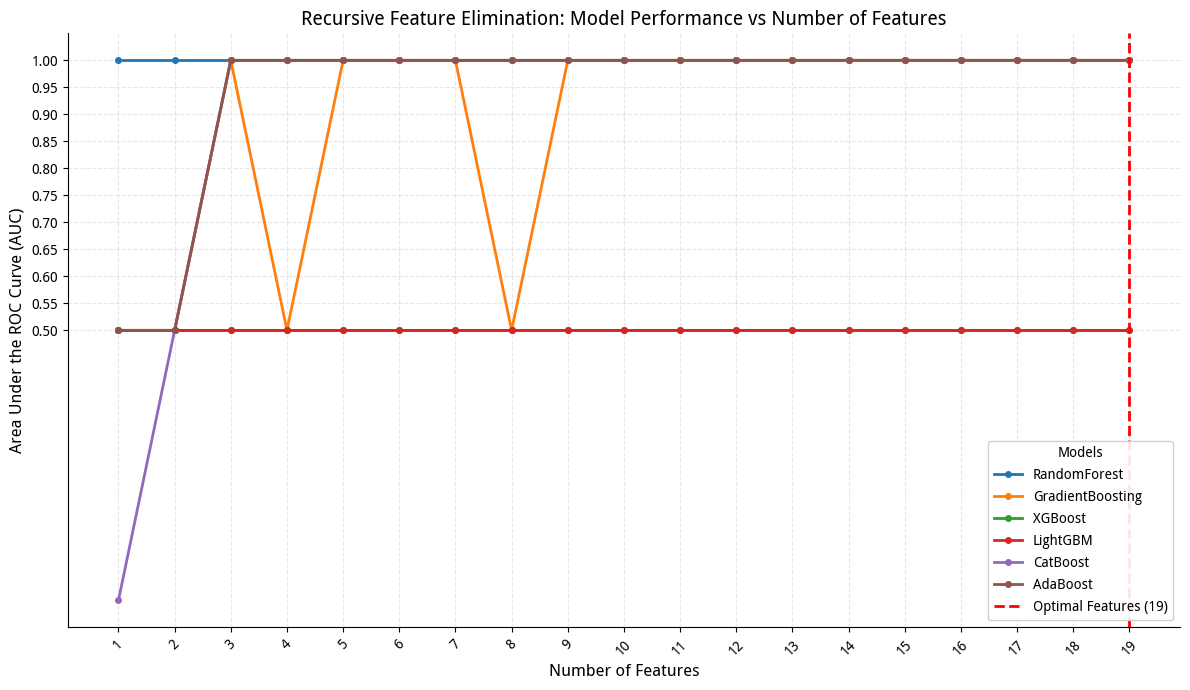


--------------------------------------------------------------------------------
步骤 5.5.4: 确定最佳模型与选择特征
--------------------------------------------------------------------------------

正在为 RandomForest 执行RFE，目标特征数: 19

RandomForest RFE结果:
  - 选中特征数: 19
  - 测试集AUC: 1.0000

RandomForest 选中的 19 个特征:
   1. num__Age
   2. num__BMDB
   3. num__EI
   4. num__BT
   5. num__CTFA
   6. num__PCT
   7. num__baseline_CBC013
   8. num__baseline_Inflammatory Biomarker008
   9. num__baseline_Coagulation006
  10. num__baseline_Electrolytes004
  11. num__baseline_Biochemistry002
  12. num__baseline_Biochemistry009
  13. num__baseline_Biochemistry010
  14. num__baseline_Biochemistry017
  15. num__baseline_Vital Signs001
  16. cat__CM_41BB
  17. cat__CM_41BB+CD28
  18. cat__TYPE_Cocktail
  19. cat__TYPE_Single

✓ 特征排名已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_selection/rfe_feature_ranking.csv
✓ 选中特征已保存至: /home/phl/PHL/Car-T/model_v1/output/feature_selection/rfe_selected_features.json

RFE 特征选择总结



In [76]:
# =============================================================================
# 模块5.5————递归特征筛选实现特征选择
# 参考：# https://mp.weixin.qq.com/s/gfh5Ocv4ATpcMRbwNnJAAg
# =============================================================================

# =============================================================================
# 步骤一：数据准备
# =============================================================================
# 使用项目中已划分好的训练集和测试集数据
# 输入：X_train_df, X_test_df (来自单元格11), y_train, y_test (来自单元格11)
# 说明：这些数据已经过预处理和特征工程，与单元格38的Boruta特征选择使用相同的数据格式

print("=" * 80)
print("模块 5.5: 递归特征消除 (RFE) 特征选择")
print("=" * 80)

# 准备数据：使用项目中已预处理的数据
X_train = X_train_df.copy()
X_test = X_test_df.copy()

# 确保标签格式正确
y_train_rfe = np.array(y_train).ravel()
y_test_rfe = np.array(y_test).ravel()

print(f"\n数据准备:")
print(f"  - 训练集形状: {X_train.shape}")
print(f"  - 测试集形状: {X_test.shape}")
print(f"  - 特征数量: {X_train.shape[1]}")
print(f"  - 训练集标签分布: {dict(zip(*np.unique(y_train_rfe, return_counts=True)))}")
print(f"  - 测试集标签分布: {dict(zip(*np.unique(y_test_rfe, return_counts=True)))}")
# =============================================================================
# 步骤二：递归特征消除（RFE）与多模型性能输出
# =============================================================================
print("\n" + "-" * 80)
print("步骤 5.5.2: 递归特征消除与多模型性能评估")
print("-" * 80)

'''
1.通过递归特征消减（RFE）方法，以步长为1逐步减少特征，计算不同特征数量下多个机器学习模型
  (RandomForest、GradientBoosting、XGBoost、LightGBM、CatBoost、AdaBoost）在测试集上的AUC分数，
  并记录每个模型在不同特征子集上的性能表现（最低特征数为1）。
2.此外，除了使用此直接递归特征消减函数外，还存在结合交叉验证的递归特征消减（RFECV），
  能够更稳健地选择最佳特征数量。
3.参考：K折交叉验证结合RFE与随机森林：特征选择全过程可视化
  https://mp.weixin.qq.com/s?__biz=Mzk0NDM4OTYyOQ==&mid=2247486976&idx=1&sn=4096d77c1a9f704765bb8a7d3d290b2b&scene=21
'''

from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def perform_rfe_single_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    执行递归特征消除并评估模型性能
    
    参数:
        model: 模型实例
        X_train, y_train: 训练数据
        X_test, y_test: 测试数据
        model_name: 模型名称
    
    返回:
        results_df: 包含特征数量和对应AUC分数的DataFrame
    """
    # 初始化RFE，设置所有特征为起始选择
    feature_count = X_train.shape[1]
    step = 1
    
    print(f"  正在运行 {model_name}...")
    
    rfe = RFE(estimator=model, n_features_to_select=1, step=step)
    rfe.fit(X_train, y_train)
    
    # 提取特征数量和对应的特征排名
    rankings = rfe.ranking_
    sorted_indices = sorted(range(len(rankings)), key=lambda k: rankings[k])
    
    # 计算每个特征子集的ROC AUC分数（基于测试集）
    scores = []
    feature_counts = []
    
    for i in range(feature_count, 0, -step):
        # 根据排名选择前i个特征
        if isinstance(X_train, pd.DataFrame):
            selected_features_train = X_train.iloc[:, sorted_indices[:i]]
            selected_features_test = X_test.iloc[:, sorted_indices[:i]]
        else:
            selected_features_train = X_train[:, sorted_indices[:i]]
            selected_features_test = X_test[:, sorted_indices[:i]]
        
        # 在训练集上训练模型
        model.fit(selected_features_train, y_train)
        
        # 在测试集上进行预测并计算AUC
        y_pred = model.predict_proba(selected_features_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        feature_counts.append(i)
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        "Number_of_Features": feature_counts[::-1],  
        model_name: scores[::-1]                   
    })
    
    print(f"    ✓ {model_name} 完成 (最高 AUC: {max(scores):.4f})")
    
    return results_df

# 定义模型字典
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(
        objective='binary:logistic',  # 明确指定二分类
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42, algorithm='SAMME')
}

print("\n开始执行递归特征消除...")

results_df = None

# 遍历模型并运行RFE
for model_name, model in models.items():
    model_results = perform_rfe_single_model(
        model, X_train, y_train_rfe, X_test, y_test_rfe, model_name
    )
    if results_df is None:
        results_df = model_results
    else:
        results_df = results_df.merge(model_results, on="Number_of_Features", how="outer")

results_df = results_df.sort_values('Number_of_Features').reset_index(drop=True)

print(f"\n✓ RFE完成，共评估了 {len(results_df)} 个特征子集")

# 保存结果
rfe_results_path = f"{output_dir}/rfe_results.csv"
results_df.to_csv(rfe_results_path, index=False)
print(f"结果已保存至: {rfe_results_path}")

# 显示结果概览
print(f"\nRFE结果概览:")
print(results_df.head(10))

# =============================================================================
# 步骤三：基于递归特征消除的多模型AUC性能可视化与最佳特征选择
# =============================================================================
print("\n" + "-" * 80)
print("步骤 5.5.3: RFE结果可视化与最佳特征选择")
print("-" * 80)

'''
1.通过筛选特征数量递减的模型性能数据，结合步长和初始值（当然这里的步长和初始值在执行RFE时就可以进行定义
  但是通过这种手段更加灵活而已），对多个机器学习模型在特征数量减少过程中的AUC变化进行可视化，
  同时绘制一条自定义的垂直线以标注自定义的最佳特征数量
2.需要注意的是，这里的 optimal_features 并不是模型评价指标意义上的最优特征数量，
  而是出于实际需求（如特征数量较少但性能接近最优的可接受范围）的权衡结果。
  为了体现这一点，绘图时使用自定义的最佳特征数量，而不是严格依据AUC最高点的特征数量
'''

# 筛选出满足步长为1、初始值为1的行
step_size = 1  # 步长设置为1
initial_value = 1  # 初始值设置为1

# 筛选满足条件的数据行：特征数量 >= 初始值，并按步长取样
filtered_results_df = results_df[
    results_df["Number_of_Features"] >= initial_value  # 筛选特征数量大于等于初始值的行
].iloc[::step_size, :].reset_index(drop=True)  # 按步长取样，并重置索引

# 按 "Number_of_Features" 列从大到小排序
filtered_results_df = filtered_results_df.sort_values(
    by="Number_of_Features", ascending=False
).reset_index(drop=True)

# 找出每个模型的最佳特征数量（AUC最高）
print("\n每个模型的最佳特征数量:")
best_features_dict = {}
for column in filtered_results_df.columns[1:]:
    best_idx = filtered_results_df[column].idxmax()
    best_n_features = filtered_results_df.loc[best_idx, "Number_of_Features"]
    best_auc = filtered_results_df.loc[best_idx, column]
    best_features_dict[column] = (int(best_n_features), best_auc)
    print(f"  {column}: {int(best_n_features)} 个特征 (AUC: {best_auc:.4f})")

# 计算所有模型的平均最佳特征数
avg_best_features = int(np.mean([v[0] for v in best_features_dict.values()]))
print(f"\n所有模型平均最佳特征数: {avg_best_features} 个")

# 绘制图形
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

# 绘制每个模型的性能曲线
for column in filtered_results_df.columns[1:]:  # 遍历所有模型的列（从第2列开始）
    ax.plot(
        filtered_results_df["Number_of_Features"],  # X轴：特征数量
        filtered_results_df[column],               # Y轴：对应模型的AUC分数
        label=column,                              # 设置图例为模型名称
        marker='o',                                # 在曲线上标记点
        linewidth=2,                               # 设置线条宽度
        markersize=4
    )

# 绘制最佳特征数量的垂直虚线
optimal_features = avg_best_features  # 使用平均最佳特征数
ax.axvline(
    x=optimal_features,  # 垂直线的位置
    color='red',         # 设置线的颜色为红色
    linestyle='--',      # 设置线型为虚线
    linewidth=2,
    label=f'Optimal Features ({optimal_features})'  # 图例说明
)

# 设置图表标题和坐标轴标签
ax.set_title('Recursive Feature Elimination: Model Performance vs Number of Features', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Features', fontsize=12)
ax.set_ylabel('Area Under the ROC Curve (AUC)', fontsize=12)

# 设置X轴的刻度
x_ticks = filtered_results_df["Number_of_Features"].values
# 如果特征数量太多，只显示部分刻度
if len(x_ticks) > 20:
    step_tick = len(x_ticks) // 20
    x_ticks = x_ticks[::step_tick]

ax.set_xticks(x_ticks)
ax.set_xticklabels([int(x) for x in x_ticks], fontsize=10, rotation=45)
ax.set_yticks(np.arange(0.5, 1.05, 0.05))
ax.set_yticklabels([f"{y:.2f}" for y in np.arange(0.5, 1.05, 0.05)], fontsize=10)

# 图例设置
ax.legend(title="Models", fontsize=10, loc="lower right", framealpha=0.9)

# 添加网格
ax.grid(axis='both', alpha=0.3, linestyle='--')

# 隐藏顶部和右侧边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# 保存图表
plot_path = f"{output_dir}/rfe_feature_selection.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ RFE可视化图表已保存至: {plot_path}")

# 同时保存为PDF格式
plot_pdf_path = f"{output_dir}/rfe_feature_selection.pdf"
plt.savefig(plot_pdf_path, format='pdf', bbox_inches='tight', dpi=1200)
print(f"✓ PDF版本已保存至: {plot_pdf_path}")

plt.show()

# =============================================================================
# 步骤四：递归特征消除：确定最佳模型与特征选择
# =============================================================================
print("\n" + "-" * 80)
print("步骤 5.5.4: 确定最佳模型与选择特征")
print("-" * 80)

'''
当确定了最佳模型（如随机森林）以及自定义的最佳特征数量时，由于该特征数量并非模型评价指标意义上的最优，
而是根据实际需求自定义的结果，因此需要通过递归特征筛选的原理返回对应的特征集合。
这里的perform_rfe_with_feature_selection为自定义函数用于返回模型所选择的特征。
'''

def perform_rfe_with_feature_selection(model, X_train, y_train, X_test, y_test, 
                                       model_name, feature_target):
    """
    执行RFE并返回指定数量的特征
    
    参数:
        model: 模型实例
        X_train, y_train: 训练数据
        X_test, y_test: 测试数据
        model_name: 模型名称
        feature_target: 目标特征数量
    
    返回:
        results_df: 结果DataFrame
        selected_features: 选中的特征列表
    """
    # 初始化RFE
    feature_count = X_train.shape[1]
    step = 1
    
    print(f"\n正在为 {model_name} 执行RFE，目标特征数: {feature_target}")
    
    rfe = RFE(estimator=model, n_features_to_select=feature_target, step=step)
    rfe.fit(X_train, y_train)
    
    # 获取选中的特征
    if isinstance(X_train, pd.DataFrame):
        selected_features = X_train.columns[rfe.support_].tolist()
        feature_ranking = pd.DataFrame({
            'Feature': X_train.columns,
            'Rank': rfe.ranking_,
            'Selected': rfe.support_
        }).sort_values('Rank')
    else:
        selected_features = [f"Feature_{i}" for i, selected in enumerate(rfe.support_) if selected]
        feature_ranking = pd.DataFrame({
            'Feature': [f"Feature_{i}" for i in range(feature_count)],
            'Rank': rfe.ranking_,
            'Selected': rfe.support_
        }).sort_values('Rank')
    
    # 计算性能
    scores = []
    feature_counts = []
    
    rankings = rfe.ranking_
    sorted_indices = sorted(range(len(rankings)), key=lambda k: rankings[k])
    
    for i in range(feature_count, 0, -step):
        if isinstance(X_train, pd.DataFrame):
            selected_features_train = X_train.iloc[:, sorted_indices[:i]]
            selected_features_test = X_test.iloc[:, sorted_indices[:i]]
        else:
            selected_features_train = X_train[:, sorted_indices[:i]]
            selected_features_test = X_test[:, sorted_indices[:i]]
        
        model_clone = clone(model)
        model_clone.fit(selected_features_train, y_train)
        
        y_pred = model_clone.predict_proba(selected_features_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        feature_counts.append(i)
    
    results_df = pd.DataFrame({
        "Number_of_Features": feature_counts[::-1],  
        model_name: scores[::-1]                   
    })
    
    # 获取目标特征数的性能
    target_performance = results_df[results_df["Number_of_Features"] == feature_target][model_name].values[0]
    
    print(f"\n{model_name} RFE结果:")
    print(f"  - 选中特征数: {len(selected_features)}")
    print(f"  - 测试集AUC: {target_performance:.4f}")
    
    return results_df, selected_features, feature_ranking

# 使用Random Forest 模型（或根据前面分析选择最佳模型）
random_forest_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

# 执行 RFE，选择最佳特征数
model_name = "RandomForest"
feature_target = optimal_features  # 使用前面确定的最佳特征数

from sklearn.base import clone

rfe_final_results, selected_features_rfe, feature_ranking_df = perform_rfe_with_feature_selection(
    random_forest_model, X_train, y_train_rfe, X_test, y_test_rfe, 
    model_name, feature_target
)

# 输出选中的特征
print(f"\n{'='*80}")
print(f"{model_name} 选中的 {feature_target} 个特征:")
print(f"{'='*80}")
for i, feature in enumerate(selected_features_rfe, 1):
    print(f"  {i:2d}. {feature}")

# 保存特征排名
ranking_path = f"{output_dir}/rfe_feature_ranking.csv"
feature_ranking_df.to_csv(ranking_path, index=False)
print(f"\n✓ 特征排名已保存至: {ranking_path}")

# 保存选中的特征列表
selected_features_dict = {
    'rfe_selected_features': selected_features_rfe,
    'n_features': len(selected_features_rfe),
    'model': model_name,
    'test_auc': float(rfe_final_results[rfe_final_results["Number_of_Features"] == feature_target][model_name].values[0])
}

import json
selected_path = f"{output_dir}/rfe_selected_features.json"
with open(selected_path, 'w') as f:
    json.dump(selected_features_dict, f, indent=2)
print(f"✓ 选中特征已保存至: {selected_path}")

# =============================================================================
# 总结
# =============================================================================
print("\n" + "=" * 80)
print("RFE 特征选择总结")
print("=" * 80)
print(f"\n选用模型: {model_name}")
print(f"选中特征数: {len(selected_features_rfe)} 个")
print(f"测试集性能: AUC = {selected_features_dict['test_auc']:.4f}")
print(f"\n结果保存位置: {output_dir}")
print(f"  - rfe_results.csv: 完整RFE结果")
print(f"  - rfe_feature_selection.png/pdf: 可视化图表")
print(f"  - rfe_feature_ranking.csv: 特征排名")
print(f"  - rfe_selected_features.json: 选中特征列表")

print("\n可用变量:")
print("  - results_df: 所有模型的RFE结果")
print("  - selected_features_rfe: RFE选中的特征列表")
print("  - feature_ranking_df: 特征排名DataFrame")
print("  - optimal_features: 最佳特征数量")

print("\n" + "=" * 80)

In [77]:
# =============================================================================
# 步骤五：保存最佳模型（XGBoost）的特征选择结果
# =============================================================================
print("\n" + "=" * 80)
print("步骤 5.5.5: 保存最佳模型的特征选择结果")
print("=" * 80)

'''
根据RFE结果，自动识别AUC最高的模型，并为该模型保存特征选择结果。
这样可以确保保存的是性能最优模型对应的特征子集。
'''

# 找出整体AUC最高的模型
print("\n分析各模型的整体性能...")
model_performance = {}
for model_col in filtered_results_df.columns[1:]:
    max_auc = filtered_results_df[model_col].max()
    best_n_feat = filtered_results_df.loc[filtered_results_df[model_col].idxmax(), "Number_of_Features"]
    model_performance[model_col] = {
        'max_auc': max_auc,
        'best_n_features': int(best_n_feat)
    }
    print(f"  {model_col}: 最高AUC = {max_auc:.4f} (特征数: {int(best_n_feat)})")

# 找出AUC最高的模型
best_model_name = max(model_performance, key=lambda x: model_performance[x]['max_auc'])
best_model_info = model_performance[best_model_name]

print(f"\n🏆 最佳模型: {best_model_name}")
print(f"   最高AUC: {best_model_info['max_auc']:.4f}")
print(f"   对应特征数: {best_model_info['best_n_features']}")

# 使用最佳模型进行特征选择
if best_model_name == "XGBoost":
    best_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
elif best_model_name == "RandomForest":
    best_model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced'
    )
elif best_model_name == "GradientBoosting":
    best_model = GradientBoostingClassifier(random_state=42)
elif best_model_name == "LightGBM":
    best_model = LGBMClassifier(random_state=42, verbose=-1)
elif best_model_name == "CatBoost":
    best_model = CatBoostClassifier(verbose=0, random_state=42)
elif best_model_name == "AdaBoost":
    best_model = AdaBoostClassifier(random_state=42, algorithm='SAMME')
else:
    print(f"⚠️ 未知模型: {best_model_name}，使用XGBoost作为默认")
    best_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )

# 对最佳模型执行RFE，使用其最优特征数
best_feature_target = best_model_info['best_n_features']

print(f"\n正在为 {best_model_name} 执行RFE (目标特征数: {best_feature_target})...")

rfe_best_results, selected_features_best, feature_ranking_best = perform_rfe_with_feature_selection(
    best_model, X_train, y_train_rfe, X_test, y_test_rfe, 
    best_model_name, best_feature_target
)

# 输出选中的特征
print(f"\n{'='*80}")
print(f"{best_model_name} 选中的 {best_feature_target} 个特征:")
print(f"{'='*80}")
for i, feature in enumerate(selected_features_best, 1):
    print(f"  {i:2d}. {feature}")

# 保存最佳模型的特征排名
ranking_best_path = f"{output_dir}/rfe_feature_ranking_{best_model_name}.csv"
feature_ranking_best.to_csv(ranking_best_path, index=False)
print(f"\n✓ {best_model_name} 特征排名已保存至: {ranking_best_path}")

# 保存最佳模型的选中特征列表
selected_features_best_dict = {
    'rfe_selected_features': selected_features_best,
    'n_features': len(selected_features_best),
    'model': best_model_name,
    'test_auc': float(best_model_info['max_auc']),
    'feature_target': best_feature_target
}

selected_best_path = f"{output_dir}/rfe_selected_features_{best_model_name}.json"
with open(selected_best_path, 'w') as f:
    json.dump(selected_features_best_dict, f, indent=2)
print(f"✓ {best_model_name} 选中特征已保存至: {selected_best_path}")

# 同时更新主JSON文件（覆盖之前的RandomForest结果）
selected_path_main = f"{output_dir}/rfe_selected_features.json"
with open(selected_path_main, 'w') as f:
    json.dump(selected_features_best_dict, f, indent=2)
print(f"✓ 主JSON文件已更新为 {best_model_name} 的结果: {selected_path_main}")

# =============================================================================
# 对比所有模型的特征选择结果
# =============================================================================
print("\n" + "-" * 80)
print("所有模型的特征选择对比")
print("-" * 80)

comparison_summary = []
for model_name_iter, info in model_performance.items():
    comparison_summary.append({
        'Model': model_name_iter,
        'Max_AUC': info['max_auc'],
        'Best_N_Features': info['best_n_features'],
        'Is_Best': '✓' if model_name_iter == best_model_name else ''
    })

comparison_df = pd.DataFrame(comparison_summary).sort_values('Max_AUC', ascending=False)
print(comparison_df.to_string(index=False))

# 保存对比结果
comparison_path = f"{output_dir}/rfe_model_comparison.csv"
comparison_df.to_csv(comparison_path, index=False)
print(f"\n✓ 模型对比结果已保存至: {comparison_path}")

# =============================================================================
# 最终总结
# =============================================================================
print("\n" + "=" * 80)
print("RFE 特征选择最终总结")
print("=" * 80)
print(f"\n🏆 最佳模型: {best_model_name}")
print(f"   选中特征数: {len(selected_features_best)} 个")
print(f"   测试集AUC: {selected_features_best_dict['test_auc']:.4f}")
print(f"\n📁 结果保存位置: {output_dir}")
print(f"   - rfe_selected_features.json: 最佳模型特征 (主文件)")
print(f"   - rfe_selected_features_{best_model_name}.json: {best_model_name}特征 (备份)")
print(f"   - rfe_feature_ranking_{best_model_name}.csv: {best_model_name}特征排名")
print(f"   - rfe_model_comparison.csv: 所有模型性能对比")

print("\n📊 可用变量:")
print(f"   - selected_features_best: {best_model_name}选中的特征列表")
print(f"   - feature_ranking_best: {best_model_name}特征排名DataFrame")
print(f"   - best_model_name: 最佳模型名称")
print(f"   - comparison_df: 模型性能对比DataFrame")

print("\n" + "=" * 80)


步骤 5.5.5: 保存最佳模型的特征选择结果

分析各模型的整体性能...
  RandomForest: 最高AUC = 1.0000 (特征数: 19)
  GradientBoosting: 最高AUC = 1.0000 (特征数: 19)
  XGBoost: 最高AUC = 0.5000 (特征数: 19)
  LightGBM: 最高AUC = 0.5000 (特征数: 19)
  CatBoost: 最高AUC = 1.0000 (特征数: 19)
  AdaBoost: 最高AUC = 1.0000 (特征数: 19)

🏆 最佳模型: RandomForest
   最高AUC: 1.0000
   对应特征数: 19

正在为 RandomForest 执行RFE (目标特征数: 19)...

正在为 RandomForest 执行RFE，目标特征数: 19

RandomForest RFE结果:
  - 选中特征数: 19
  - 测试集AUC: 1.0000

RandomForest 选中的 19 个特征:
   1. num__Age
   2. num__BMDB
   3. num__EI
   4. num__BT
   5. num__CTFA
   6. num__PCT
   7. num__baseline_CBC013
   8. num__baseline_Inflammatory Biomarker008
   9. num__baseline_Coagulation006
  10. num__baseline_Electrolytes004
  11. num__baseline_Biochemistry002
  12. num__baseline_Biochemistry009
  13. num__baseline_Biochemistry010
  14. num__baseline_Biochemistry017
  15. num__baseline_Vital Signs001
  16. cat__CM_41BB
  17. cat__CM_41BB+CD28
  18. cat__TYPE_Cocktail
  19. cat__TYPE_Single

✓ RandomForest 特征

In [78]:
# =============================================================================
# 模块 6: 综合比较与可视化
# =============================================================================
# 作用：整合所有特征选择方法的结果，进行对比分析和可视化
# 方法：合并结果、投票机制、生成对比图表
# 输入：univariate_results, lasso_results, l1_results, stability_df (来自模块 2-5)
# 输出：combined_results (综合分析), 多种特征集, 可视化图表
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

print("=" * 80)
print("模块 6: 综合比较与可视化")
print("=" * 80)

summary_table = pd.DataFrame({
    '方法': ['单变量', 'LASSO', 'L1逻辑回归', 'Boruta'],
    '选中数量': [len(sig_features_01), len(lasso_selected), 
                len(l1_selected), len(stable_selected)],
    '特点': ['边际显著性', '稀疏化', '多变量', '稳定性验证']
})
print(summary_table.to_string(index=False))

# =============================================================================
# 步骤 1: 合并所有方法的结果（含FDR校正）
# =============================================================================
print("\n步骤 6.1: 合并特征选择结果...")

combined_results = univariate_results[['Feature', 'P_Value', 'P_Value_FDR', 'OR', 
                                       'Significant_0.05', 'Significant_0.1', 'FDR_Significant']].copy()
combined_results = combined_results.merge(
    lasso_results[['Feature', 'LASSO_Coefficient', 'LASSO_Selected']],
    on='Feature', how='left'
)
combined_results = combined_results.merge(
    l1_results[['Feature', 'L1_LogReg_Coefficient', 'L1_LogReg_Selected']],
    on='Feature', how='left'
)
combined_results = combined_results.merge(
    stability_df[['Feature', 'Selection_Rate']],
    on='Feature', how='left'
)

# 添加 Boruta 选择状态
combined_results['Boruta_Selected'] = combined_results['Selection_Rate'] >= STABILITY_THRESHOLD

# 计算被选中的方法数（投票机制）
# 提供两种投票方案：

# 方案1：使用原始p值（传统方法）
combined_results['Methods_Selected'] = (
    combined_results['Significant_0.1'].fillna(False).astype(int) +
    combined_results['LASSO_Selected'].fillna(False).astype(int) +
    combined_results['L1_LogReg_Selected'].fillna(False).astype(int) +
    combined_results['Boruta_Selected'].fillna(False).astype(int)
)

# ✅ 方案2：使用FDR校正后的p值（推荐方法）
combined_results['Methods_Selected_FDR'] = (
    combined_results['FDR_Significant'].fillna(False).astype(int) +
    combined_results['LASSO_Selected'].fillna(False).astype(int) +
    combined_results['L1_LogReg_Selected'].fillna(False).astype(int) +
    combined_results['Boruta_Selected'].fillna(False).astype(int)
)

# 按被选中次数和 p 值排序
combined_results = combined_results.sort_values(
    ['Methods_Selected', 'P_Value'],
    ascending=[False, True]
).reset_index(drop=True)

# =============================================================================
# 步骤 2: 定义不同置信度的特征集
# =============================================================================
print("\n步骤 6.2: 定义特征集...")

# 方案1：基于原始p值的特征集（传统方法）
core_features = combined_results[combined_results['Methods_Selected'] == 4]['Feature'].tolist()

# 高置信度：至少被 3 种方法选中
high_confidence_features = combined_results[combined_results['Methods_Selected'] >= 3]['Feature'].tolist()

# 中置信度：至少被 2 种方法选中
medium_confidence_features = combined_results[combined_results['Methods_Selected'] >= 2]['Feature'].tolist()

# 低置信度：至少被 1 种方法选中
low_confidence_features = combined_results[combined_results['Methods_Selected'] >= 1]['Feature'].tolist()

# ✅ 方案2：基于FDR校正的特征集（推荐方法）
core_features_fdr = combined_results[combined_results['Methods_Selected_FDR'] == 4]['Feature'].tolist()
high_confidence_features_fdr = combined_results[combined_results['Methods_Selected_FDR'] >= 3]['Feature'].tolist()
medium_confidence_features_fdr = combined_results[combined_results['Methods_Selected_FDR'] >= 2]['Feature'].tolist()
low_confidence_features_fdr = combined_results[combined_results['Methods_Selected_FDR'] >= 1]['Feature'].tolist()

print(f"\n特征集定义完成:")
print(f"\n【方案1：传统方法（未校正p值）】")
print(f"  ⭐ 核心特征 (4/4 方法): {len(core_features)} 个")
print(f"  ✅ 高置信度 (≥3 方法): {len(high_confidence_features)} 个")
print(f"  ✔️  中置信度 (≥2 方法): {len(medium_confidence_features)} 个")
print(f"  ➕ 低置信度 (≥1 方法): {len(low_confidence_features)} 个")

print(f"\n【方案2：FDR校正方法（推荐）⭐】")
print(f"  ⭐ 核心特征 (4/4 方法): {len(core_features_fdr)} 个")
print(f"  ✅ 高置信度 (≥3 方法): {len(high_confidence_features_fdr)} 个")
print(f"  ✔️  中置信度 (≥2 方法): {len(medium_confidence_features_fdr)} 个")
print(f"  ➕ 低置信度 (≥1 方法): {len(low_confidence_features_fdr)} 个")

# =============================================================================
# 步骤 3: 输出汇总信息
# =============================================================================
print("\n" + "=" * 80)
print("特征选择汇总")
print("=" * 80)

summary_table = pd.DataFrame({
    '方法': ['单变量 (p<0.1)', 'LASSO', 'L1 逻辑回归', 'Boruta (≥80%)'],
    '选中数量': [
        len(sig_features_01),
        len(lasso_selected),
        len(l1_selected),
        len(stable_selected)
    ],
    '特点': [
        '边际显著性',
        '稀疏化，处理共线性',
        '多变量联合建模',
        '稳定性验证'
    ]
})

print(summary_table.to_string(index=False))

print(f"\n核心特征列表 (被所有方法选中):")
if core_features:
    for f in core_features[:10]:  # 只显示前 10 个
        row = combined_results[combined_results['Feature'] == f].iloc[0]
        print(f"  • {f}")
        print(f"    p={row['P_Value']:.4f}, LASSO={row['LASSO_Coefficient']:.4f}, " +
              f"L1={row['L1_LogReg_Coefficient']:.4f}, Boruta选中率={row['Selection_Rate']:.0%}")
else:
    print("  (无核心特征，建议使用高置信度特征)")

# 保存综合结果
combined_results.to_csv(f"{output_dir}/combined_feature_selection.csv", index=False)

# 保存特征集（包含两种方案）
feature_sets = {
    # 方案1：传统方法（未校正）
    'core_features': core_features,
    'high_confidence_features': high_confidence_features,
    'medium_confidence_features': medium_confidence_features,
    'low_confidence_features': low_confidence_features,
    
    # ✅ 方案2：FDR校正方法（推荐）
    'core_features_fdr': core_features_fdr,
    'high_confidence_features_fdr': high_confidence_features_fdr,
    'medium_confidence_features_fdr': medium_confidence_features_fdr,
    'low_confidence_features_fdr': low_confidence_features_fdr,
    
    # 单方法结果
    'univariate_significant': sig_features_01,
    'univariate_significant_fdr': sig_features_fdr,
    'lasso_selected': lasso_selected,
    'l1_logreg_selected': l1_selected,
    'boruta_stable': stable_selected
}

import json
with open(f"{output_dir}/selected_feature_sets.json", 'w') as f:
    json.dump(feature_sets, f, indent=2)

# =============================================================================
# 步骤 4: 生成综合对比可视化
# =============================================================================
print("\n步骤 6.3: 生成可视化图表...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- 图1: 方法对比条形图 ---
ax1 = axes[0, 0]
method_counts = {
    'Univariate\n(p<0.1)': len(sig_features_01),
    'LASSO': len(lasso_selected),
    'L1 LogReg': len(l1_selected),
    'Boruta\n(≥80%)': len(stable_selected),
    'Core\n(All 4)': len(core_features),
    'High Conf\n(≥3)': len(high_confidence_features)
}
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#e67e22']
bars = ax1.bar(method_counts.keys(), method_counts.values(), color=colors)
ax1.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax1.set_title('Feature Selection Methods Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for bar, count in zip(bars, method_counts.values()):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
ax1.set_ylim(0, max(method_counts.values()) * 1.15)

# --- 图2: 单变量 p 值分布 ---
ax2 = axes[0, 1]
p_values = univariate_results['P_Value'].dropna()
ax2.hist(p_values, bins=30, edgecolor='black', alpha=0.7, color='#3498db')
ax2.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
ax2.axvline(x=0.1, color='orange', linestyle='--', linewidth=2, label='p=0.1')
ax2.set_xlabel('P-Value', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Univariate P-Values', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# --- 图3: 系数对比（LASSO vs L1 逻辑回归）---
ax3 = axes[1, 0]
mask = (combined_results['LASSO_Selected'] | combined_results['L1_LogReg_Selected'])
plot_data = combined_results[mask].head(20)
x_pos = np.arange(len(plot_data))
width = 0.35
bars1 = ax3.barh(x_pos - width/2, plot_data['LASSO_Coefficient'], width, 
                 label='LASSO', color='#e74c3c', alpha=0.8)
bars2 = ax3.barh(x_pos + width/2, plot_data['L1_LogReg_Coefficient'], width, 
                 label='L1 LogReg', color='#2ecc71', alpha=0.8)
ax3.set_yticks(x_pos)
ax3.set_yticklabels(plot_data['Feature'], fontsize=9)
ax3.set_xlabel('Coefficient', fontsize=12, fontweight='bold')
ax3.set_title('LASSO vs L1 LogReg Coefficients (Top 20)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
ax3.grid(axis='x', alpha=0.3)

# --- 图4: 方法选中次数热力图 ---
ax4 = axes[1, 1]
top_features = combined_results.head(20)
heatmap_data = top_features[['Significant_0.1', 'LASSO_Selected', 
                              'L1_LogReg_Selected', 'Boruta_Selected']].astype(int).values
im = ax4.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax4.set_xticks([0, 1, 2, 3])
ax4.set_xticklabels(['Univariate', 'LASSO', 'L1 LogReg', 'Boruta'], 
                     fontsize=10, rotation=30, ha='right')
ax4.set_yticks(np.arange(len(top_features)))
ax4.set_yticklabels(top_features['Feature'], fontsize=9)
ax4.set_title('Feature Selection Heatmap (Top 20)', fontsize=14, fontweight='bold')

# 添加选中次数标注
for i in range(len(top_features)):
    for j in range(4):
        text = '✓' if heatmap_data[i, j] == 1 else ''
        ax4.text(j, i, text, ha='center', va='center', fontsize=12, color='white', fontweight='bold')

plt.tight_layout()
plot_path = f"{output_dir}/feature_selection_comparison.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"可视化图表已保存: {plot_path}")
plt.show()

# =============================================================================
# 最终输出
# =============================================================================
print("\n" + "=" * 80)
print("特征选择框架执行完成")
print("=" * 80)
print(f"\n所有结果已保存至: {output_dir}")
print(f"\n生成的文件:")
print(f"  • univariate_logistic_results.csv")
print(f"  • lasso_results.csv")
print(f"  • l1_logreg_results.csv")
print(f"  • boruta_stability_results.csv")
print(f"  • combined_feature_selection.csv")
print(f"  • selected_feature_sets.json")
print(f"  • feature_selection_comparison.png")

print(f"\n可用变量:")
print(f"\n【方案1：传统方法（未校正）】")
print(f"  • core_features: 核心特征列表 ({len(core_features)} 个)")
print(f"  • high_confidence_features: 高置信度特征列表 ({len(high_confidence_features)} 个)")
print(f"  • medium_confidence_features: 中置信度特征列表 ({len(medium_confidence_features)} 个)")

print(f"\n【方案2：FDR校正方法（推荐）⭐】")
print(f"  • core_features_fdr: 核心特征列表 ({len(core_features_fdr)} 个)")
print(f"  • high_confidence_features_fdr: 高置信度特征列表 ({len(high_confidence_features_fdr)} 个)")
print(f"  • medium_confidence_features_fdr: 中置信度特征列表 ({len(medium_confidence_features_fdr)} 个)")

print(f"\n  • combined_results: 综合分析 DataFrame")
print(f"  • feature_sets: 所有特征集字典")

print(f"\n⭐ 推荐使用（FDR校正方法）:")
print(f"  1. 核心特征 (core_features_fdr) - 强烈推荐，控制假阳性")
print(f"  2. 高置信度特征 (high_confidence_features_fdr) - 推荐，平衡性能")
print(f"  3. 中置信度特征 (medium_confidence_features_fdr) - 可考虑，更多特征")

模块 6: 综合比较与可视化


NameError: name 'l1_selected' is not defined

### 📊 生成的文件
所有结果将保存在 feature_selection 目录下：
```
- univariate_logistic_results.csv - 单变量分析结果
- lasso_results.csv - LASSO 特征选择结果
- l1_logreg_results.csv - L1 逻辑回归结果
- boruta_stability_results.csv - Boruta 稳定性分析
- combined_feature_selection.csv - 综合对比结果
- selected_feature_sets.json - 所有特征集（JSON 格式）
- feature_selection_comparison.png - 可视化对比图
```

In [ ]:
# =============================================================================
# 在运行完上述代码后，可以使用筛选后的特征在后续单元格中建模
# =============================================================================
# 说明：根据需要选择不同置信度的特征集进行后续模型
# 加载筛选结果
import json
with open('/home/phl/PHL/Car-T/model_v1/output/feature_selection/selected_feature_sets.json', 'r') as f:
    feature_sets = json.load(f)

# 使用FDR校正后的高置信度特征集建模
selected_features = feature_sets['high_confidence_features_fdr']  # FDR校正，被≥3种方法选中
print(f"使用 {len(selected_features)} 个FDR校正的高置信度特征进行建模")
print(f"特征列表: {selected_features[:10]}..." if len(selected_features) > 10 else f"特征列表: {selected_features}")

# 其他可选方案：
# 方案1（最严格）: 核心特征 - FDR校正后被所有4种方法选中
# selected_features = feature_sets['core_features_fdr']

# 方案2（推荐）: 高置信度 - FDR校正后被≥3种方法选中
# selected_features = feature_sets['high_confidence_features_fdr']

# 方案3（较宽松）: 中置信度 - FDR校正后被≥2种方法选中
# selected_features = feature_sets['medium_confidence_features_fdr']

# 方案4（传统方法，不推荐）: 未经FDR校正的特征
# selected_features = feature_sets['high_confidence_features']  # 推荐：被≥3种方法选中
# selected_features = feature_sets['core_features']  # 最严格：被所有4种方法选中

# =============================================================================
# 完整的特征集列表（已更新，包含FDR校正）
# =============================================================================

# 可用的特征集：
# - feature_sets['lasso_selected']          # LASSO 选中的特征
# - feature_sets['high_confidence_features'] # ≥3种方法选中
# - feature_sets['core_features']            # 被所有4种方法选中


print("\n" + "=" * 80)
print("可用的特征集")
print("=" * 80)

print("\n【推荐：FDR校正方法 ⭐】")
print("  • core_features_fdr           - 核心特征（4/4方法，FDR校正）")
print("  • high_confidence_features_fdr - 高置信度（≥3方法，FDR校正）")
print("  • medium_confidence_features_fdr - 中置信度（≥2方法，FDR校正）")
print("  • univariate_significant_fdr  - 单变量显著（FDR校正）")

print("\n【传统方法：未校正】")
print("  • core_features               - 核心特征（4/4方法）")
print("  • high_confidence_features    - 高置信度（≥3方法）")
print("  • medium_confidence_features  - 中置信度（≥2方法）")
print("  • univariate_significant      - 单变量显著（p<0.1）")

print("\n【单方法结果】")
print("  • lasso_selected              - LASSO选中的特征")
print("  • l1_logreg_selected          - L1逻辑回归选中的特征")
print("  • boruta_stable               - Boruta稳定选中的特征")

print("\n⭐ 推荐使用顺序：")
print("  1. high_confidence_features_fdr（平衡性能和特征数量）")
print("  2. core_features_fdr（最严格，假阳性率最低）")
print("  3. medium_confidence_features_fdr（需要更多特征时）")

In [ ]:
# =============================================================================
# 快速验证：FDR校正效果检查
# =============================================================================
# 此单元格用于快速验证FDR校正是否正常工作

print("=" * 80)
print("FDR校正效果验证")
print("=" * 80)

# 检查必要的变量是否存在
try:
    # 1. 检查FDR列是否存在
    assert 'P_Value_FDR' in univariate_results.columns, "❌ P_Value_FDR列不存在"
    assert 'FDR_Significant' in univariate_results.columns, "❌ FDR_Significant列不存在"
    print("✅ FDR校正列已成功添加")
    
    # 2. 检查FDR特征集是否存在
    assert 'sig_features_fdr' in locals() or 'sig_features_fdr' in globals(), "❌ sig_features_fdr变量不存在"
    print("✅ FDR校正特征集已生成")
    
    # 3. 对比校正前后的特征数量
    n_before = len(sig_features_005)
    n_after = len(sig_features_fdr)
    reduction = n_before - n_after
    reduction_pct = (reduction / n_before * 100) if n_before > 0 else 0
    
    print(f"\n特征数量变化:")
    print(f"  校正前 (p<0.05): {n_before} 个")
    print(f"  校正后 (q<0.05): {n_after} 个")
    print(f"  减少: {reduction} 个 ({reduction_pct:.1f}%)")
    
    # 4. 展示被过滤掉的特征示例
    if reduction > 0:
        filtered_features = set(sig_features_005) - set(sig_features_fdr)
        print(f"\n被FDR过滤的特征示例（前5个）:")
        for feat in list(filtered_features)[:5]:
            row = univariate_results[univariate_results['Feature'] == feat].iloc[0]
            print(f"  • {feat}")
            print(f"    原始p值: {row['P_Value']:.4f}, FDR q值: {row['P_Value_FDR']:.4f}")
    
    # 5. 检查综合特征集
    if 'core_features_fdr' in locals() or 'core_features_fdr' in globals():
        print(f"\n✅ FDR校正的综合特征集已生成:")
        print(f"  • core_features_fdr: {len(core_features_fdr)} 个")
        print(f"  • high_confidence_features_fdr: {len(high_confidence_features_fdr)} 个")
        print(f"  • medium_confidence_features_fdr: {len(medium_confidence_features_fdr)} 个")
    
    print("\n" + "=" * 80)
    print("✅ FDR校正验证通过！可以安全使用FDR校正的特征集")
    print("=" * 80)
    
except AssertionError as e:
    print(f"\n❌ 验证失败: {e}")
    print("请确保已运行单变量逻辑回归单元格（含FDR校正）")
except Exception as e:
    print(f"\n⚠️ 验证过程出错: {e}")